In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, fbeta_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC, SVC, SVR
import pprint as pp
import json
import io
from IPython.display import Image
%matplotlib inline

## Helper Functions Library

### Preprocessing Pipeline

In [2]:
def make_preprocessor(numeric_cols, categorical_cols, scale_numeric=True):
    """
    Builds a preprocessing pipeline with optional scaling.
    """

    transformers = []

    if scale_numeric:
        transformers.append(
            ('num', StandardScaler(), numeric_cols)
        )
    else:
        transformers.append(
            ('num', 'passthrough', numeric_cols)
        )

    transformers.append(
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    )

    preprocessor = ColumnTransformer(transformers)
    return preprocessor

### Basic Model Training Helper

In [3]:
def build_pipeline(preprocessor, clf):
    """
    Creates a modeling pipeline combining preprocessing and model.
    """

    pipe = Pipeline([
        ('preprocess', preprocessor),
        ('clf', clf)
    ])

    return pipe

In [4]:
def evaluate_model(model, X_test, y_test):
    """
    Evaluates a trained model and returns useful metrics
    """

    y_pred = model.predict(X_test)

    # If classifier supports predict_proba
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        # use decision function as a fallback
        y_proba = model.decision_function(X_test)

    metrics = {
        "test_auc": roc_auc_score(y_test, y_proba),
        "confusion_matrix": confusion_matrix(y_test, y_pred, labels=model.classes_),
        "report": classification_report(y_test, y_pred, output_dict=False, zero_division=0)
    }

    return metrics
    

### GridSearchCV Wrapper

In [5]:
def run_grid_search(pipe, param_grid, X_train, y_train, scoring='roc_auc', cv=5):
    """
    Runs GridSearchCV on a given pipeline
    """

    grid = GridSearchCV(pipe, param_grid, 
                        scoring=scoring,
                        cv=cv,
                        n_jobs=-1,
                        verbose=1
                       )

    grid.fit(X_train, y_train)

    return grid

### Multi-models Loop

In [69]:
def run_multiple_models(models, grids, preprocessor,
                       X_train, y_train, X_test, y_test, scoring='roc_auc'):
    """
    Runs grid search for multiple models and stores the results.
    """

    results = {}

    for name, clf in models.items():
        print(f"\n===== Training {name} =====\n")

        pipe = build_pipeline(preprocessor, clf)
        param_grid = grids[name]

        grid = run_grid_search(pipe, param_grid, X_train, y_train, scoring=scoring)

        # Best estimator
        best_model = grid.best_estimator_

        # Evaluate
        metrics = evaluate_model(best_model, X_test, y_test)

        results[name] = {
            "best_model": best_model,
            "best_prams": grid.best_params_,
            "cv_best_score": grid.best_score_,
            "test_metrics": metrics,
            "grid": grid
        }
            
        cm = metrics['confusion_matrix']

        display_model_results(name, grid, metrics, cm, best_model)
        

    return results

### Models

In [7]:
all_models = {
    # ---- Linear Models ----
    "lin_reg": LinearRegression(),
    "log_reg": LogisticRegression(max_iter=500),

    # ---- Decision Trees ----
    "dt_reg": DecisionTreeRegressor(),
    "dt_clf": DecisionTreeClassifier(),

    # ---- Random Forests ----
    "rf_reg": RandomForestRegressor(),
    "rf_clf": RandomForestClassifier(),

    # ---- Boosting -----
    "gb_clf": GradientBoostingClassifier(),
    "ada_clf": AdaBoostClassifier(),

    # ---- Bagging -----
    "bag_clf": BaggingClassifier(estimator=DecisionTreeClassifier()),

    # ---- SVM -----
    "lin_svc": LinearSVC(),
    "svc_poly": SVC(kernel='poly', probability=True),
    "svc_rbf": SVC(kernel='rbf', probability=True),
    "svr": SVR(kernel='rbf')
}


### Parameter Grids

In [55]:
# Basic parameter grids
all_param_grids = {

    # ---- Linear Regression (no params) ----
    "lin_reg": {},

    # ---- Logistic Regression ----
    "log_reg": {
        "clf__C": [0.01, 0.1, 1, 10],
        "clf__penalty": ["l2"],
        "clf__class_weight": [None, "balanced"]
    },

    # ---- Decision Tree Regressor ----
    "dt_reg": {
        "clf__max_depth": [None, 5, 10, 20],
        "clf__min_samples_split": [2, 5, 10]
    },

    # ---- Decision Tree Classifier ----
    "dt_clf": {
        "clf__max_depth": [None, 5, 10, 20],
        "clf__min_samples_leaf": [1, 2, 4],
        "clf__min_samples_split": [2, 5, 10]
        # TODO:  "clf__min_impurity_decrease": 
    },

    # ---- Random Forest Regressor ----
    "rf_reg": {
        "clf__n_estimators": [10, 100, 500],
        "clf__max_depth": [None, 10, 20, 30],
        "clf__min_samples_leaf": [1, 2, 4],
        #"clf__min_samples_split": [2, 5, 10],
        "clf__class_weight": ["balanced"],
        "clf__max_features": ['sqrt', 'log2']
    },

    # ---- Random Forest Classifier ----
    "rf_clf": {
        "clf__n_estimators": [10, 100, 500],
        "clf__max_depth": [None, 10, 20],
        "clf__min_samples_split": [2, 5, 10],
        #"clf__min_samples_leaf": [1, 2, 4],
        "clf__class_weight": ["balanced"],
        "clf__max_features": ['sqrt', 'log2']
    },

    # ---- Gradient Boosting Classifier ----
    "gb_clf": {
        "clf__n_estimators": [100, 200, 300],
        "clf__learning_rate": [0.01, 0.05, 0.1],
        "clf__max_depth": [3, 5],
        "clf__min_samples_leaf": [1, 2, 4],
        "clf__min_samples_split": [2, 5]
    },

    # ---- AdaBoost Classifier ----
    "ada_clf": {
        "clf__n_estimators": [50, 100, 200],
        "clf__learning_rate": [0.5, 1.0, 1.5]
    },

    # ---- Bagging Classifier ----
    "bag_clf": {
        "clf__n_estimators": [10, 50, 100],
        "clf__max_samples": [0.5, 0.7, 1.0]
    },

    # ---- LinearSVC ----
    "lin_svc": {
        "clf__C": [0.1, 1, 10],
        "clf__loss": ["hinge", "squared_hinge"]
    },

    # ---- SVC (Poly Kernel) ----
    "svc_poly": {
        "clf__C": [0.1, 1, 10],
        "clf__degree": [2,3,4],
        "clf__gamma": ["scale", .01, .1],
        "clf__coef0": [0, 1],
        "clf__class_weight": [None, "balanced"]
    },

    # ---- SVC (RBF Kernel) ----
    "svc_rbf": {
        "clf__C": [0.1, 1, 10, 100],
        "clf__gamma": ["scale",1, .1, .001, .0001],
        "clf__class_weight": [None, "balanced"]
    },

    # ---- SVR ----
    "svr": {
        "clf__C": [0.1, 1, 10],
        "clf__gamma": ["scale", 0.01, 0.1],
        "clf__epsilon": [0.1, 0.2, 0.5]
    }
}

### Visualization Helper Functions

In [9]:
def show_shrunk(fig, width=480):
    buf = io.BytesIO()
    fig.savefig(buf, format="png", dpi=300, bbox_inches='tight')
    plt.close(fig)
    display(Image(data=buf.getvalue(), width=width))


def threshold_curve(y_test, y_proba):

    thresholds = np.linspace(0, 1, 200)
    precisions = []
    recalls = []
    f1s = []

    # High-DPI text rendering
    #plt.rcParams["figure.dpi"] = 200

    
    for t in thresholds:
        y_pred_t = (y_proba >= t).astype(int)
        precisions.append(precision_score(y_test, y_pred_t, zero_division=0))
        recalls.append(recall_score(y_test, y_pred_t))
        f1s.append(f1_score(y_test, y_pred_t))

    fig, ax = plt.subplots(figsize=(8,5), dpi=150)
    
    ax.plot(thresholds, precisions, label="Precision")
    ax.plot(thresholds, recalls, label="Recall")
    ax.plot(thresholds, f1s, label="F1 Score")
    ax.axvline(0.5, color="grey", linestyle="--", label="Default t=0.50")

    box = ax.get_position()

    ax.set_position([
        box.x0 +0,
        box.y0 - 0,
        box.width * 1,
        box.height * 1
    ])
    
    ax.legend(loc="best", fontsize=8)
    ax.set_xlabel("Threshold")
    ax.set_ylabel("Score")
    ax.set_title("Precision–Recall–F1 vs Decision Threshold")
    #plt.tight_layout()
    #plt.show()
    show_shrunk(fig, width=600)




def display_model_results(name, grid, metrics, cm, best_model):
    """
    Display model results in a clean 2-column layout.
    Left: text summary
    Right: confusion matrix
    """

    # High-DPI text rendering
    plt.rcParams["figure.dpi"] = 300

    # fig, (ax_text, ax_cm) = plt.subplots(
        # 1, 2, figsize=(18, 6), gridspec_kw={'width_ratios': [1, 1.1]}
    # )

    fig = plt.figure(figsize=(26,4))
    gs = fig.add_gridspec(1, 2, wspace=0.15, width_ratios=[3,1])
    
    ax_text = fig.add_subplot(gs[0, 0])
    ax_text.axis("off")

    # --------------------------------------------------
    # BEST PARAMS (Grid or direct model params)
    # --------------------------------------------------
    if grid is None:
        # not from grid search → pull params from model
        try:
            raw_params = best_model.get_params()
            params_pretty = json.dumps(raw_params, indent=2)
        except:
            params_pretty = "N/A"
        auc_cv_text = ""   # no CV score available
    else:
        params_pretty = json.dumps(grid.best_params_, indent=2)
        auc_cv_text = f"AUC (CV):   {grid.best_score_:.4f}\n"

    # --------------------------------------------------
    # Text block content
    # --------------------------------------------------
    text = (
        f"============= {name} =============\n\n"
        f"Best Params:\n{params_pretty}\n\n"
        f"{auc_cv_text}"
        f"AUC (Test): {metrics['test_auc']:.4f}\n\n"
        f"Classification Report:\n{metrics['report']}"
    )

    # Render text cleanly
    ax_text.text(
        0.0, 1.0, text,
        fontsize=9,
        va="top",
        ha="left",
        family="monospace",
        transform=ax_text.transAxes
    )

    
    # --------------------------------------------------
    # Confusion Matrix
    # --------------------------------------------------

    ax_cm = fig.add_subplot(gs[0, 1])
    
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=getattr(best_model, "classes_", ["0", "1"])
    )
    disp.plot(
        ax=ax_cm,
        cmap="Blues",
        colorbar=False,
        values_format="d"
    )

    # Make CM Smaller + Shift left
    box = ax_cm.get_position()
    ax_cm.set_position([
        box.x0 - .37,
        box.y0 + .45,
        box.width * 0.35,
        box.height * 0.35
    ])
    
    ax_cm.set_title(f"Confusion Matrix", fontsize=10)

    #plt.tight_layout()
    plt.show()


### Threshold tuning Helper Function

In [108]:
def find_best_threshold(y_test, y_proba, beta=1):

    thresholds = np.linspace(0, 1, 200)

    # Initialize default values
    best_t = 0.5
    best_score = -1

    for t in thresholds:
        y_pred_t = (y_proba >= t).astype(int)
        score = fbeta_score(y_test, y_pred_t, beta=beta, zero_division=0)

        if score > best_score:
            best_score = score
            best_t = t
    return best_t, best_score




def eval_at_threshold(y_test, y_proba, threshold=0.5, beta=2):
    """
    Evaluate precision/recall/F1/Fβ at a custom decision threshold.

    Returns a dictionary of metrics: 
        -threshold
        -precision
        -recall
        -f1
        -fbeta
        -confusion matrix
        -test_auc
        -classification report
    """

    # 1. Apply threshold → get binary predictions
    y_pred = (y_proba >= threshold).astype(int)

    # 2. Compute metrics
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall    = recall_score(y_test, y_pred)
    f1        = f1_score(y_test, y_pred)
    fbeta     = fbeta_score(y_test, y_pred, beta=beta, zero_division=0)


    # 3. Confusion matrix plot
    cm = confusion_matrix(y_test, y_pred)
    
    return {
        "threshold": threshold,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "fbeta": fbeta,
        "confusion_matrix": cm,
        "test_auc": roc_auc_score(y_test, y_proba),
        "report": classification_report(y_test, y_pred, output_dict=False)
    }

### Load Dataset and Perform EDA

In [11]:
filename = "data/healthcare-dataset-stroke-data.csv"
df = pd.read_csv(filename)
df.head()

id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   
3        Private          Urban             171.23  34.4           smokes   
4  Self-employed          Rural             174.12  24.0     never smoked   

   stroke  
0       1  
1       1  
2       1  
3       1  
4       1

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [13]:
df.drop(columns=['id'], inplace=True)
df['hypertension'] = df['hypertension'].map({1: 'Yes', 0: 'No'})
df['heart_disease'] = df['heart_disease'].map({1: 'Yes', 0: 'No'})
df.head()

gender   age hypertension heart_disease ever_married      work_type  \
0    Male  67.0           No           Yes          Yes        Private   
1  Female  61.0           No            No          Yes  Self-employed   
2    Male  80.0           No           Yes          Yes        Private   
3  Female  49.0           No            No          Yes        Private   
4  Female  79.0          Yes            No          Yes  Self-employed   

  Residence_type  avg_glucose_level   bmi   smoking_status  stroke  
0          Urban             228.69  36.6  formerly smoked       1  
1          Rural             202.21   NaN     never smoked       1  
2          Rural             105.92  32.5     never smoked       1  
3          Urban             171.23  34.4           smokes       1  
4          Rural             174.12  24.0     never smoked       1

In [14]:
df.describe()

age  avg_glucose_level          bmi       stroke
count  5110.000000        5110.000000  4909.000000  5110.000000
mean     43.226614         106.147677    28.893237     0.048728
std      22.612647          45.283560     7.854067     0.215320
min       0.080000          55.120000    10.300000     0.000000
25%      25.000000          77.245000    23.500000     0.000000
50%      45.000000          91.885000    28.100000     0.000000
75%      61.000000         114.090000    33.100000     0.000000
max      82.000000         271.740000    97.600000     1.000000

In [15]:
# Explore categorical's values
for col in df.columns:
    if df[col].dtype == 'object':
        print(f"{col}'s unique values: {df[col].unique()}")

gender's unique values: ['Male' 'Female' 'Other']
hypertension's unique values: ['No' 'Yes']
heart_disease's unique values: ['Yes' 'No']
ever_married's unique values: ['Yes' 'No']
work_type's unique values: ['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
Residence_type's unique values: ['Urban' 'Rural']
smoking_status's unique values: ['formerly smoked' 'never smoked' 'smokes' 'Unknown']


In [16]:
df.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [17]:
df = df.dropna().copy()
df.isna().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [18]:
# Prepare features lists
categorical_cols = [col for col in df.columns if df[col].dtype == 'object']
numerical_cols = [col for col in df.columns if df[col].dtype != 'object' and col != 'stroke']
target_col = ['stroke']
print(f"categorical cols: {categorical_cols}")
print(f"numerical cols: {numerical_cols}")

categorical cols: ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
numerical cols: ['age', 'avg_glucose_level', 'bmi']


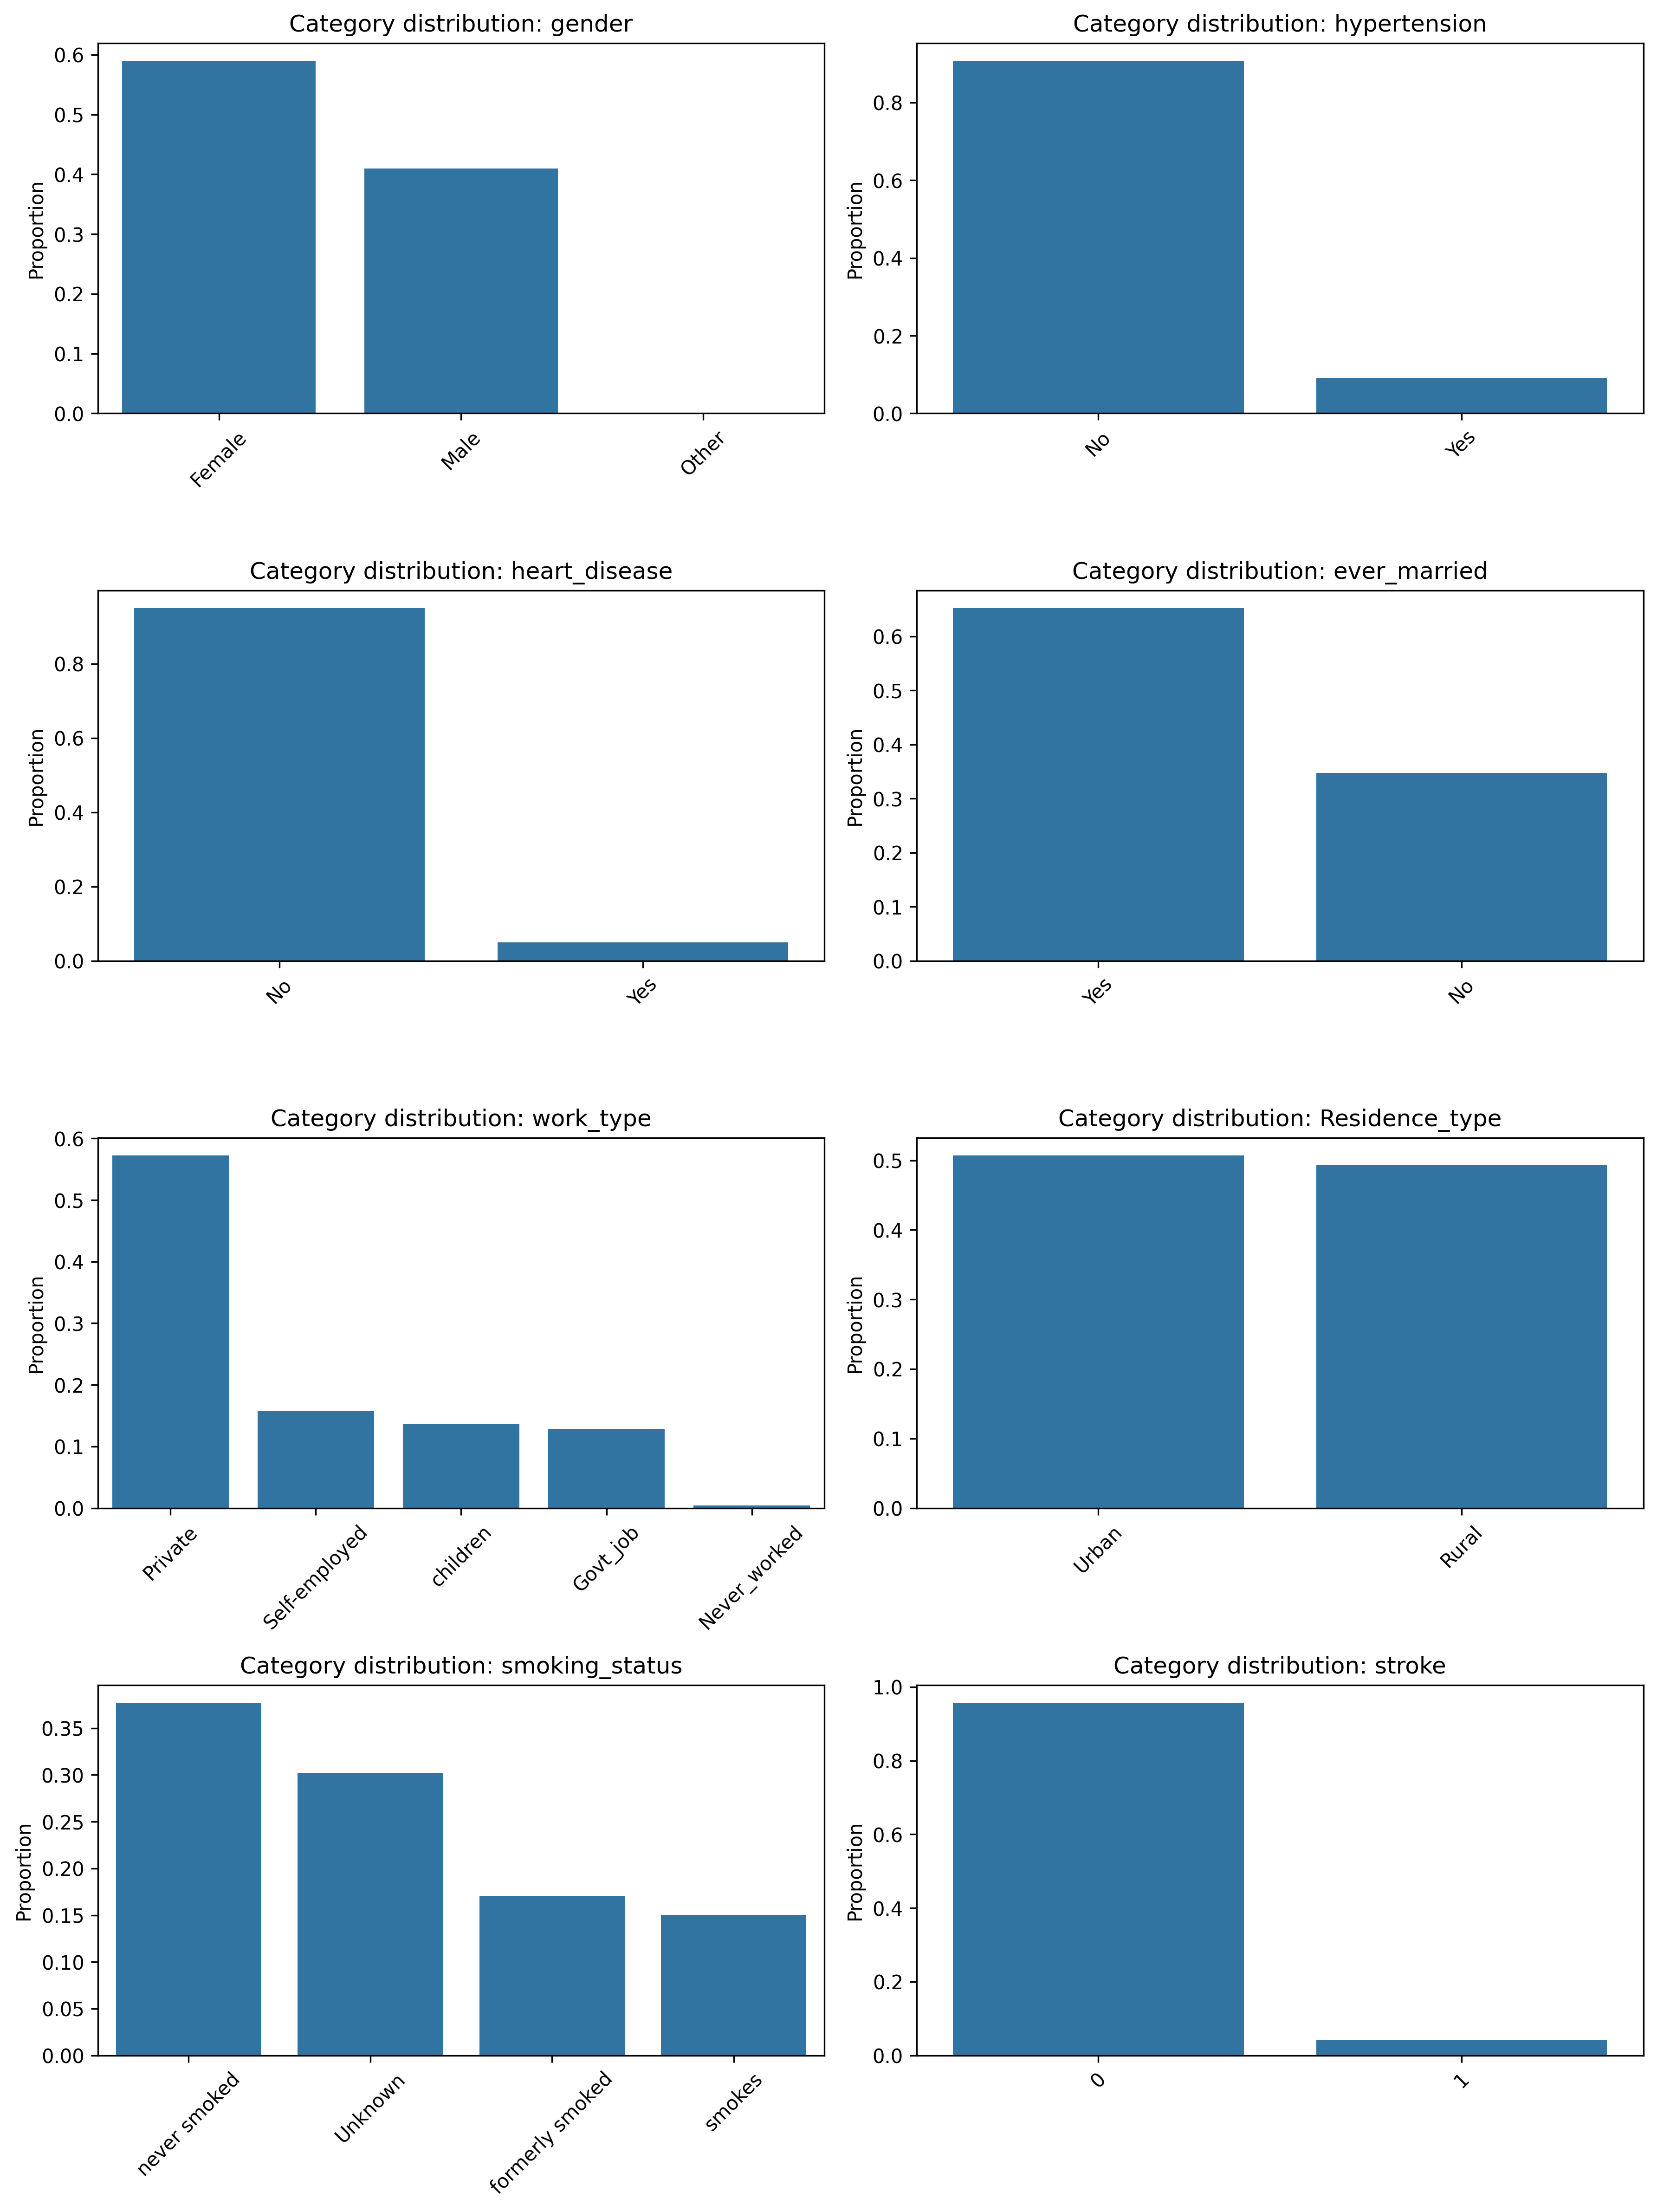

In [19]:
#Inspect categorical features' distribution
n_cols = 2
n_rows = int(np.ceil(len(categorical_cols) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))
axes = axes.flatten()
    
for i, col in enumerate(categorical_cols+target_col):
    ax = axes[i]

    #Compute proportions
    dist = df[col].value_counts(normalize=True).reset_index()
    dist.columns = [col, "proportion"]
    
    sns.barplot(data=dist, x=col, y="proportion", ax=ax)
    
    ax.set_title(f"Category distribution: {col}")
    ax.set_ylabel("Proportion")
    ax.set_xlabel("")
    ax.tick_params(axis="x", rotation=45)
    
# Turn off empty subplots if any
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
#plt.show()
show_shrunk(fig, width=800)

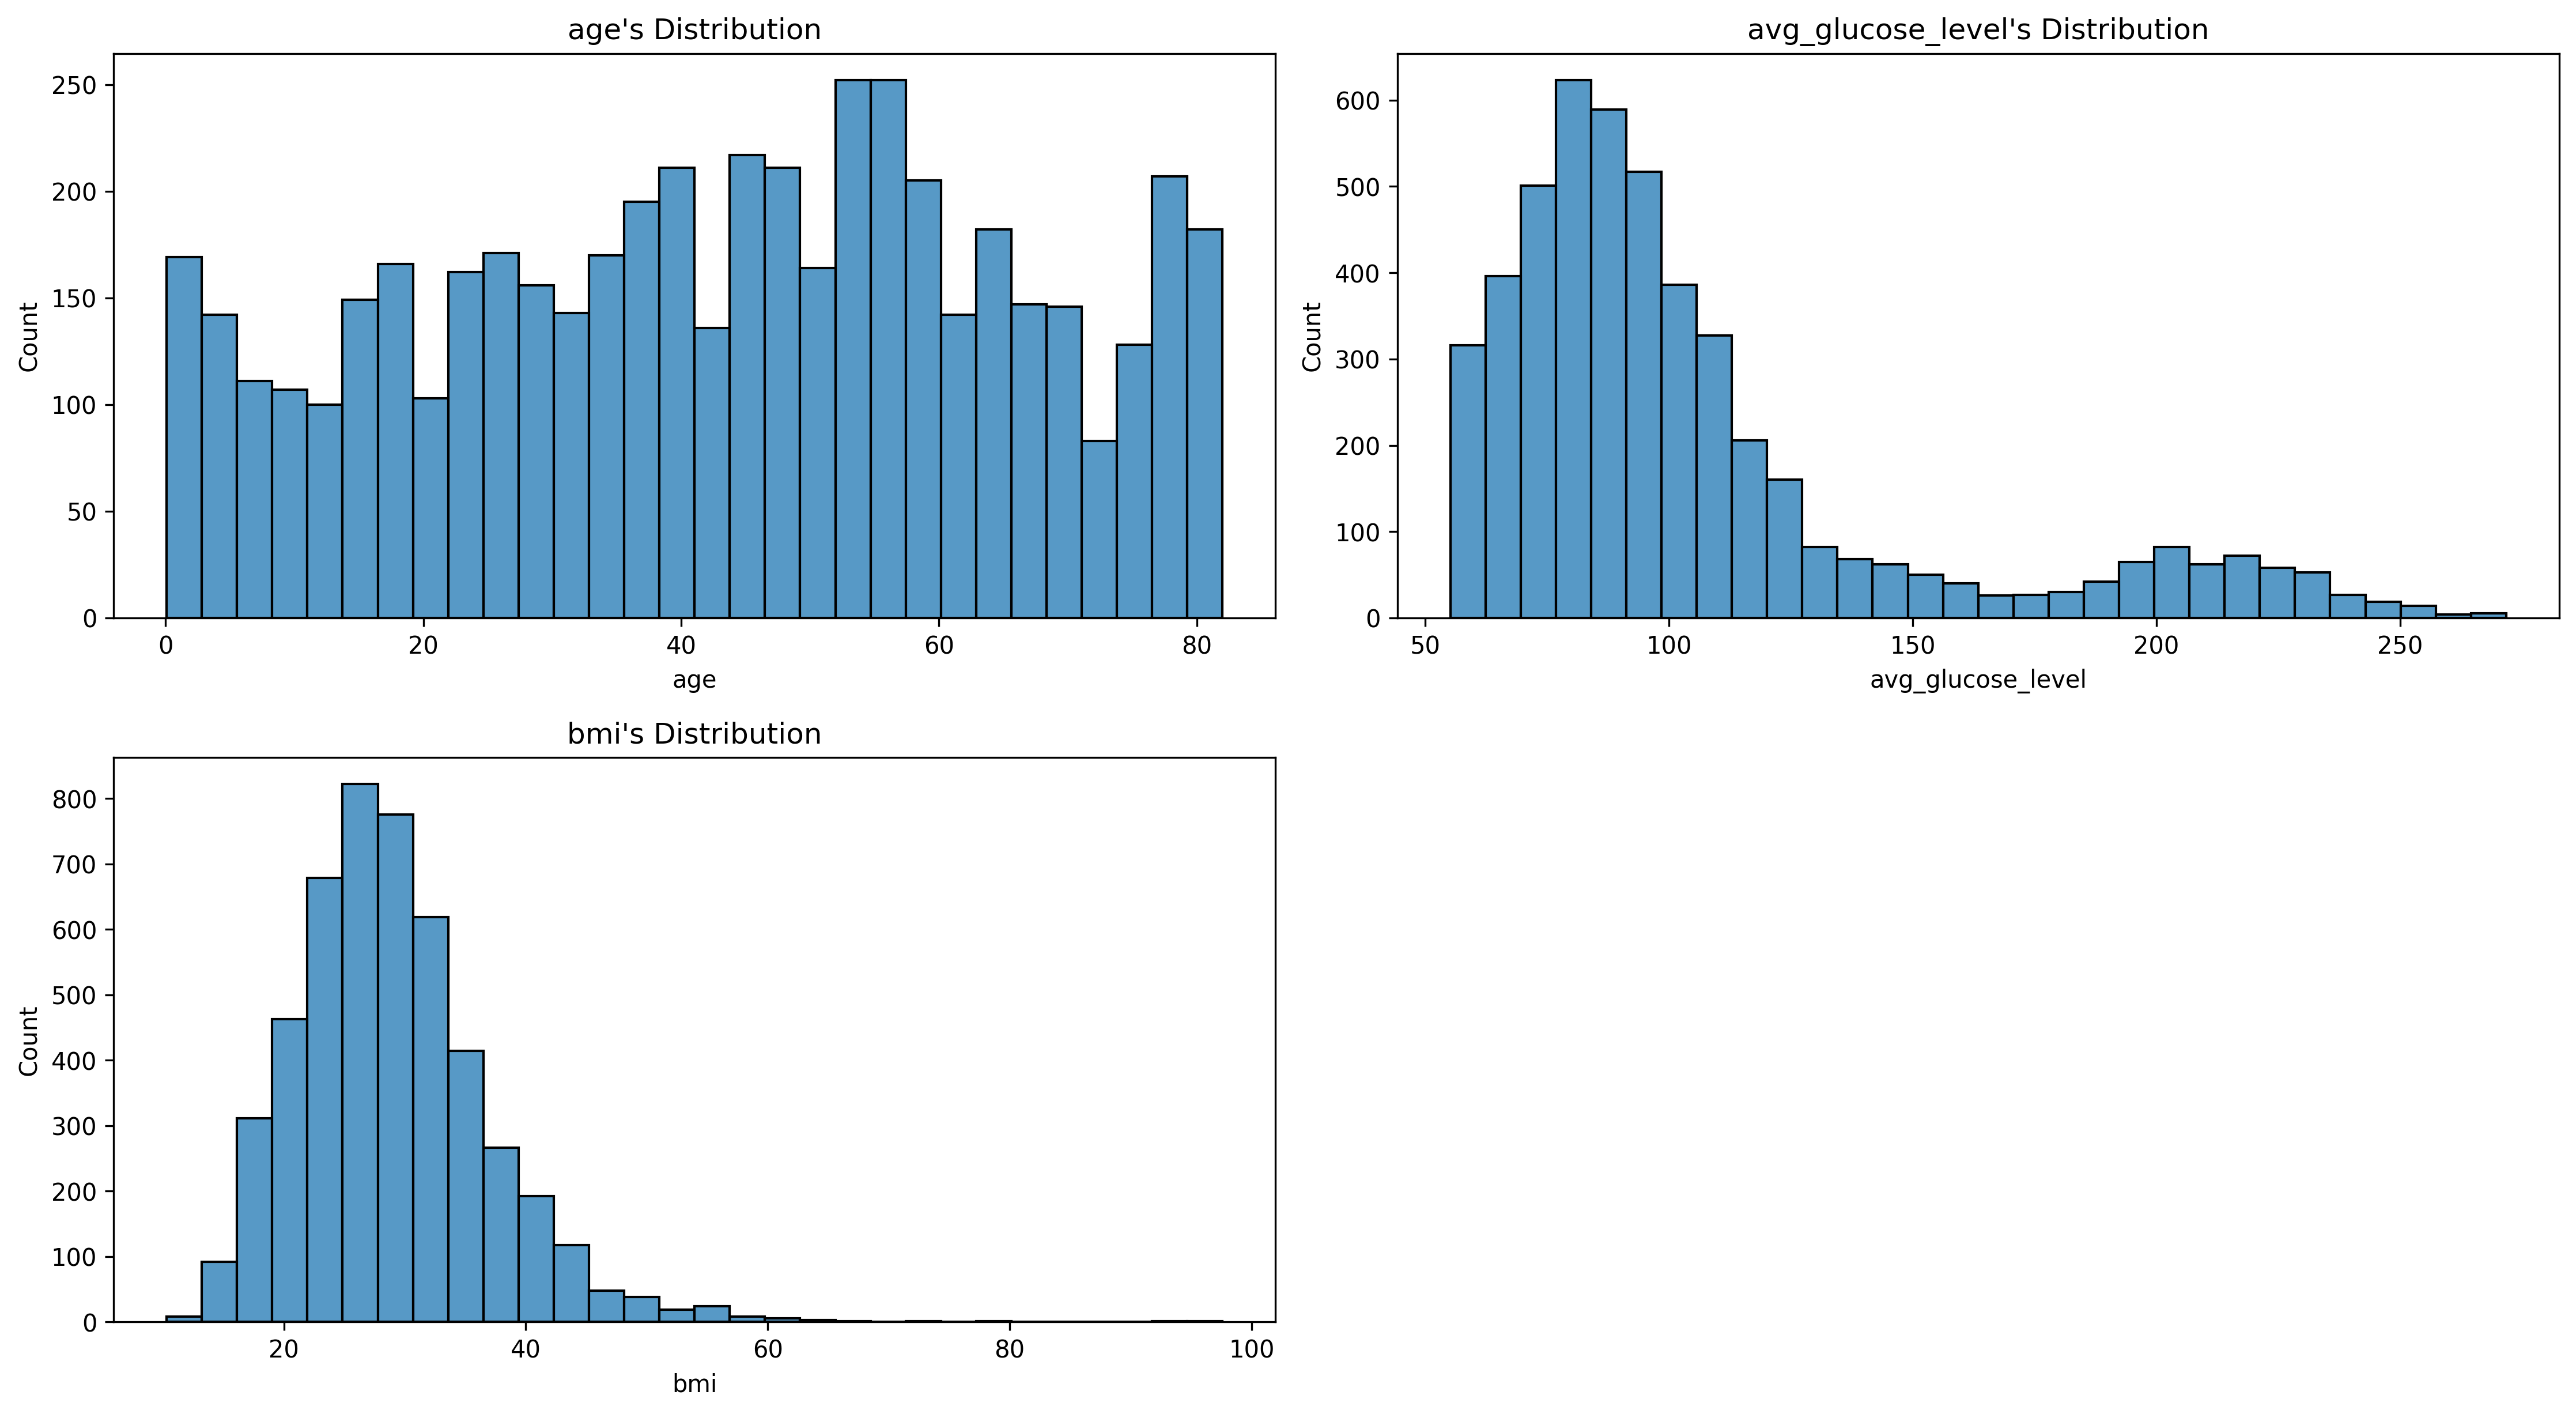

In [20]:
#Inspect numerical features' distribution

n_cols = 2
n_rows = int(np.ceil(len(categorical_cols) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axes =axes.flatten()

for i, col, in enumerate(numerical_cols):
    ax = axes[i]

    sns.histplot(data=df, x=df[col], bins=30, ax=ax)

    ax.set_title(f"{col}'s Distribution")


# Turn off empty subplots if any
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
#plt.show()
show_shrunk(fig, width=800)

## Observations

#### Age
- normally distributed


#### Averege glucose level
- seems well distributed, with a moderate skew to the right
- the small build up around 225 most likely indicates people with diabetes. This may be a predictor of stroke.


#### BMI
- normally distributed









### Inspect feature-to-target relationship

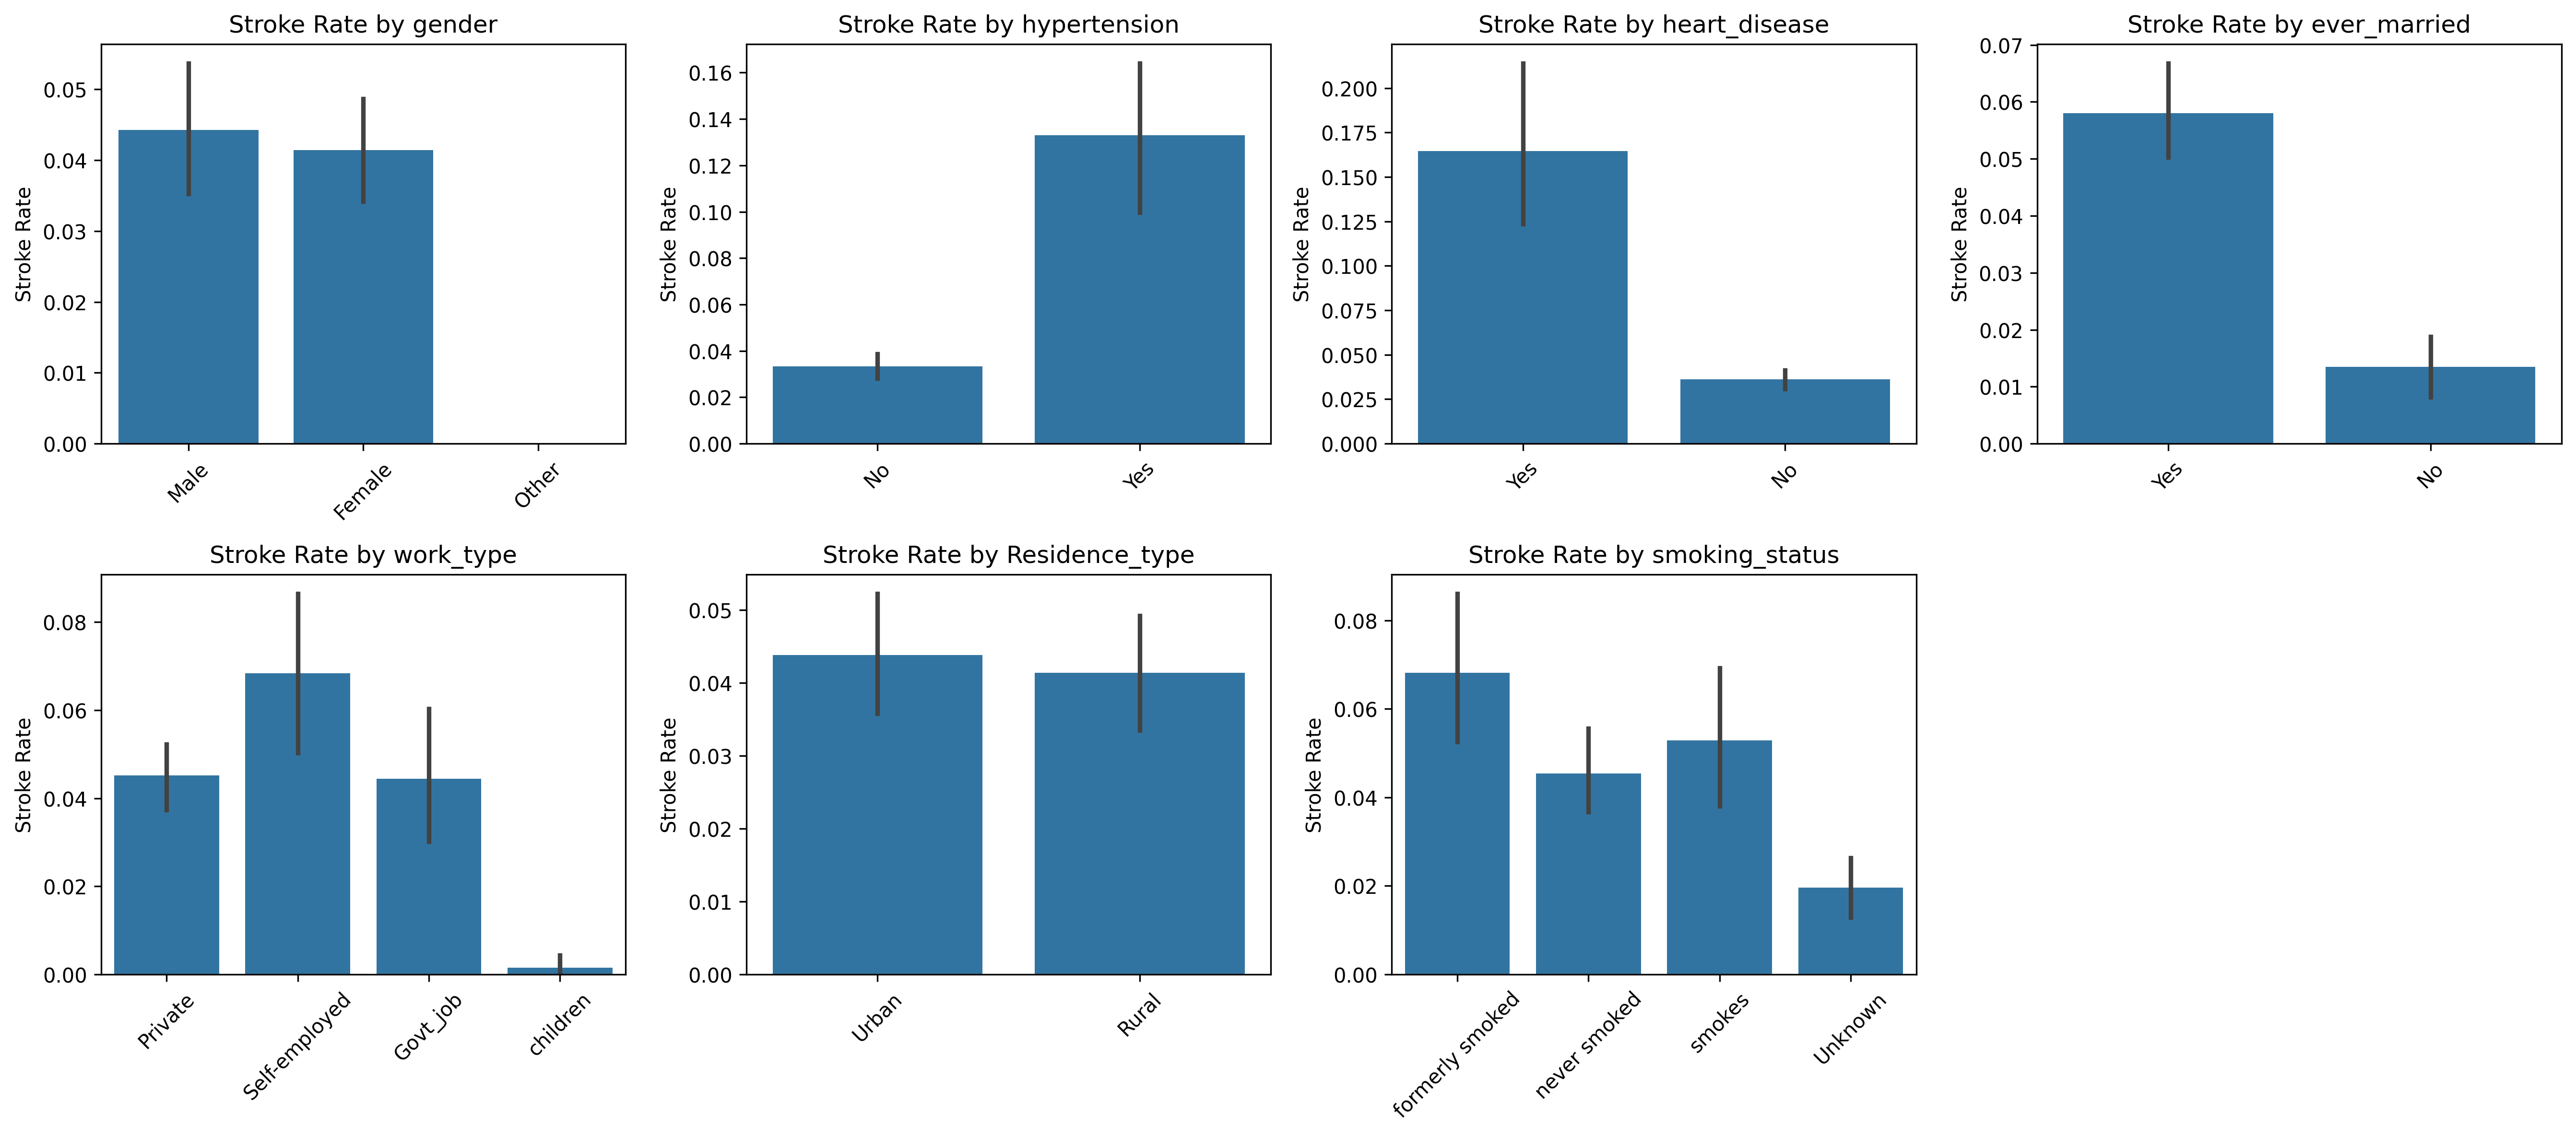

In [45]:
# Determine grid size (4 plots per row)
n_cols = 4
n_rows = int(np.ceil(len(categorical_cols) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    ax = axes[i]
    sns.barplot(data=df, x=col, y="stroke", ax=ax, estimator=np.mean)
    ax.set_title(f"Stroke Rate by {col}")
    ax.set_ylabel("Stroke Rate")
    ax.set_xlabel("")
    ax.tick_params(axis="x", rotation=45)

# Turn off empty subplots if any
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
#plt.show()
show_shrunk(fig, width=1200)

## Observations

### Gender
- `male` and `female` seems normally distributed
- `other` category is extremely low (<1%)

#### Action:
- Merge `other` into a generic `Unknown` group to prevent useless sparse columns when using one-hot encoding


### Work Type
- `never_worked` extremely low (<1%)
- `children` very low (~5%) but still relevent

#### Action:
- merge `never_worked` with `children`, also to prevent useless sparse columns with one-hot encoding


### Hypertension, heart-disease and smoking status
- distribution makes sense as it shows the potential risks associated with stroke. Keep as is.


### Ever married
- A bit of imbalance here, however, this could be a predictor of stroke. Keep as is.


### Residence type
- well distributed. Keep as is.

In [22]:
# Gender category
infoFrame = df['gender'].value_counts().to_frame(name="count")
infoFrame["proportion"] = df['gender'].value_counts(normalize=True)
infoFrame

count  proportion
gender                   
Female   2897    0.590141
Male     2011    0.409656
Other       1    0.000204

#### Update On action
- After observing that `other` only has one observation out of almost 5000, the statistical insignificance of keeping it in `other` should not have any impact on modeling.

In [23]:
# Work type category
infoFrame = df['work_type'].value_counts().to_frame(name="count")
infoFrame["proportion"] = df['work_type'].value_counts(normalize=True)
infoFrame

count  proportion
work_type                       
Private         2811    0.572622
Self-employed    775    0.157873
children         671    0.136688
Govt_job         630    0.128336
Never_worked      22    0.004482

In [24]:
# Merge `never_worked` with `children`
df['work_type'] = df['work_type'].replace({'Never_worked': 'children'})
infoFrame = df['work_type'].value_counts().to_frame(name="count")
infoFrame["proportion"] = df['work_type'].value_counts(normalize=True)
infoFrame

count  proportion
work_type                       
Private         2811    0.572622
Self-employed    775    0.157873
children         693    0.141169
Govt_job         630    0.128336

### Numeric-vs-stroke boxplots

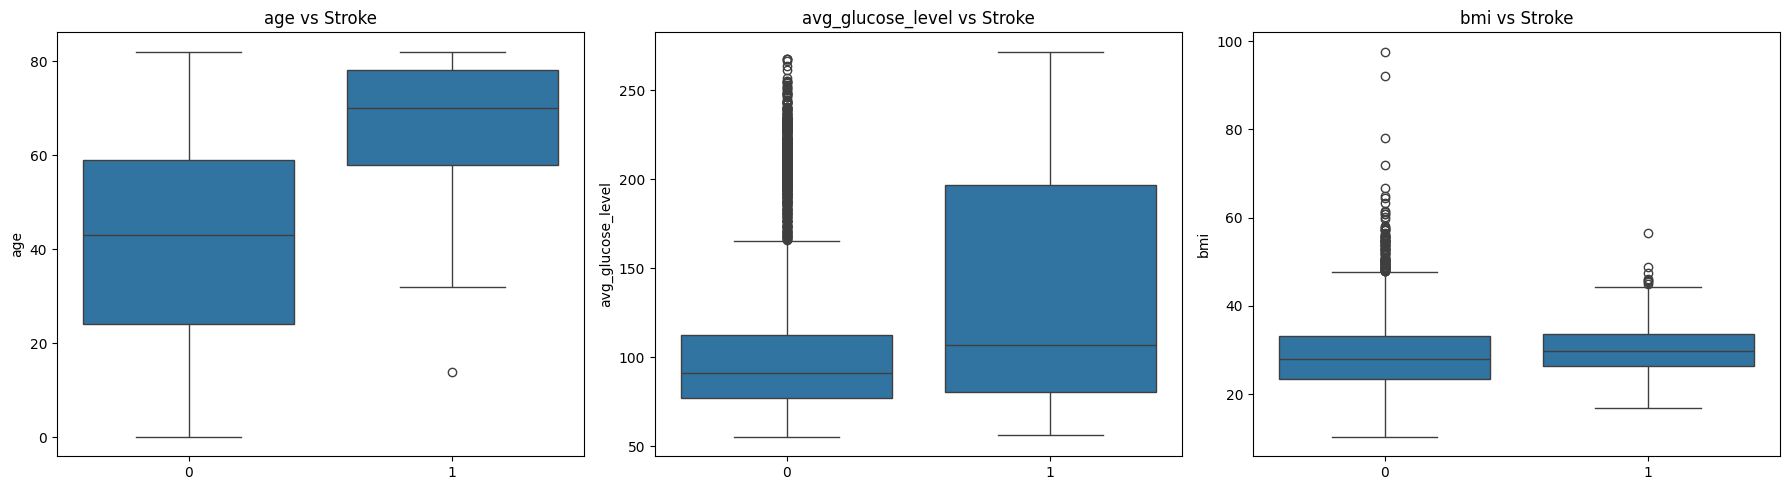

In [25]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, col in enumerate(['age', 'avg_glucose_level', 'bmi']):
    sns.boxplot(data=df, x="stroke", y=col, ax=axes[i])
    axes[i].set_title(f"{col} vs Stroke")
    axes[i].set_xlabel("")
plt.tight_layout()
plt.show()


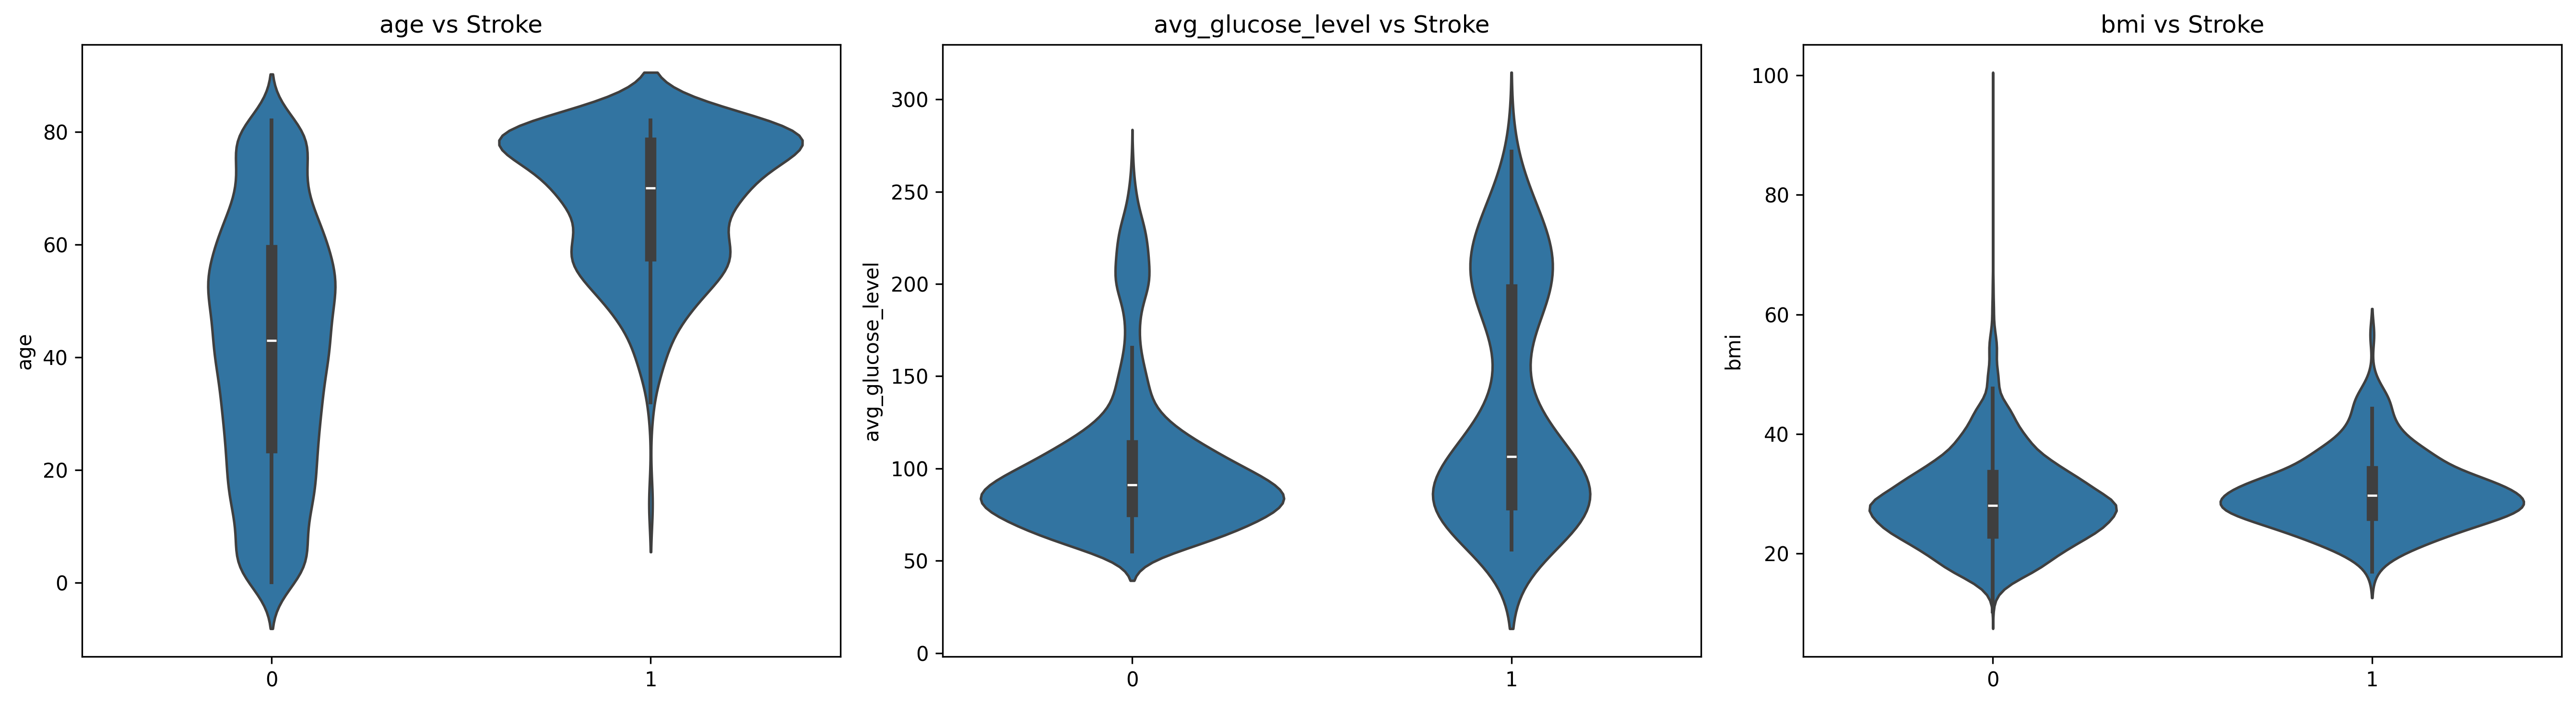

In [44]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, col in enumerate(['age', 'avg_glucose_level', 'bmi']):
    sns.violinplot(data=df, x="stroke", y=col, ax=axes[i])
    axes[i].set_title(f"{col} vs Stroke")
    axes[i].set_xlabel("")
plt.tight_layout()
plt.show()

### Correlation with the stroke target (numeric only)

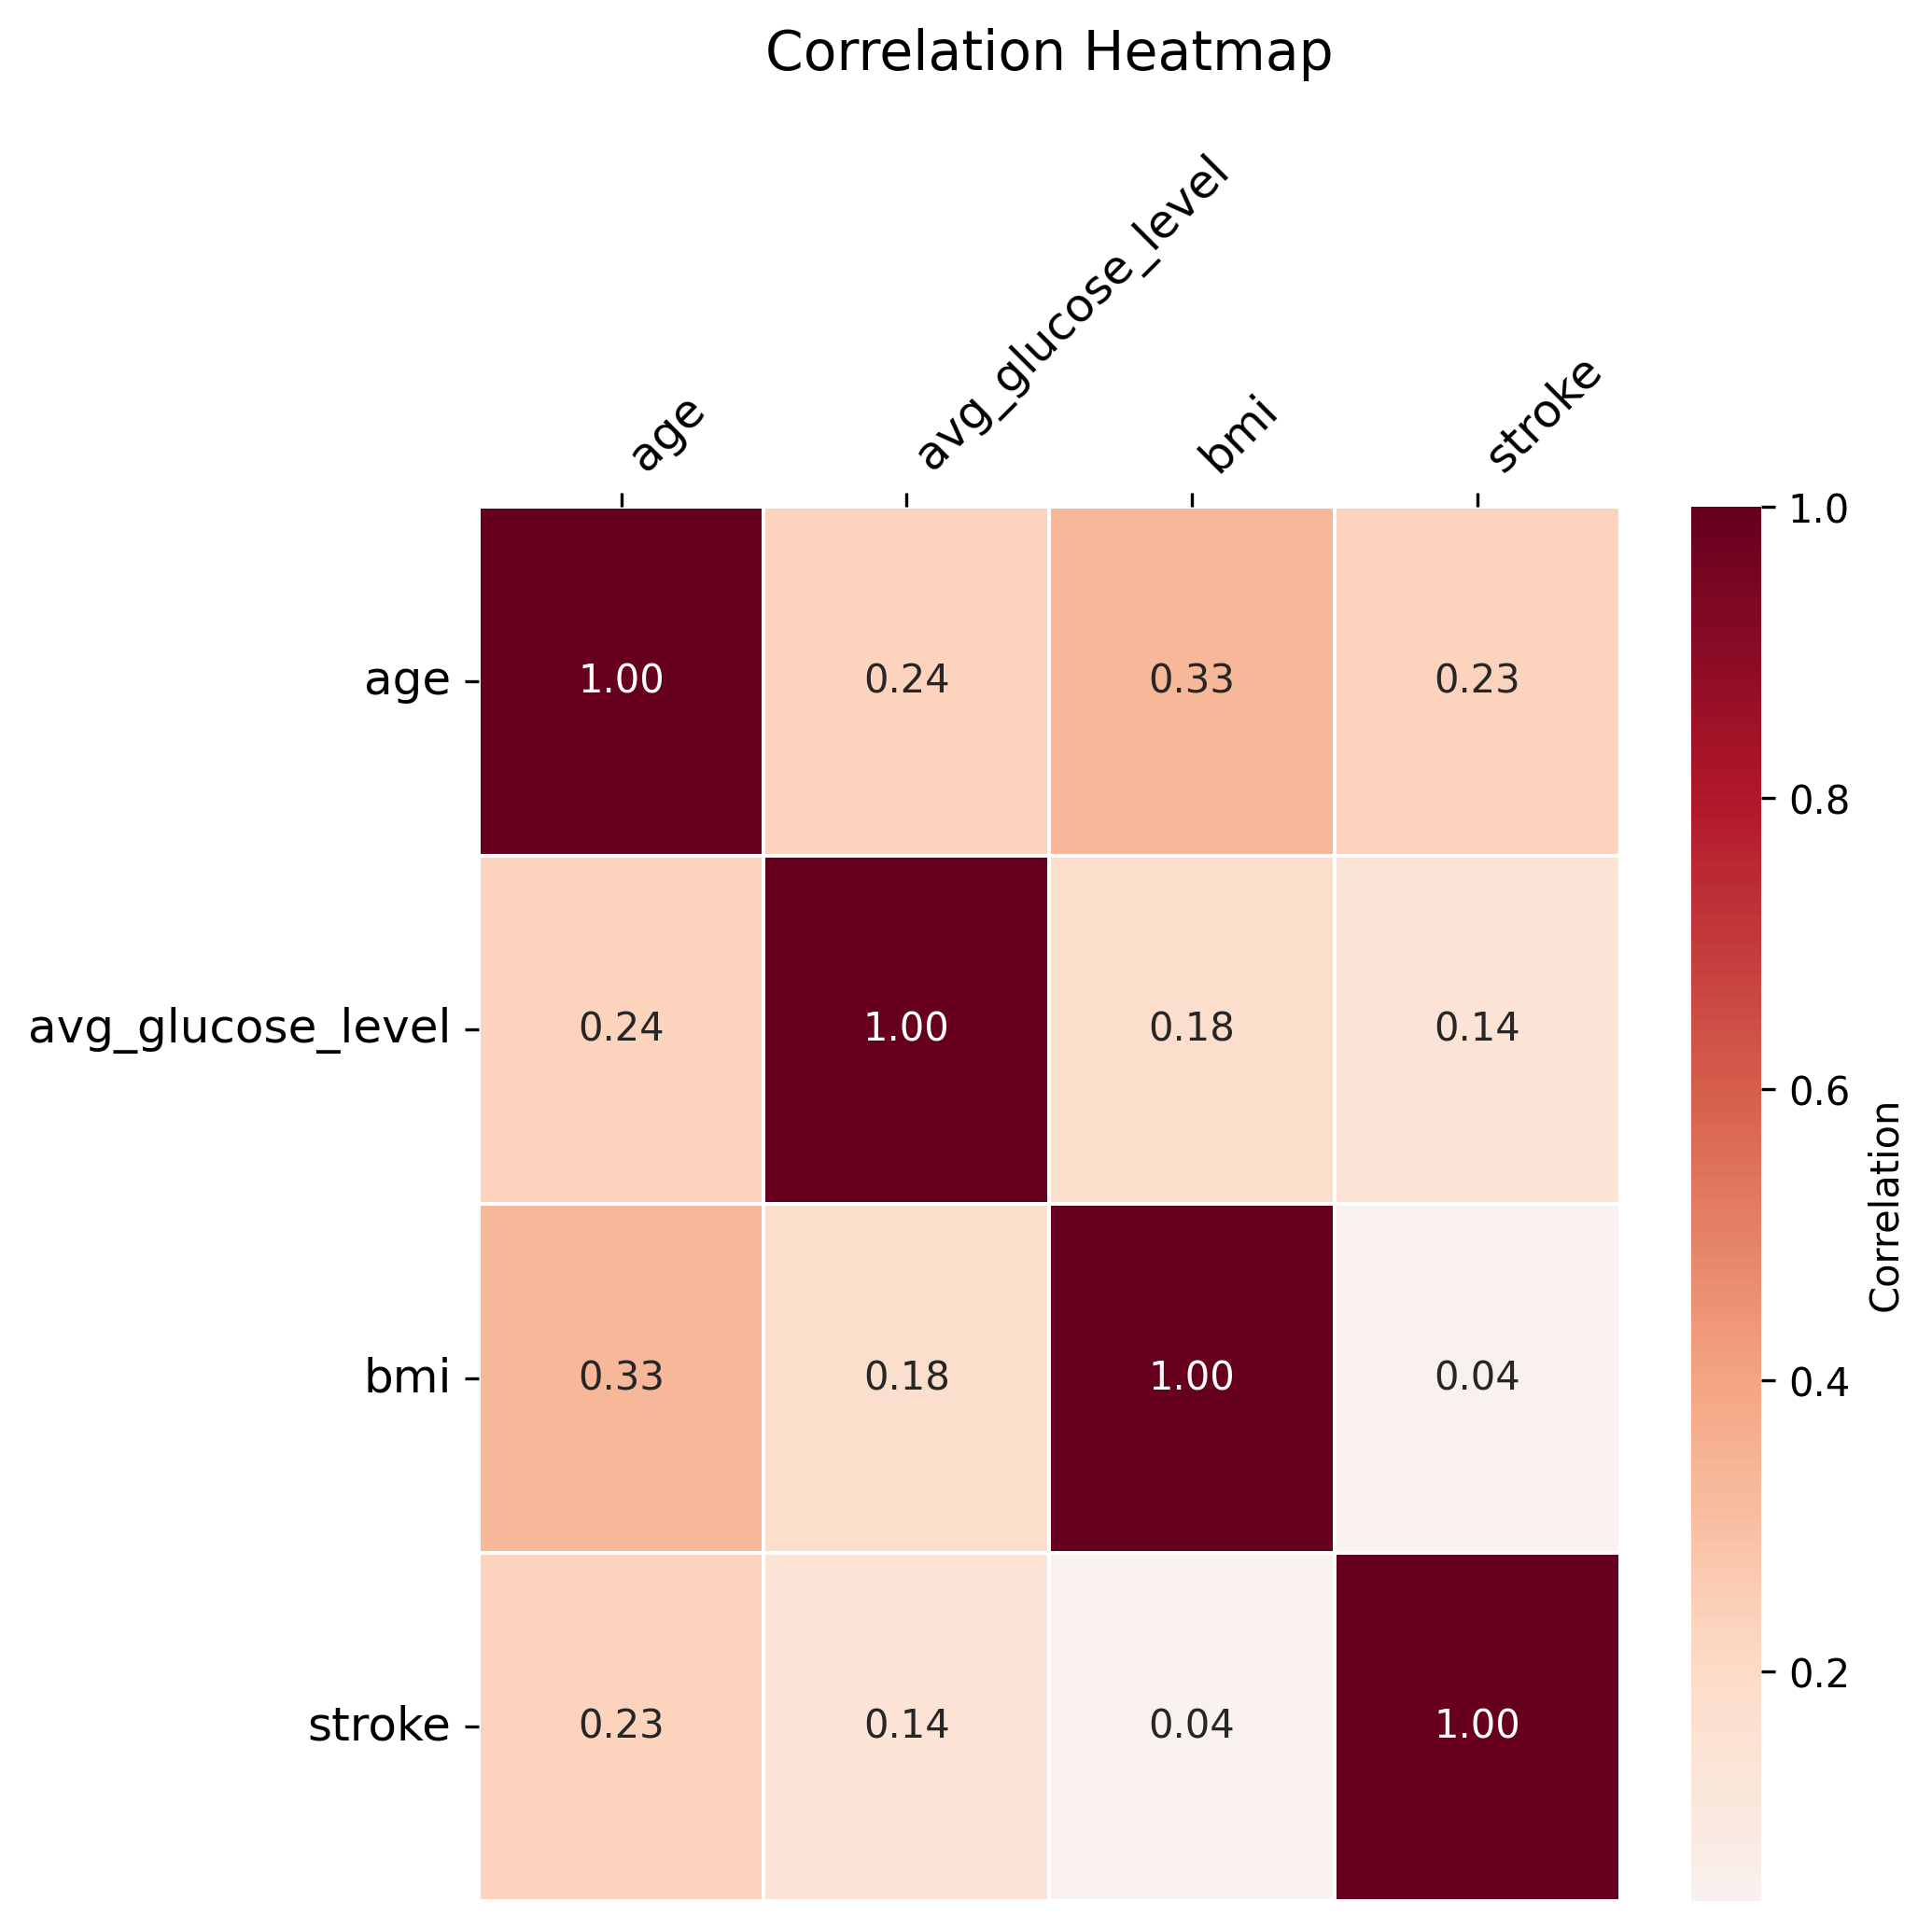

In [26]:
corr_data = df[['age', 'avg_glucose_level', 'bmi', 'stroke']].corr()

fig, ax = plt.subplots(figsize=(7,7))

sns.heatmap(data=corr_data, 
            annot=True,
            fmt=".2f",
            cmap="RdBu_r",
            center=0,
            linewidths=0.5,
            cbar_kws={'label': 'Correlation'})

ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')

plt.xticks(rotation=45, ha='left', fontsize=12)
plt.yticks(rotation=0, fontsize=12)
ax.set_title("Correlation Heatmap", pad=20, fontsize=14)

plt.tight_layout()

#plt.savefig("imgs/heatmap.png", dpi=300, bbox_inches='tight')
#plt.show()
show_shrunk(fig, width=500)

### Post EDA observations

#### A) Strong class imbalance
 - Stroke cases ~5% vs non-stroke cases ~95%

#### Consequences

 - accuracy becomes meaningless
 - recall for the positive class is crucial
 - ROC-AUC is a better general metric than accuracy
 - Precision is important if you care about reducing false alerts
 - Treshold tuning may be needed after training

##### Plan
- use class_weight, recall, or AUC-focused models


#### B) Mix of Feature Types

- Numeric: `age`, `avg_glucose_level`, `BMI`
- Categorical: `gender`, `ever_married`, `work_type`, `Residene_type`, `smoking_status`, `hypertension`, `heart_disease`
    - will require ColumnTransformer with scaling + one-hot encoding

- SVMs and LogisticRegession require scaling
- Trees and ensembles do not use scaling


#### C) Some Numeric Features are skewed

- `avg_glucose_level` is moderately right-skewed
- `BMI` approximately gamma-shaped
-  `age` has natural peaks

- Scaling neede for SMV, LogisticRegression


#### D) Rare categories in Categorical Features

- `gender`: 'other' appears once
- `work_type`: 'never_worked' merged with 'children'

- Rare level should not harm tree-models
- But may destabilize linear models if one-hot produces sparse columns


#### D) Medical dataset

- clinical variables matter: `hypertension`, `heat_disease`, `age`
- high interpretability is desirable
- models must avoid bias against minority categories

- Prefer models with interpretable explanations (LogReg, Tree-based)

### Run models

In [56]:
# Prepare train and test datasets

X = df.drop(columns=["stroke"])
y = df["stroke"]

print("Original:")
print(df["stroke"].value_counts(normalize=True))

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=.8, 
                                                    random_state=42, 
                                                    stratify=y)

# Just for sanity check, I verified that the stratify parameter worked, since `stroke` is very imbalanced.
print("Train:")
print(y_train.value_counts(normalize=True))

print("Test:")
print(y_test.value_counts(normalize=True))

Original:
stroke
0    0.957425
1    0.042575
Name: proportion, dtype: float64
Train:
stroke
0    0.957474
1    0.042526
Name: proportion, dtype: float64
Test:
stroke
0    0.95723
1    0.04277
Name: proportion, dtype: float64


In [57]:
# Models setup
preprocessor = make_preprocessor(numerical_cols, categorical_cols, scale_numeric=True)

selected_models = ["log_reg", "rf_clf", "gb_clf", "svc_rbf"]

# Apply selection to models and param_grids librairy
models = {name: all_models[name] for name in selected_models}
param_grids = {name: all_param_grids[name] for name in selected_models}

pp.pprint(param_grids)


{'gb_clf': {'clf__learning_rate': [0.01, 0.05, 0.1],
            'clf__max_depth': [3, 5],
            'clf__min_samples_leaf': [1, 2, 4],
            'clf__min_samples_split': [2, 5],
            'clf__n_estimators': [100, 200, 300]},
 'log_reg': {'clf__C': [0.01, 0.1, 1, 10],
             'clf__class_weight': [None, 'balanced'],
             'clf__penalty': ['l2']},
 'rf_clf': {'clf__class_weight': ['balanced'],
            'clf__max_depth': [None, 10, 20],
            'clf__max_features': ['sqrt', 'log2'],
            'clf__min_samples_split': [2, 5, 10],
            'clf__n_estimators': [10, 100, 500]},
 'svc_rbf': {'clf__C': [0.1, 1, 10, 100],
             'clf__class_weight': [None, 'balanced'],
             'clf__gamma': ['scale', 1, 0.1, 0.001, 0.0001]}}



===== Training log_reg =====

Fitting 5 folds for each of 8 candidates, totalling 40 fits


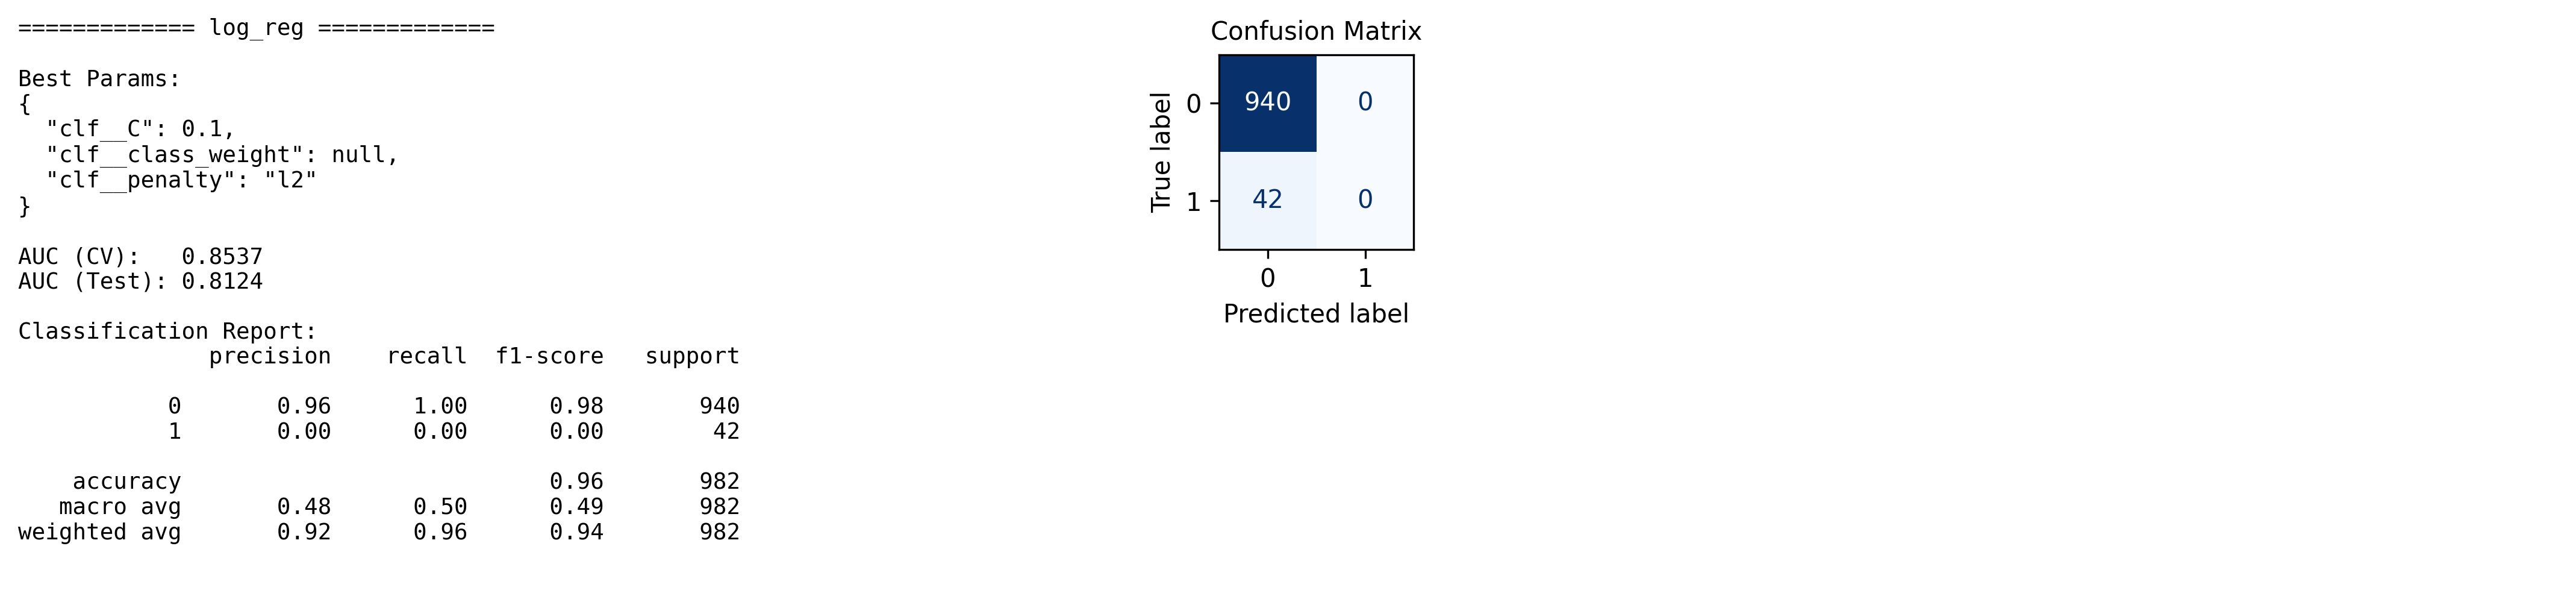


===== Training rf_clf =====

Fitting 5 folds for each of 54 candidates, totalling 270 fits


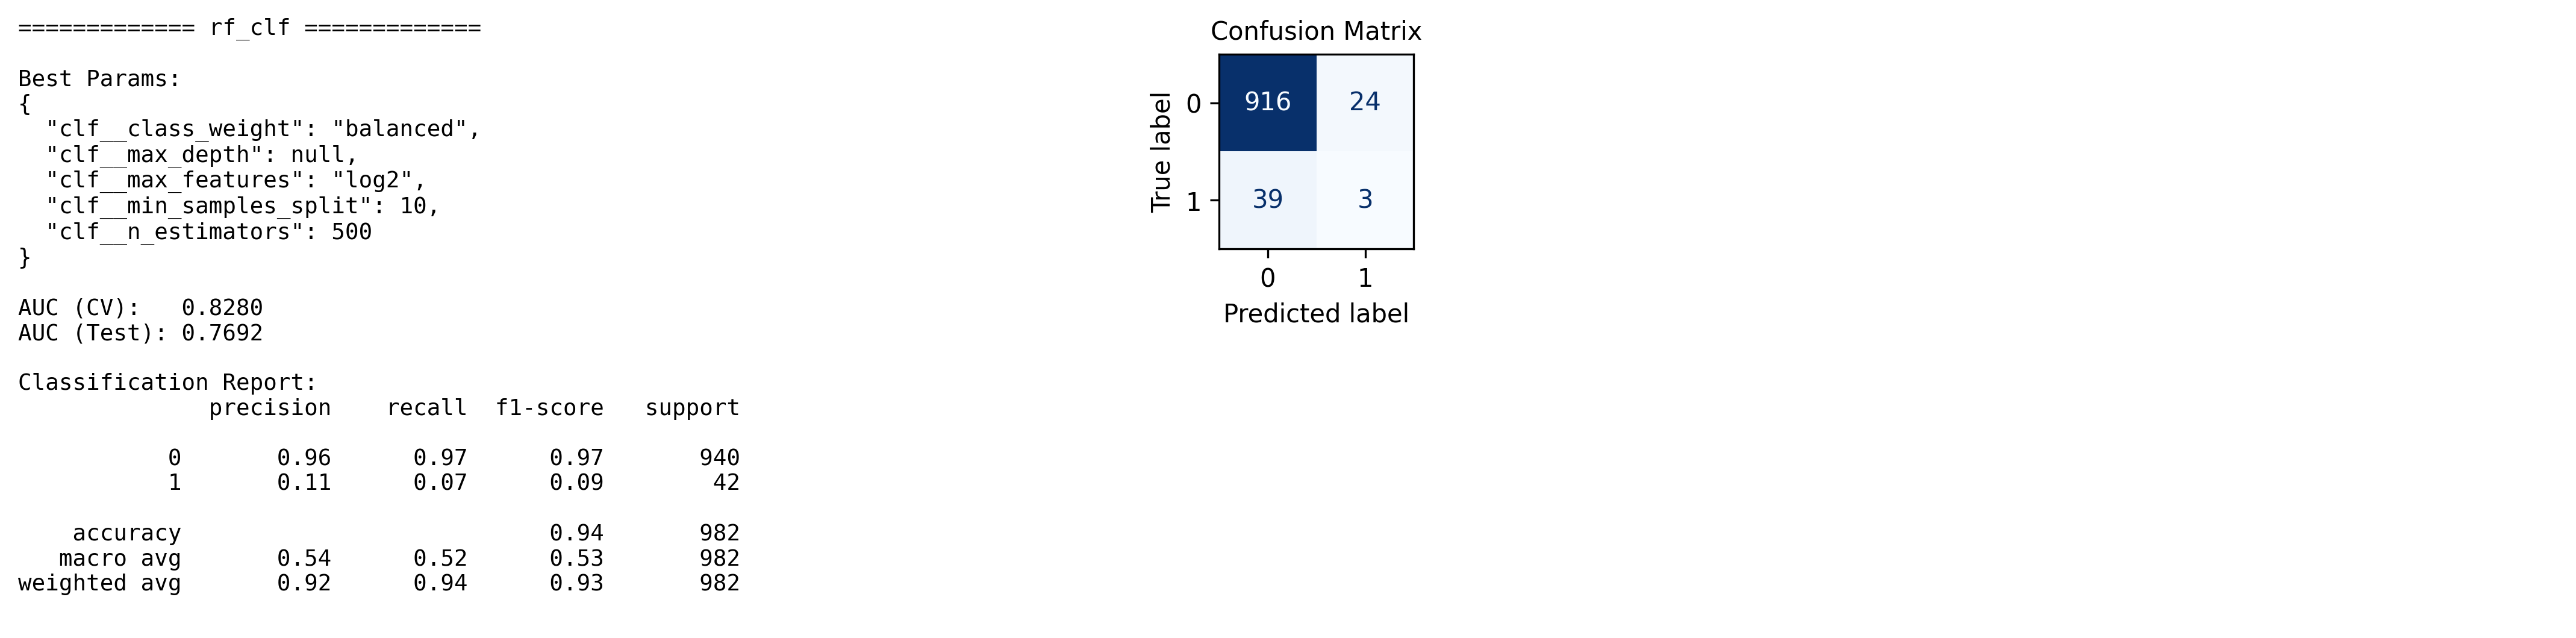


===== Training gb_clf =====

Fitting 5 folds for each of 108 candidates, totalling 540 fits


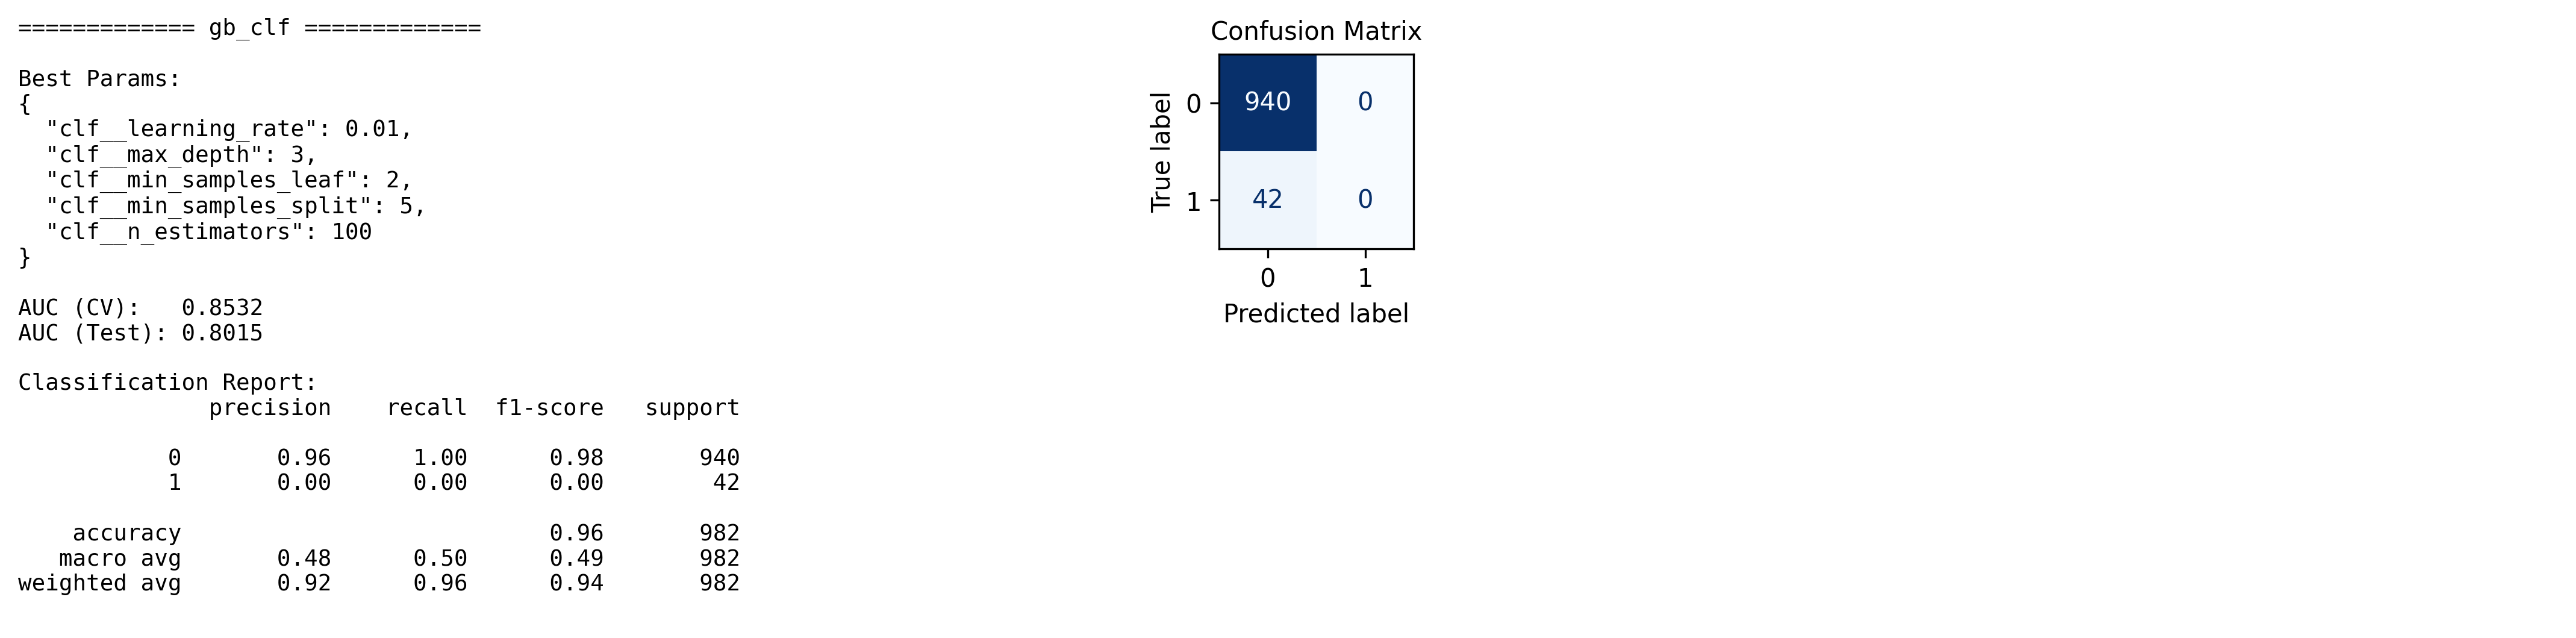


===== Training svc_rbf =====

Fitting 5 folds for each of 40 candidates, totalling 200 fits


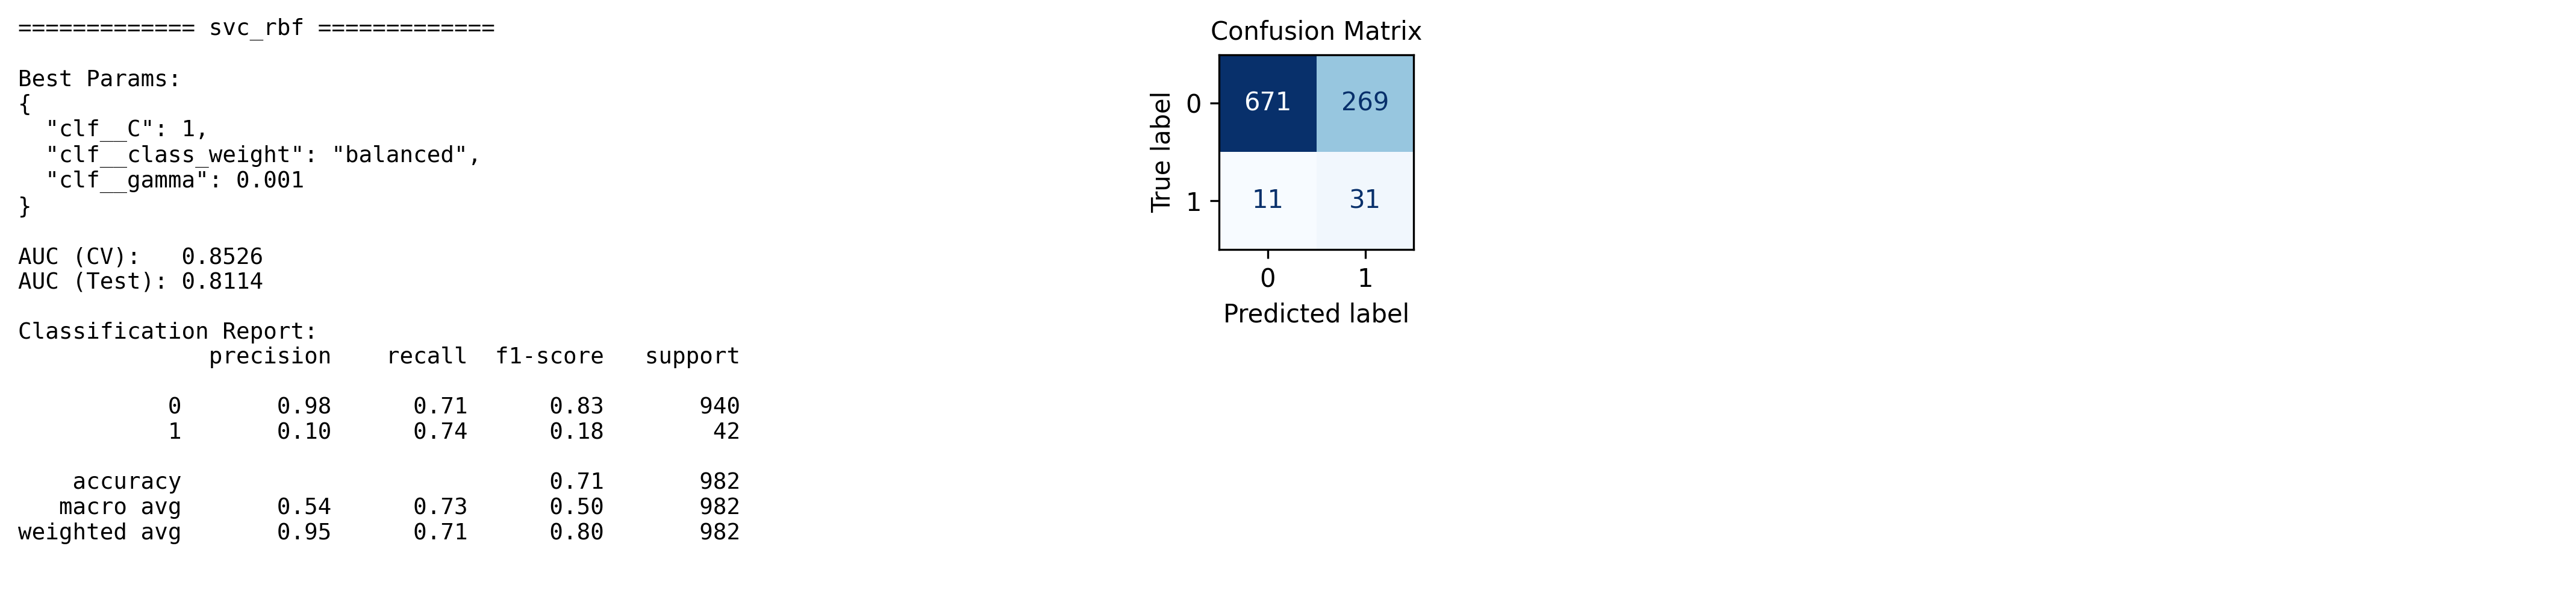

In [58]:
# Run Models
results = run_multiple_models(models, param_grids, preprocessor,
                            X_train, y_train, X_test, y_test, scoring='roc_auc')

In [30]:
#Fine tune some paramters

pp.pprint(param_grids)

{'gb_clf': {'clf__learning_rate': [0.01, 0.05, 0.1],
            'clf__max_depth': [3, 5],
            'clf__min_samples_leaf': [1, 2, 4],
            'clf__min_samples_split': [2, 5],
            'clf__n_estimators': [100, 200]},
 'log_reg': {'clf__C': [0.01, 0.1, 1, 10],
             'clf__class_weight': [None, 'balanced'],
             'clf__penalty': ['l2']},
 'rf_clf': {'clf__class_weight': [None, 'balanced'],
            'clf__max_depth': [None, 10, 20],
            'clf__min_samples_leaf': [1, 2, 4],
            'clf__min_samples_split': [2, 5],
            'clf__n_estimators': [100, 200, 300]},
 'svc_rbf': {'clf__C': [0.1, 1, 10],
             'clf__class_weight': [None, 'balanced'],
             'clf__gamma': ['scale', 0.01, 0.1]}}


In [59]:
param_grids['log_reg']['clf__class_weight']=['balanced']
param_grids['rf_clf']['clf__n_estimators']=[500,700,900]
param_grids['rf_clf']['clf__min_samples_split']=[8,10,15,20]
param_grids['gb_clf']['clf__learning_rate']=[.01, .005, .001]
param_grids['gb_clf']['clf__max_depth']=[1,2, 3, 4]
param_grids['gb_clf']['clf__min_samples_split']=[4,5,6]
param_grids['svc_rbf']['clf__C']=[.5,1,2,5,7]
param_grids['svc_rbf']['clf__class_weight']=['balanced']
param_grids['svc_rbf']['clf__gamma']=[.01, .005, .002 , .001, .00075]

pp.pprint(param_grids)

{'gb_clf': {'clf__learning_rate': [0.01, 0.005, 0.001],
            'clf__max_depth': [1, 2, 3, 4],
            'clf__min_samples_leaf': [1, 2, 4],
            'clf__min_samples_split': [4, 5, 6],
            'clf__n_estimators': [100, 200, 300]},
 'log_reg': {'clf__C': [0.01, 0.1, 1, 10],
             'clf__class_weight': ['balanced'],
             'clf__penalty': ['l2']},
 'rf_clf': {'clf__class_weight': ['balanced'],
            'clf__max_depth': [None, 10, 20],
            'clf__max_features': ['sqrt', 'log2'],
            'clf__min_samples_split': [8, 10, 15, 20],
            'clf__n_estimators': [500, 700, 900]},
 'svc_rbf': {'clf__C': [0.5, 1, 2, 5, 7],
             'clf__class_weight': ['balanced'],
             'clf__gamma': [0.01, 0.005, 0.002, 0.001, 0.00075]}}



===== Training log_reg =====

Fitting 5 folds for each of 4 candidates, totalling 20 fits


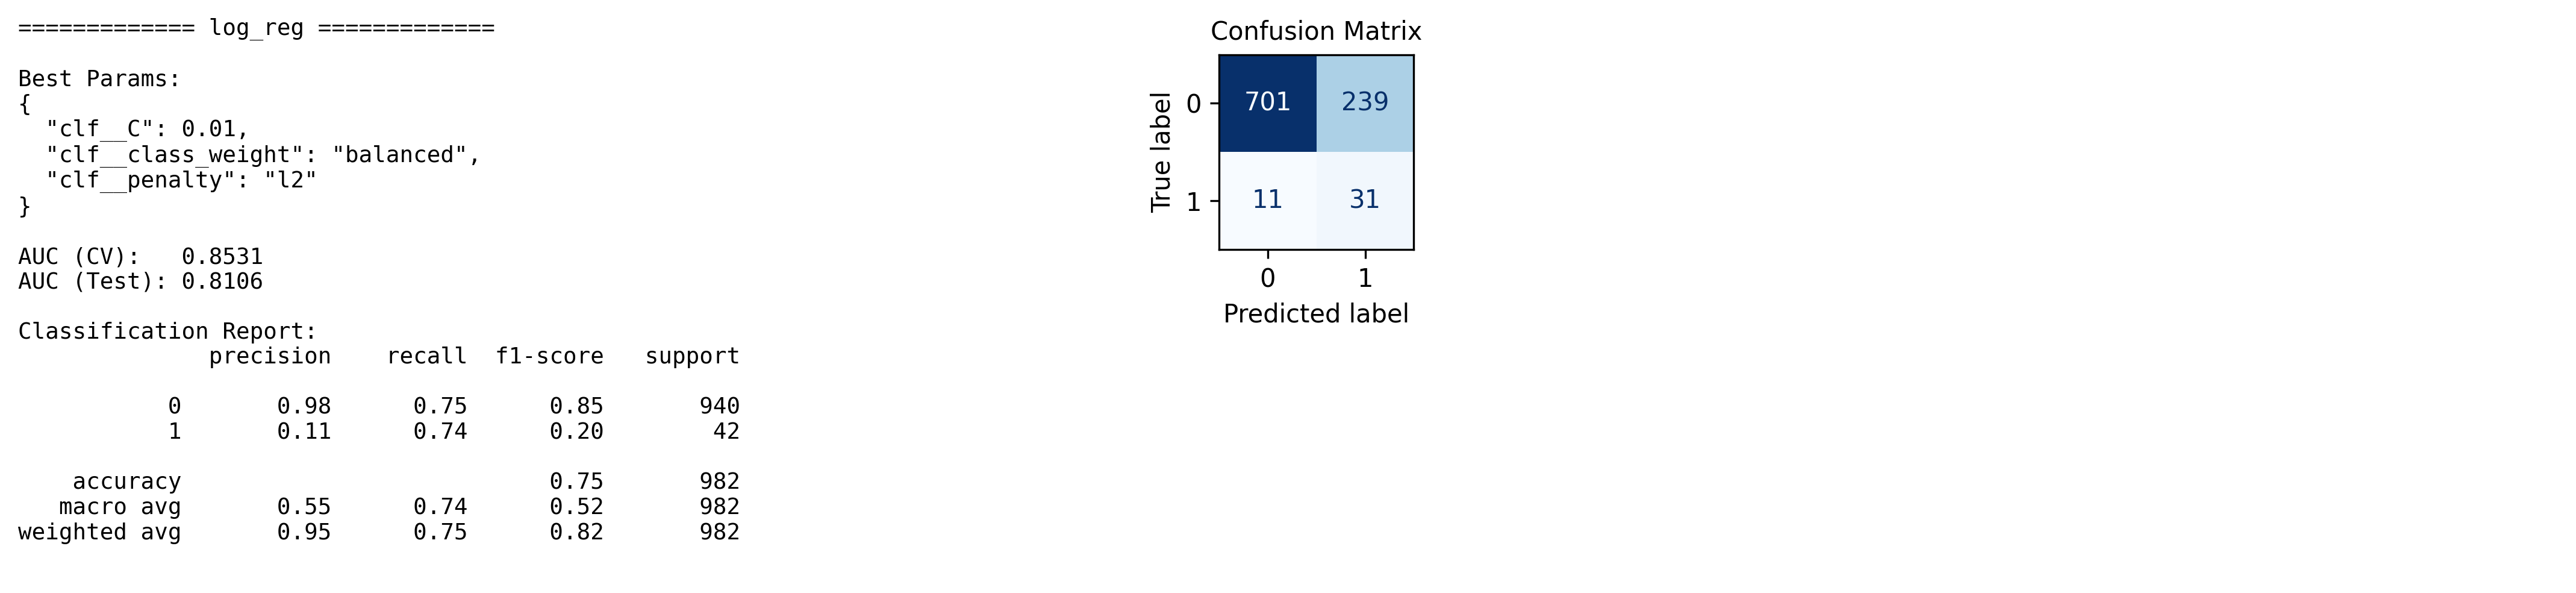


===== Training rf_clf =====

Fitting 5 folds for each of 72 candidates, totalling 360 fits


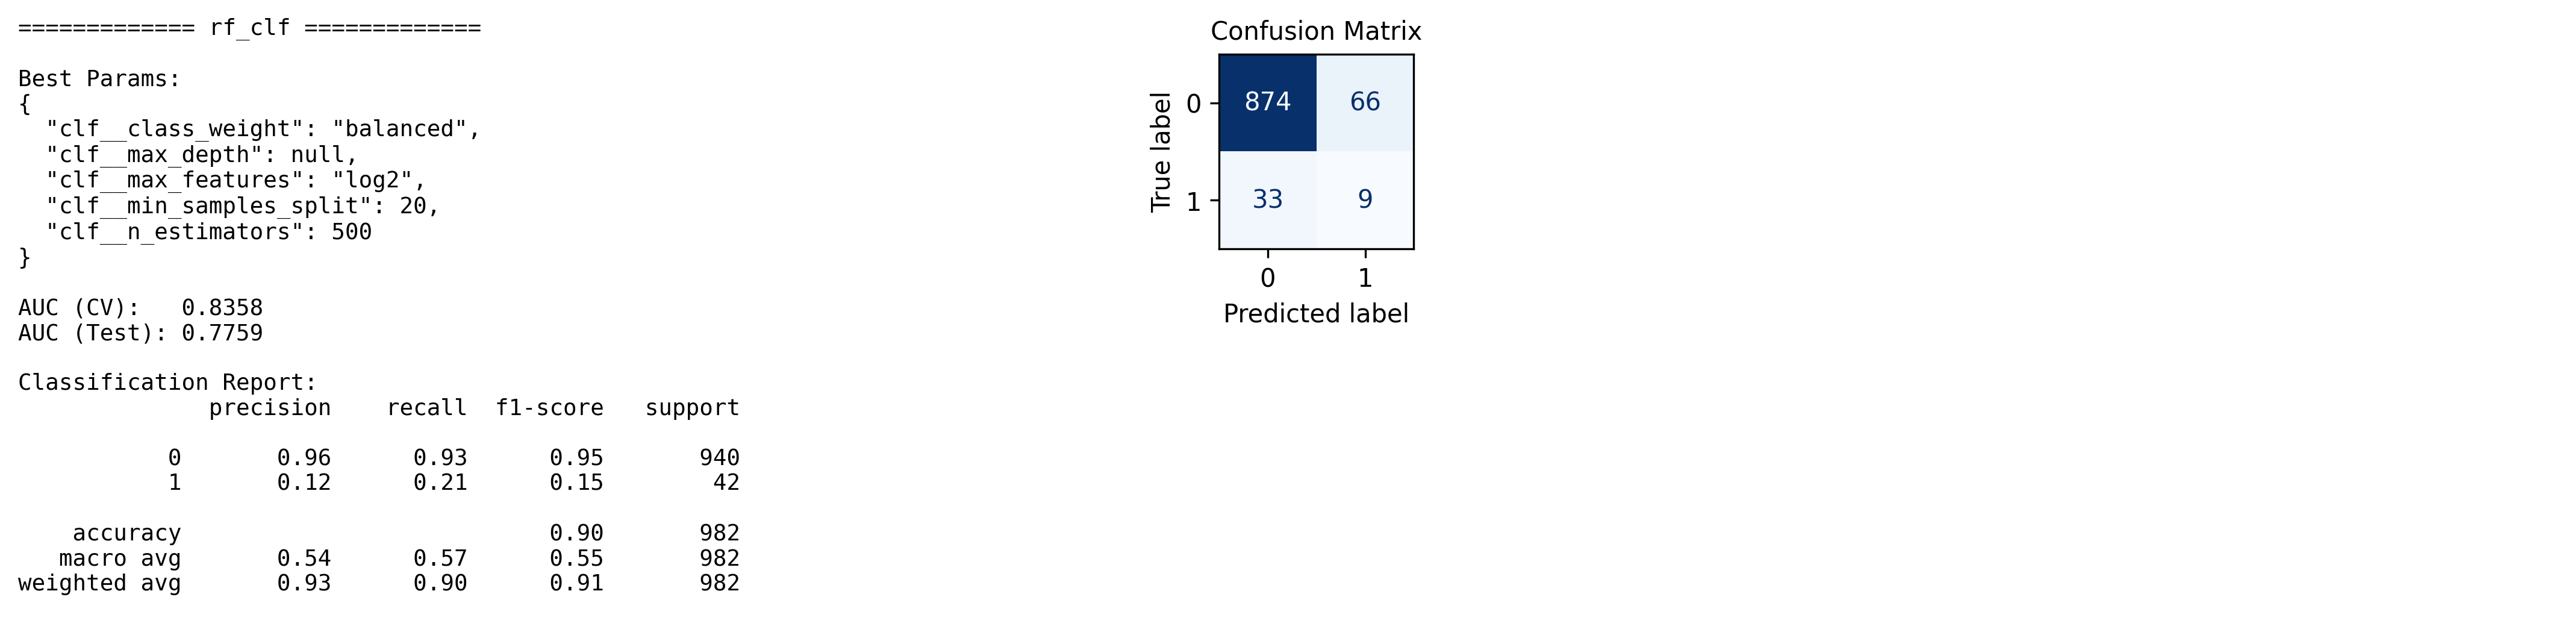


===== Training gb_clf =====

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


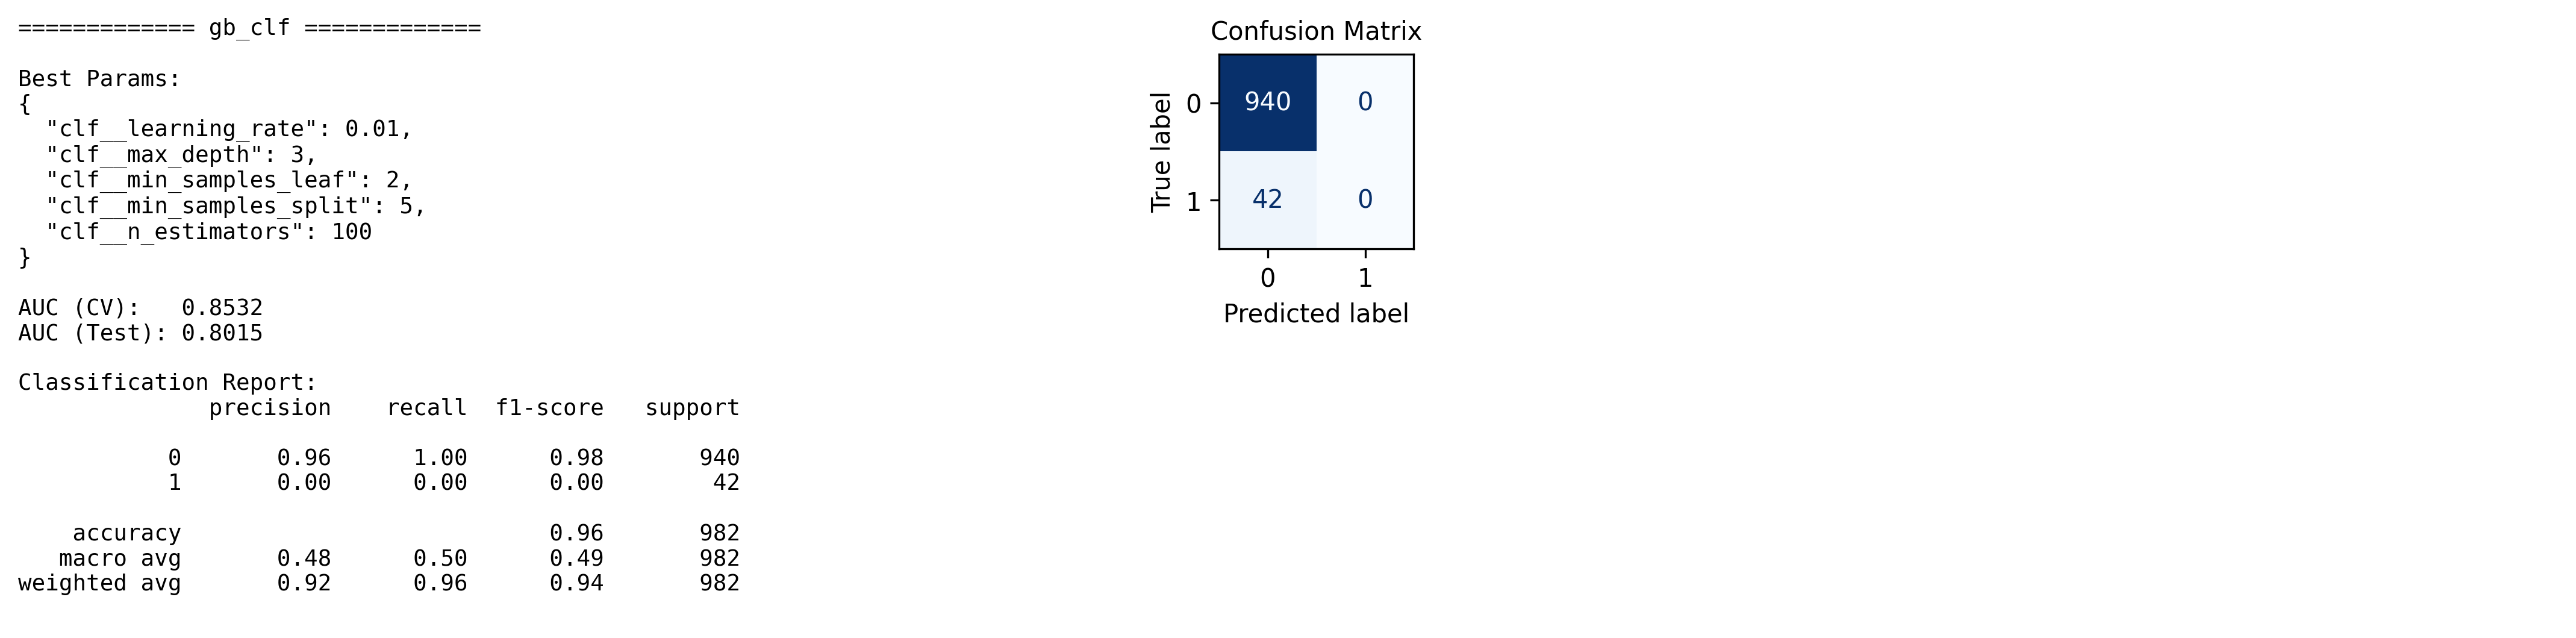


===== Training svc_rbf =====

Fitting 5 folds for each of 25 candidates, totalling 125 fits


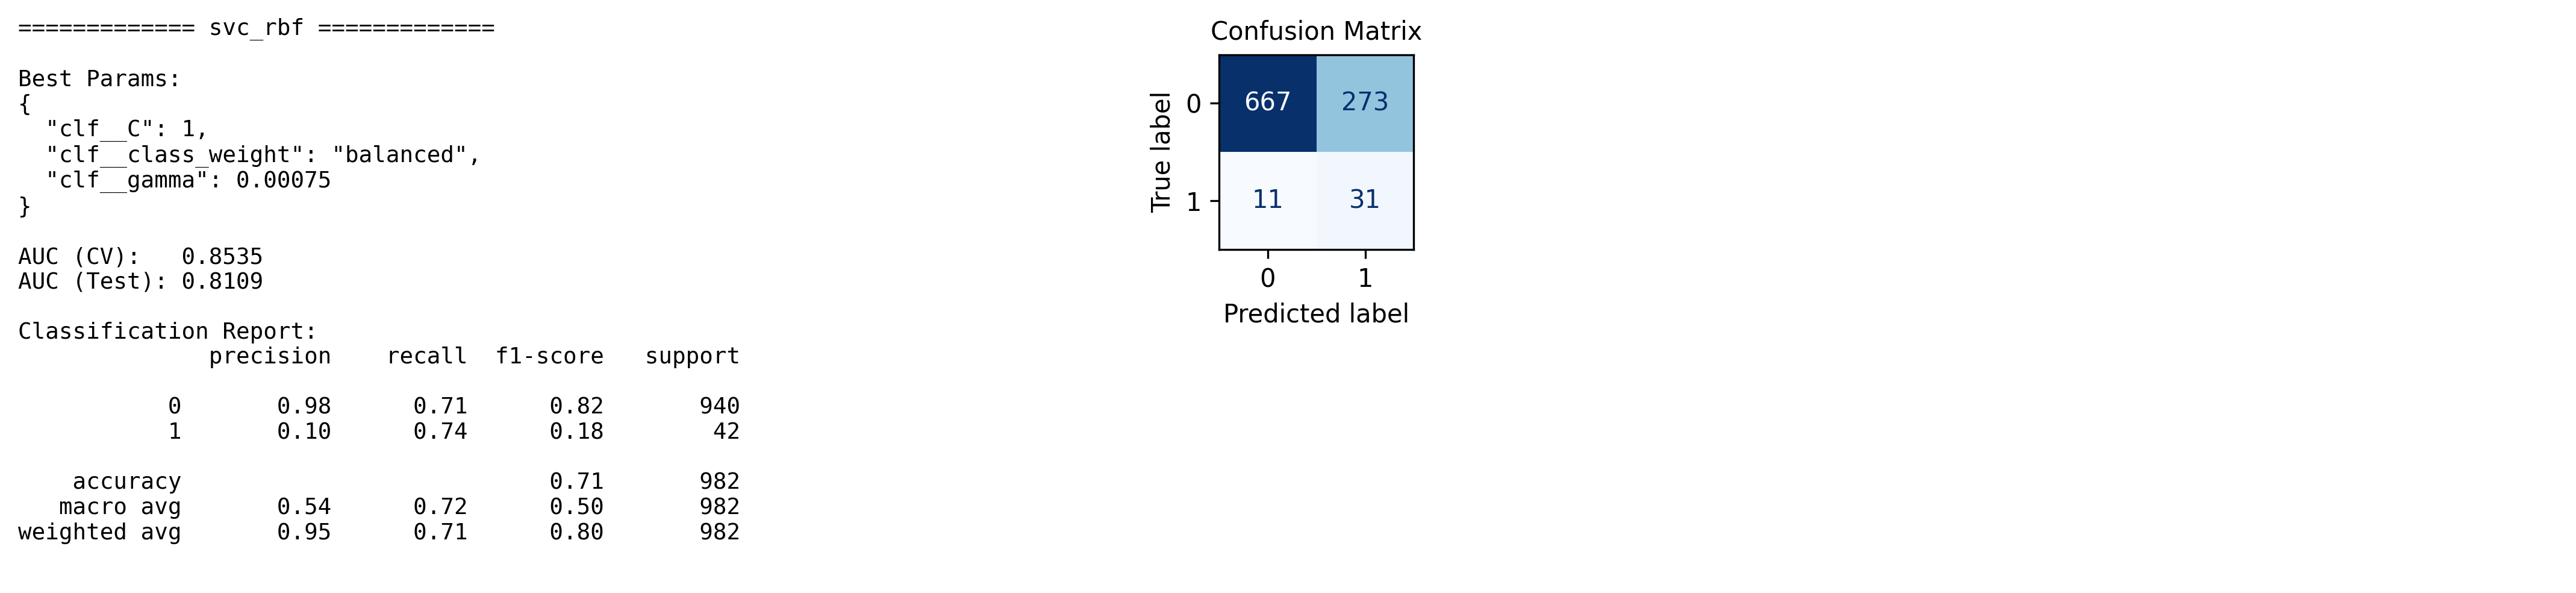

In [60]:
# Run Models v2
results = run_multiple_models(models, param_grids, preprocessor,
                            X_train, y_train, X_test, y_test, scoring='roc_auc')

In [61]:
# Model v3
#Fine tune some paramters

pp.pprint(param_grids)

{'gb_clf': {'clf__learning_rate': [0.01, 0.005, 0.001],
            'clf__max_depth': [1, 2, 3, 4],
            'clf__min_samples_leaf': [1, 2, 4],
            'clf__min_samples_split': [4, 5, 6],
            'clf__n_estimators': [100, 200, 300]},
 'log_reg': {'clf__C': [0.01, 0.1, 1, 10],
             'clf__class_weight': ['balanced'],
             'clf__penalty': ['l2']},
 'rf_clf': {'clf__class_weight': ['balanced'],
            'clf__max_depth': [None, 10, 20],
            'clf__max_features': ['sqrt', 'log2'],
            'clf__min_samples_split': [8, 10, 15, 20],
            'clf__n_estimators': [500, 700, 900]},
 'svc_rbf': {'clf__C': [0.5, 1, 2, 5, 7],
             'clf__class_weight': ['balanced'],
             'clf__gamma': [0.01, 0.005, 0.002, 0.001, 0.00075]}}


In [63]:
param_grids['log_reg']['clf__class_weight']=['balanced']
param_grids['log_reg']['clf__C']=[.005, .0075, .01, .02, .03, .05 ]

param_grids['rf_clf']['clf__n_estimators']=[450, 500, 550]
param_grids['rf_clf']['clf__min_samples_split']=[20, 25, 30]

param_grids['gb_clf']['clf__n_estimators']=[75, 100, 125, 150]
param_grids['gb_clf']['clf__learning_rate']=[.009, .01, .02]
param_grids['gb_clf']['clf__max_depth']=[3]
param_grids['gb_clf']['clf__min_samples_split']=[5]

param_grids['svc_rbf']['clf__C']=[.9,1, 1.1, 1.2]
param_grids['svc_rbf']['clf__class_weight']=['balanced']
param_grids['svc_rbf']['clf__gamma']=[.0009, .00075, .0005, .00025, .0001]

#pp.pprint(param_grids)



===== Training log_reg =====

Fitting 5 folds for each of 6 candidates, totalling 30 fits


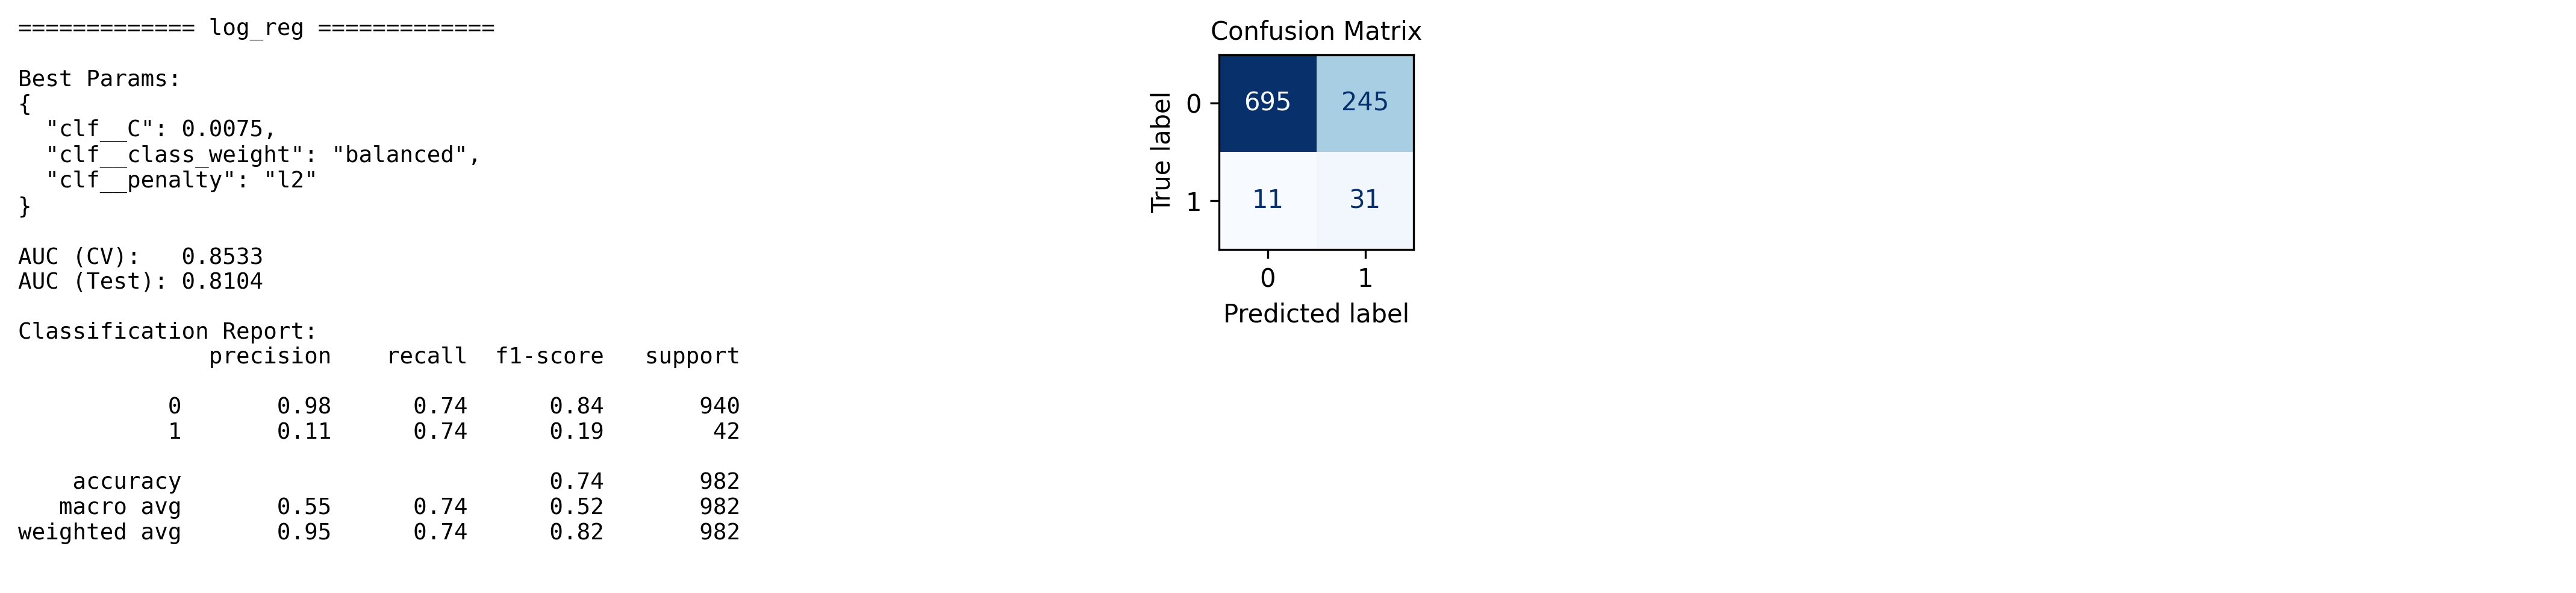


===== Training rf_clf =====

Fitting 5 folds for each of 54 candidates, totalling 270 fits


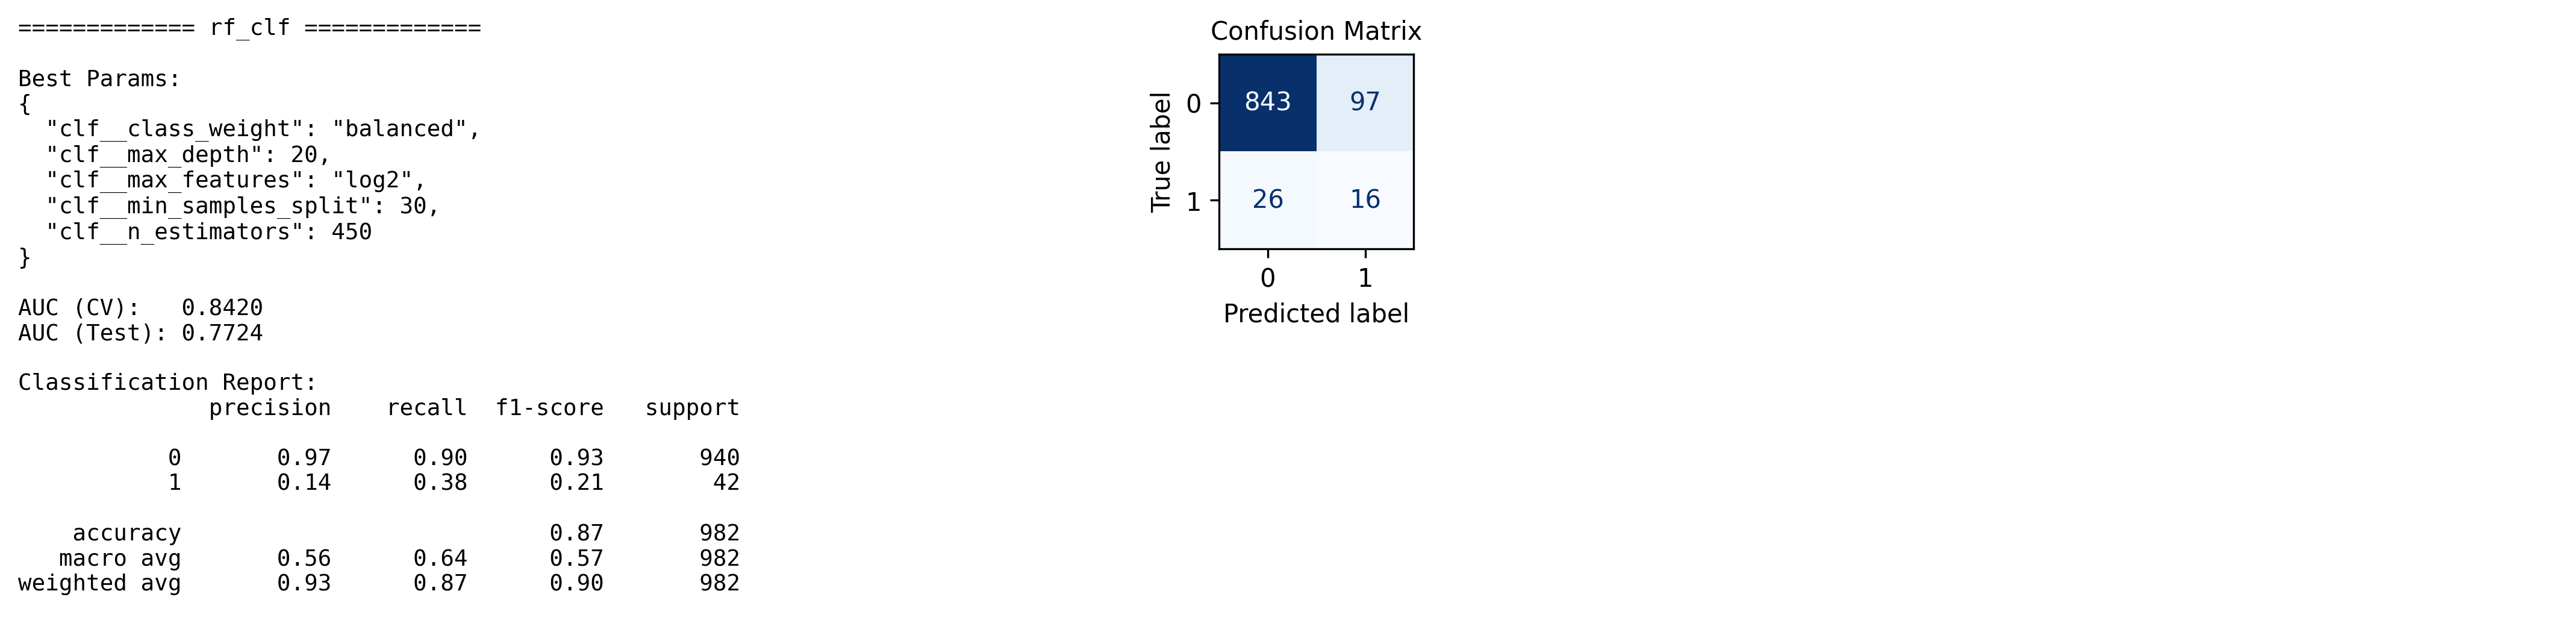


===== Training gb_clf =====

Fitting 5 folds for each of 36 candidates, totalling 180 fits


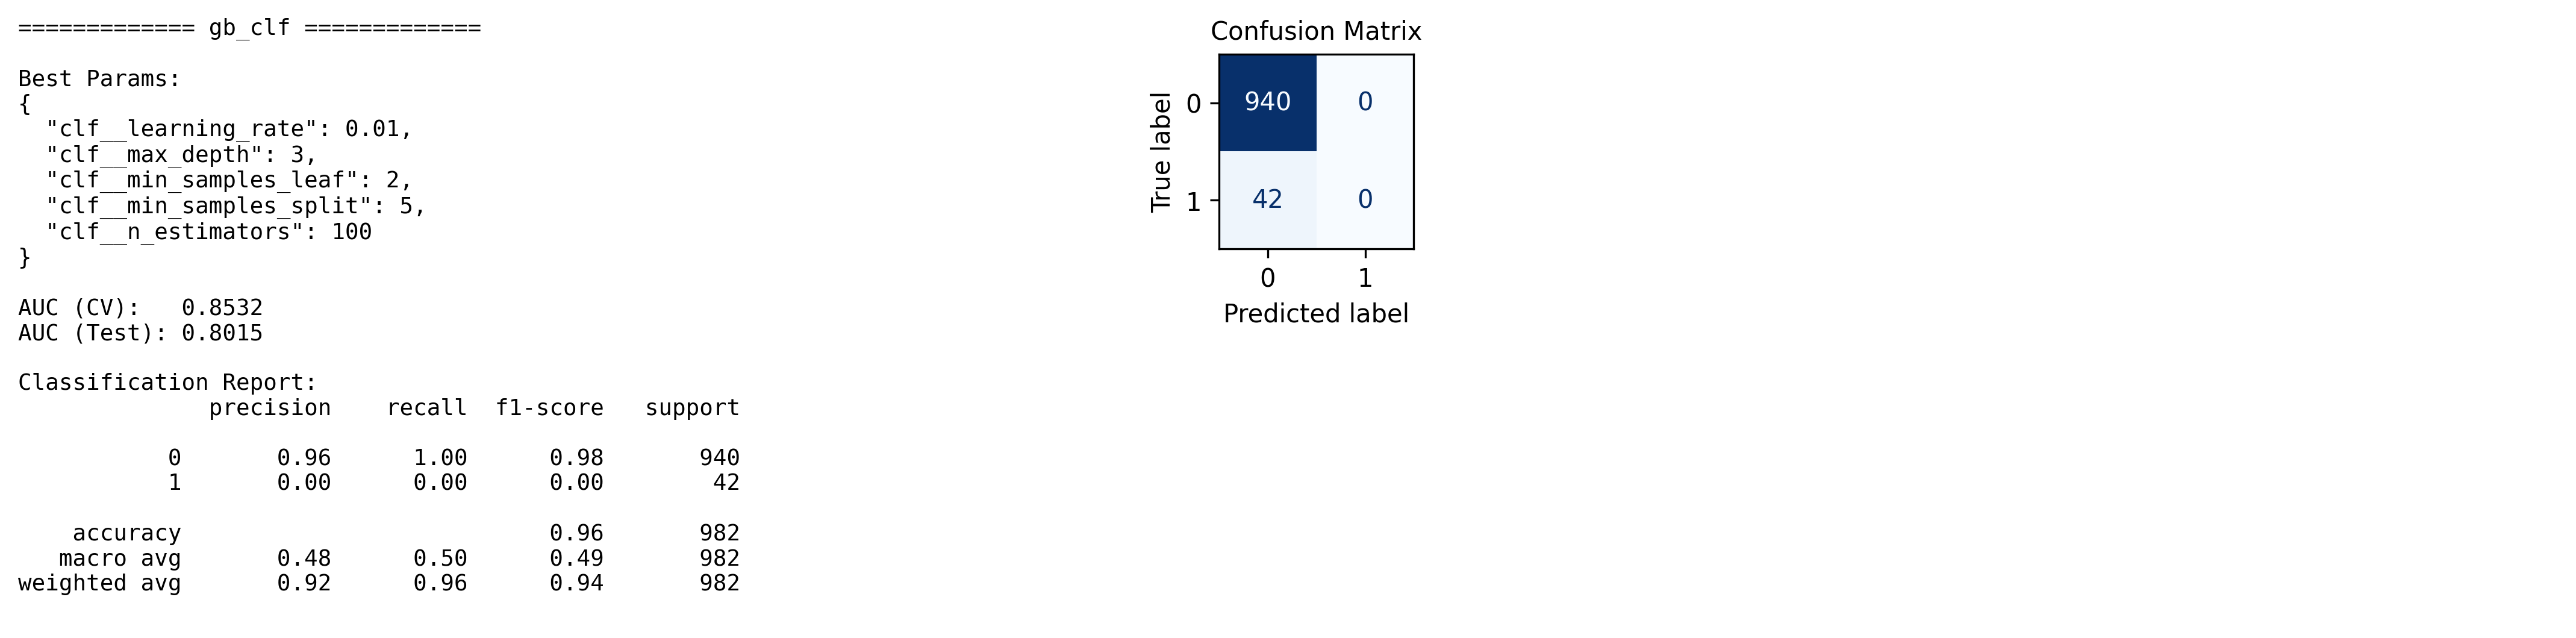


===== Training svc_rbf =====

Fitting 5 folds for each of 20 candidates, totalling 100 fits


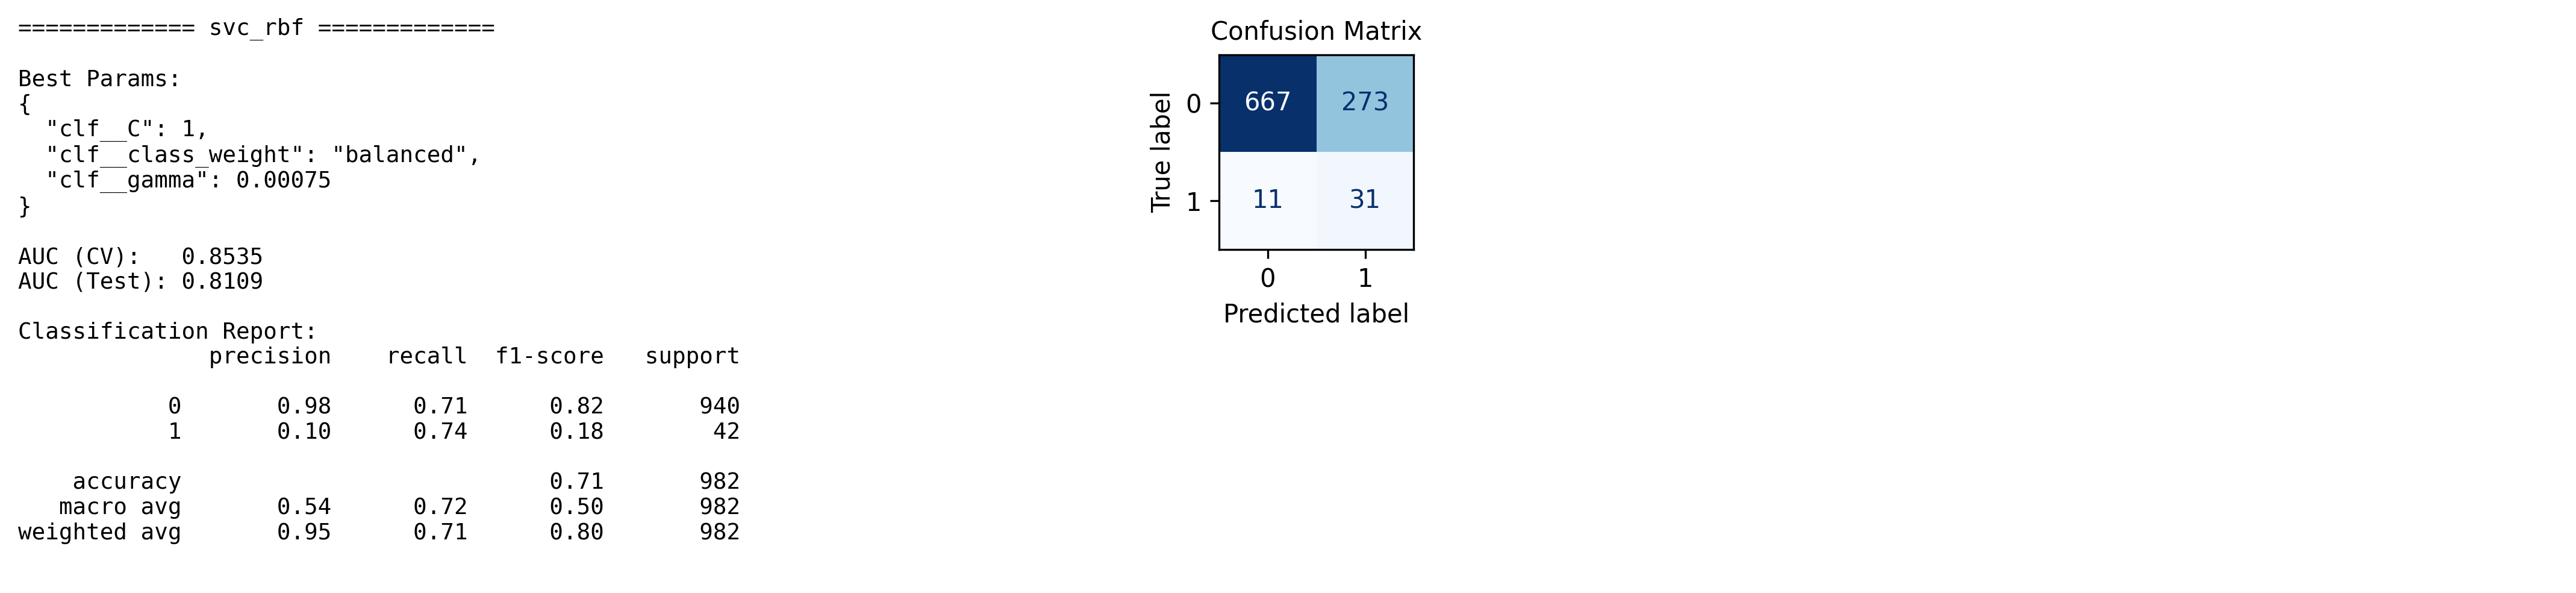

In [70]:
# Run Models v3
results = run_multiple_models(models, param_grids, preprocessor,
                            X_train, y_train, X_test, y_test, scoring='roc_auc')


### Observations

Gradient boosting is not able to perform well with the imbalance of the target class. 

---
# Threshold Tuning

Select 2 best models, and perform threshold tuning.

- Random Forest
- SVC
  

### Linear Regression Threshold tuning

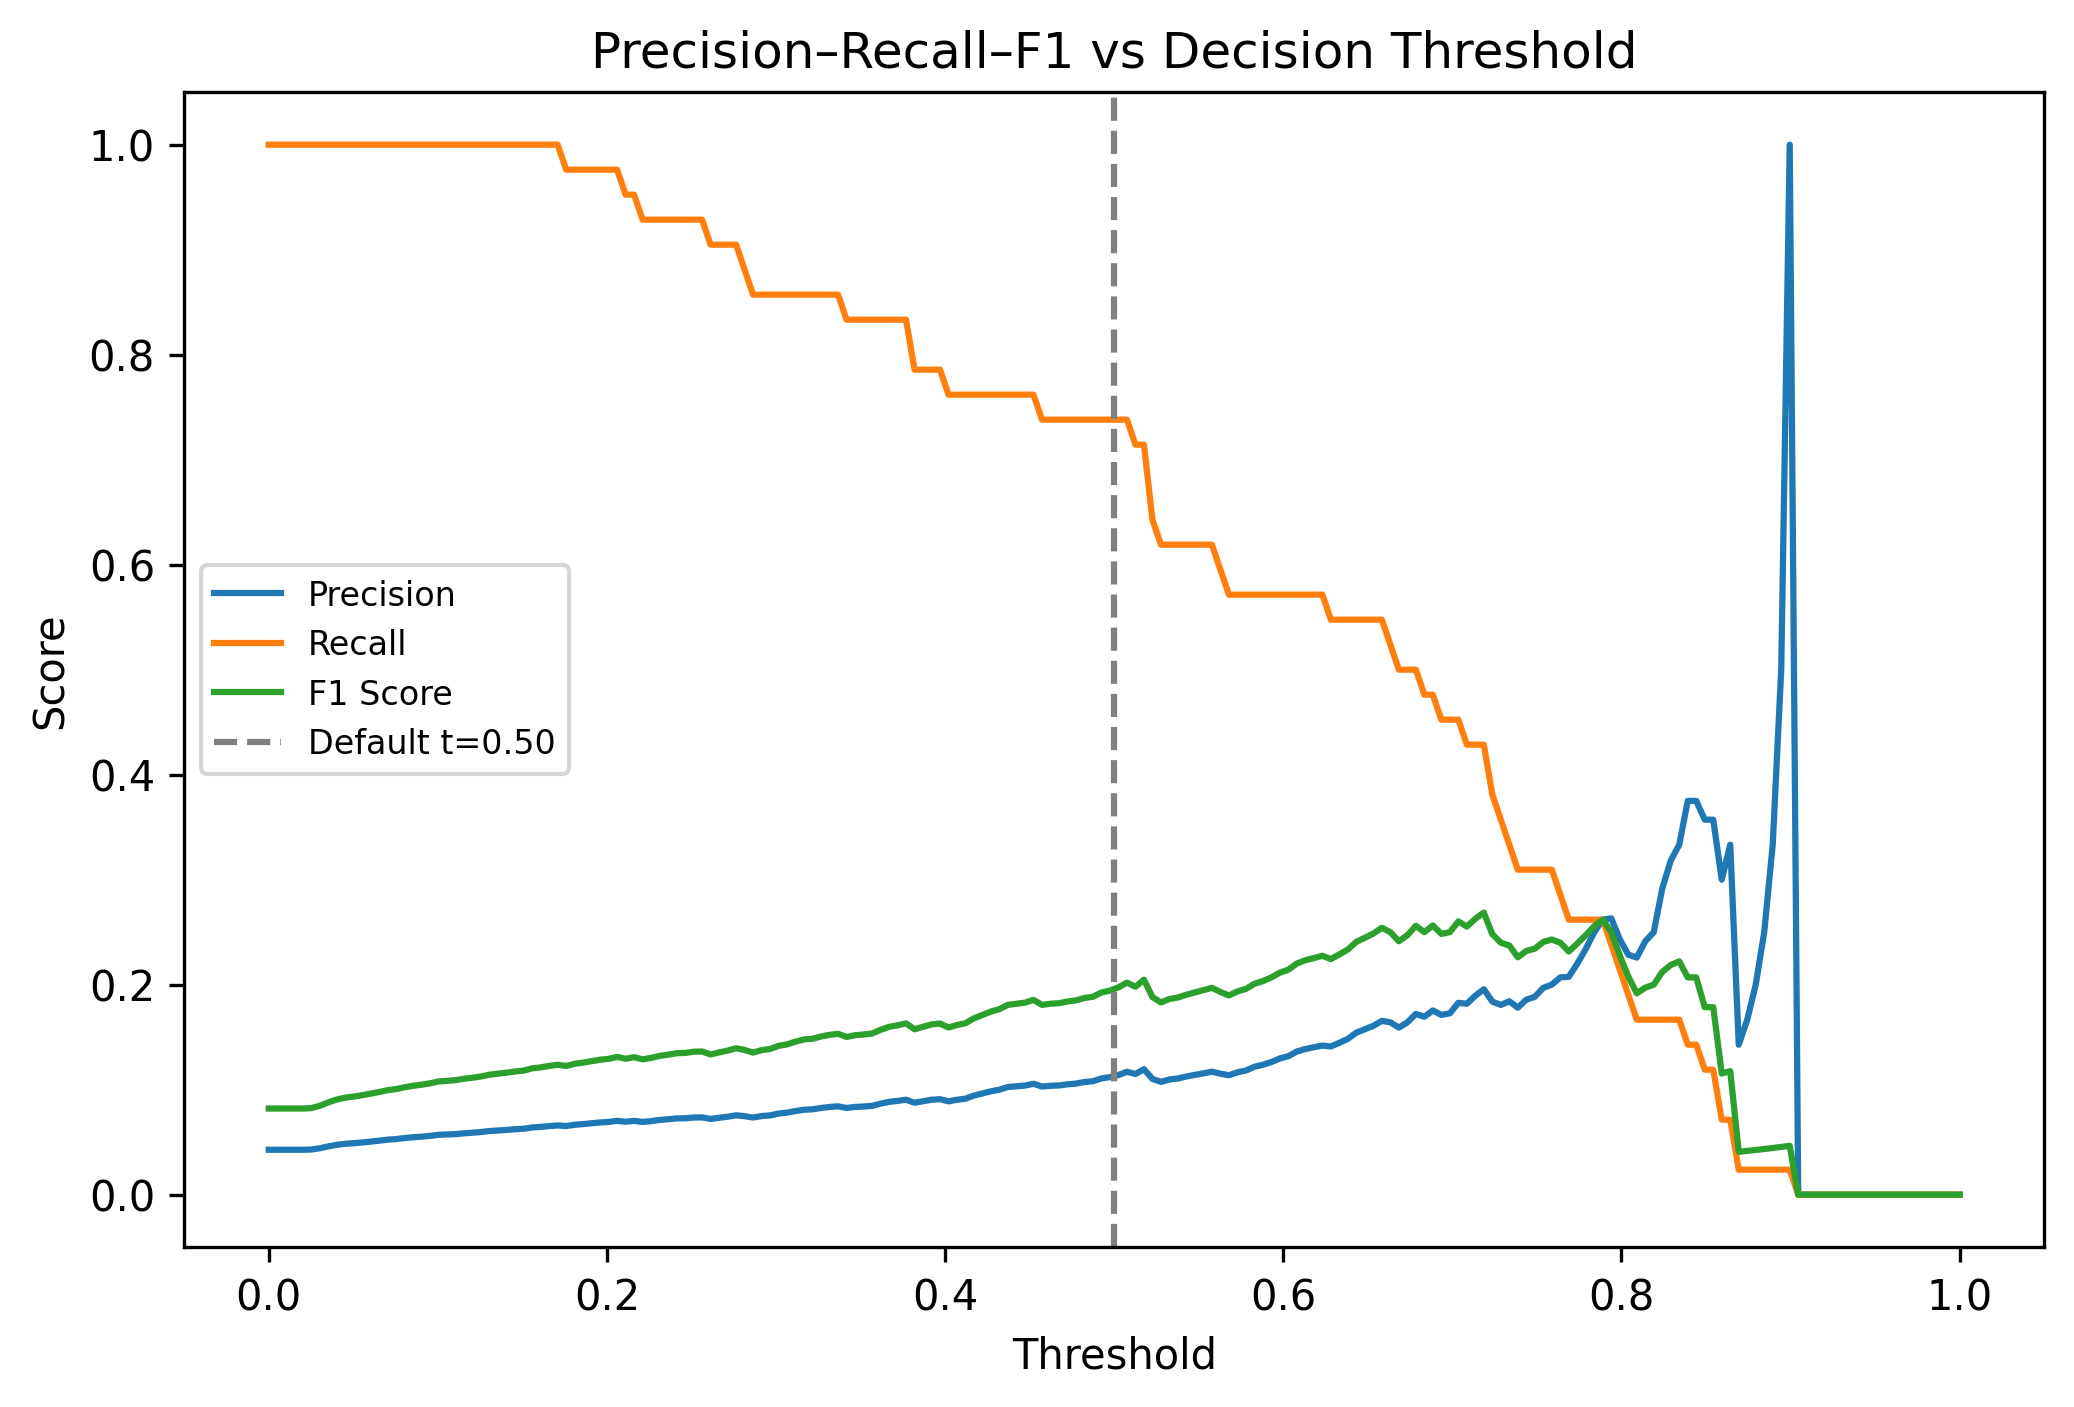

In [103]:
# Tune LinearRegression
best_lr = results['log_reg']['best_model']
y_proba = best_lr.predict_proba(X_test)[:, 1]
threshold_curve(y_test, y_proba)


In [104]:
# Maximize F1
t_f1, score_f1 = find_best_threshold(y_test, y_proba, beta=1)

print("Best threshold (F1):", t_f1)
print("Best F1 score:", score_f1)
print("")

# Maximize recall-heavy score (F2)
t_f2, score_f2 = find_best_threshold(y_test, y_proba, beta=2)

print("Best threshold (F2):", t_f2)
print("Best F2 score:", score_f2)
print("")


# Maximize recall-heavy score (F3)
t_f3, score_f3 = find_best_threshold(y_test, y_proba, beta=3)

print("Best threshold (F3):", t_f3)
print("Best F3 score:", score_f3)

Best threshold (F1): 0.7185929648241206
Best F1 score: 0.26865671641791045

Best threshold (F2): 0.6582914572864321
Best F2 score: 0.3745928338762215

Best threshold (F3): 0.507537688442211
Best F3 score: 0.4821150855365474


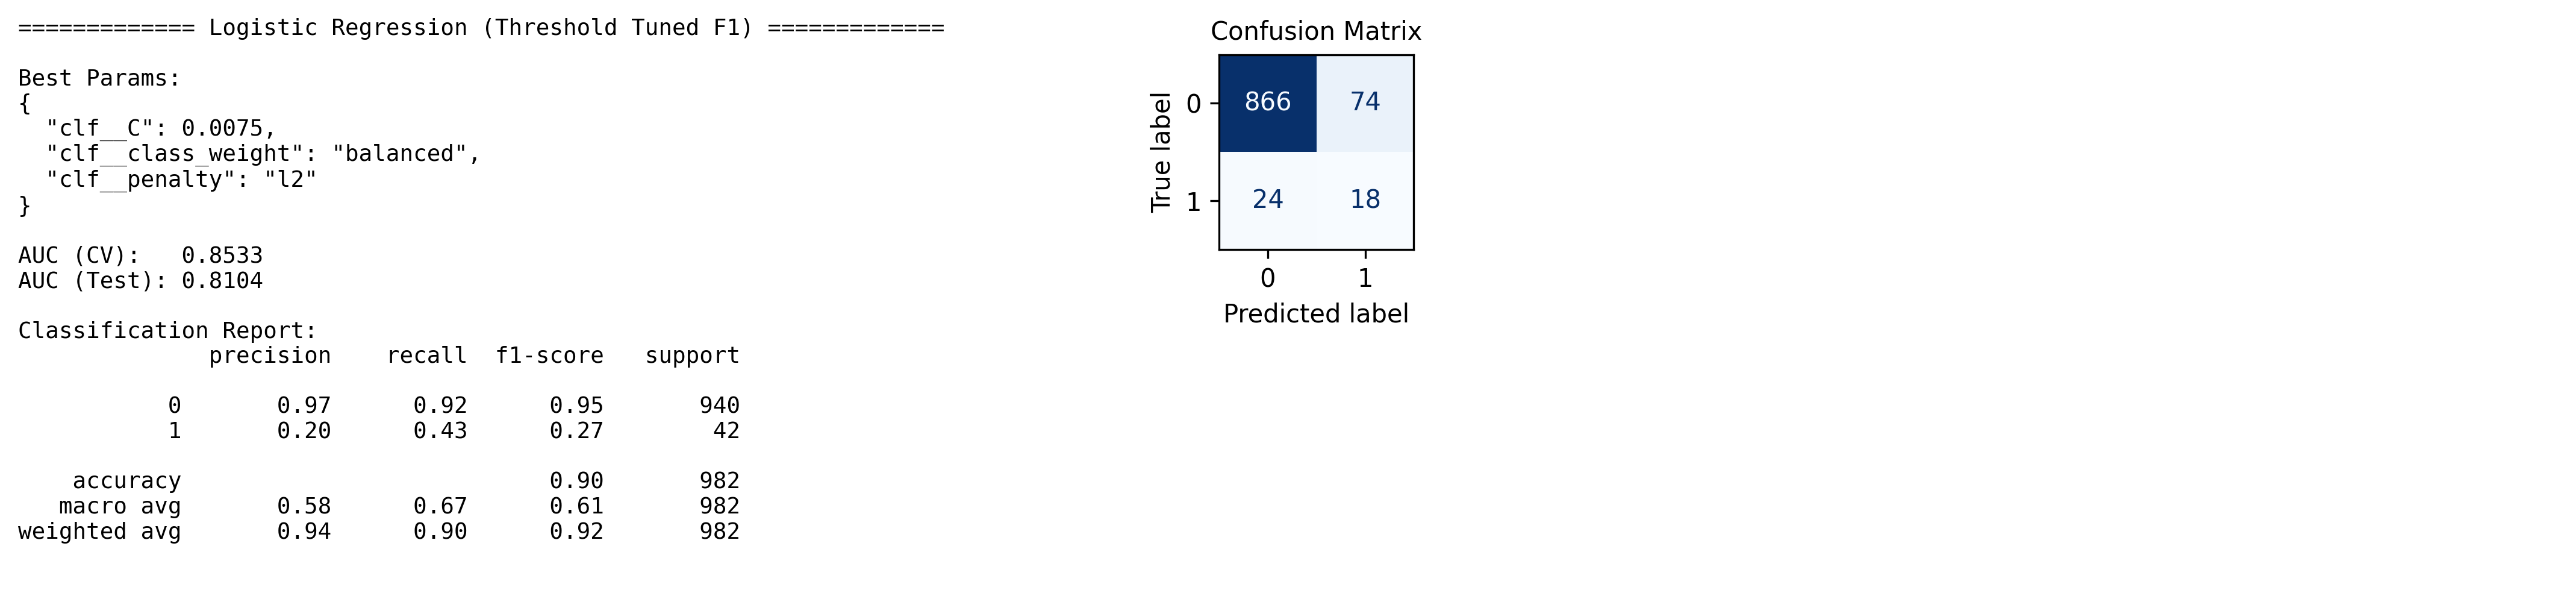

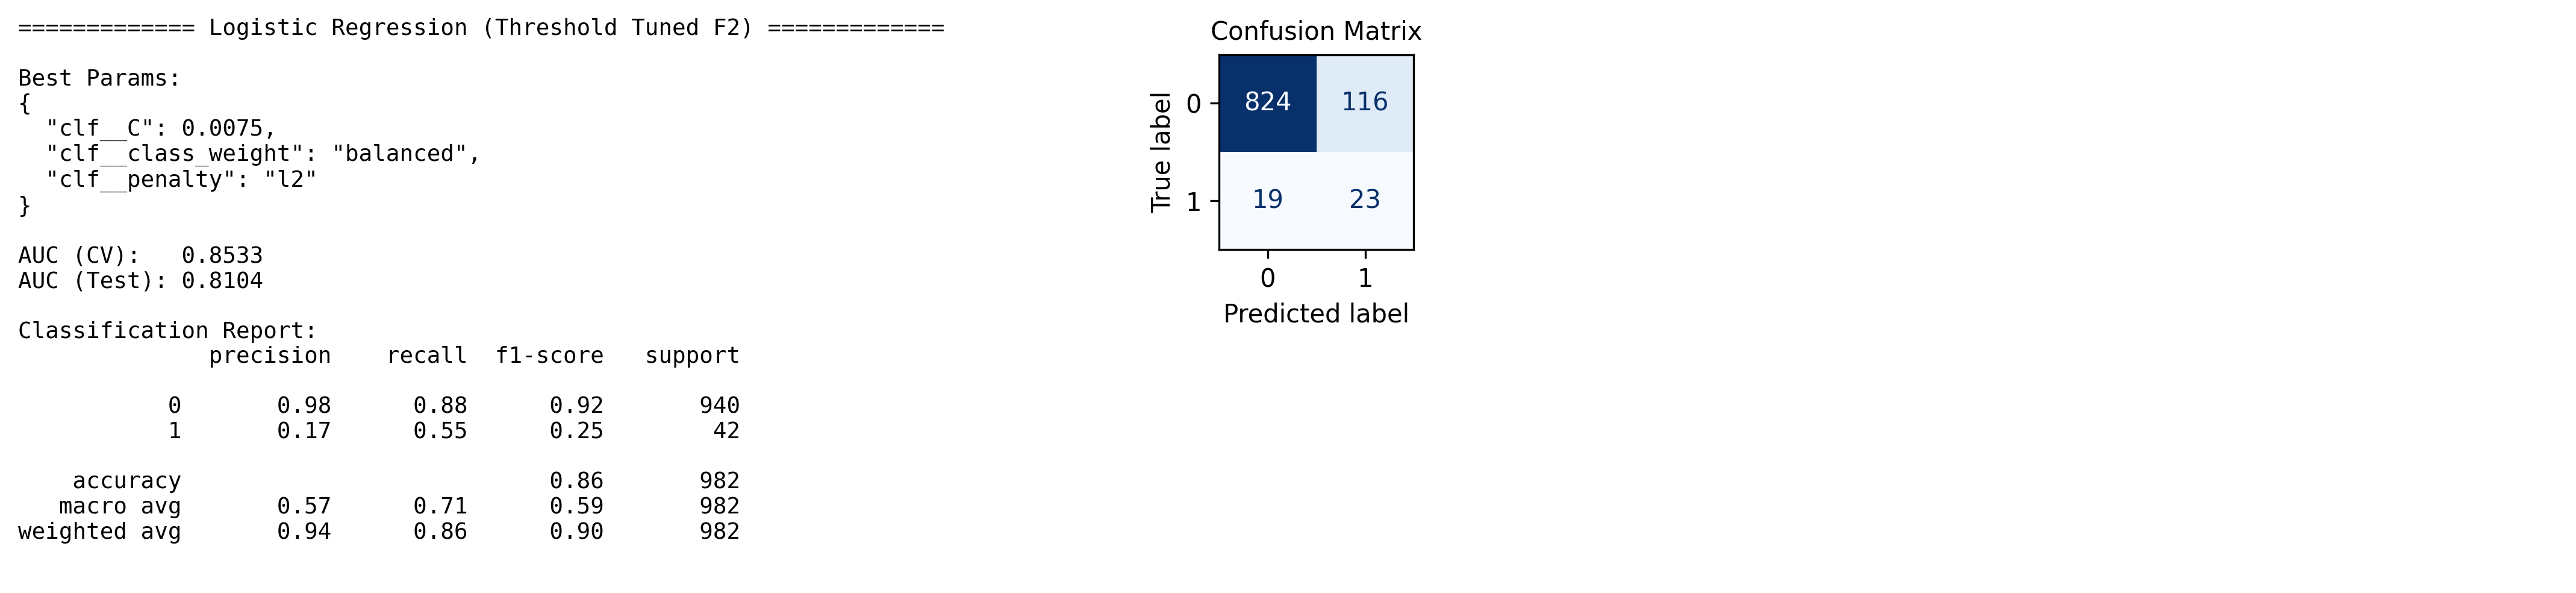

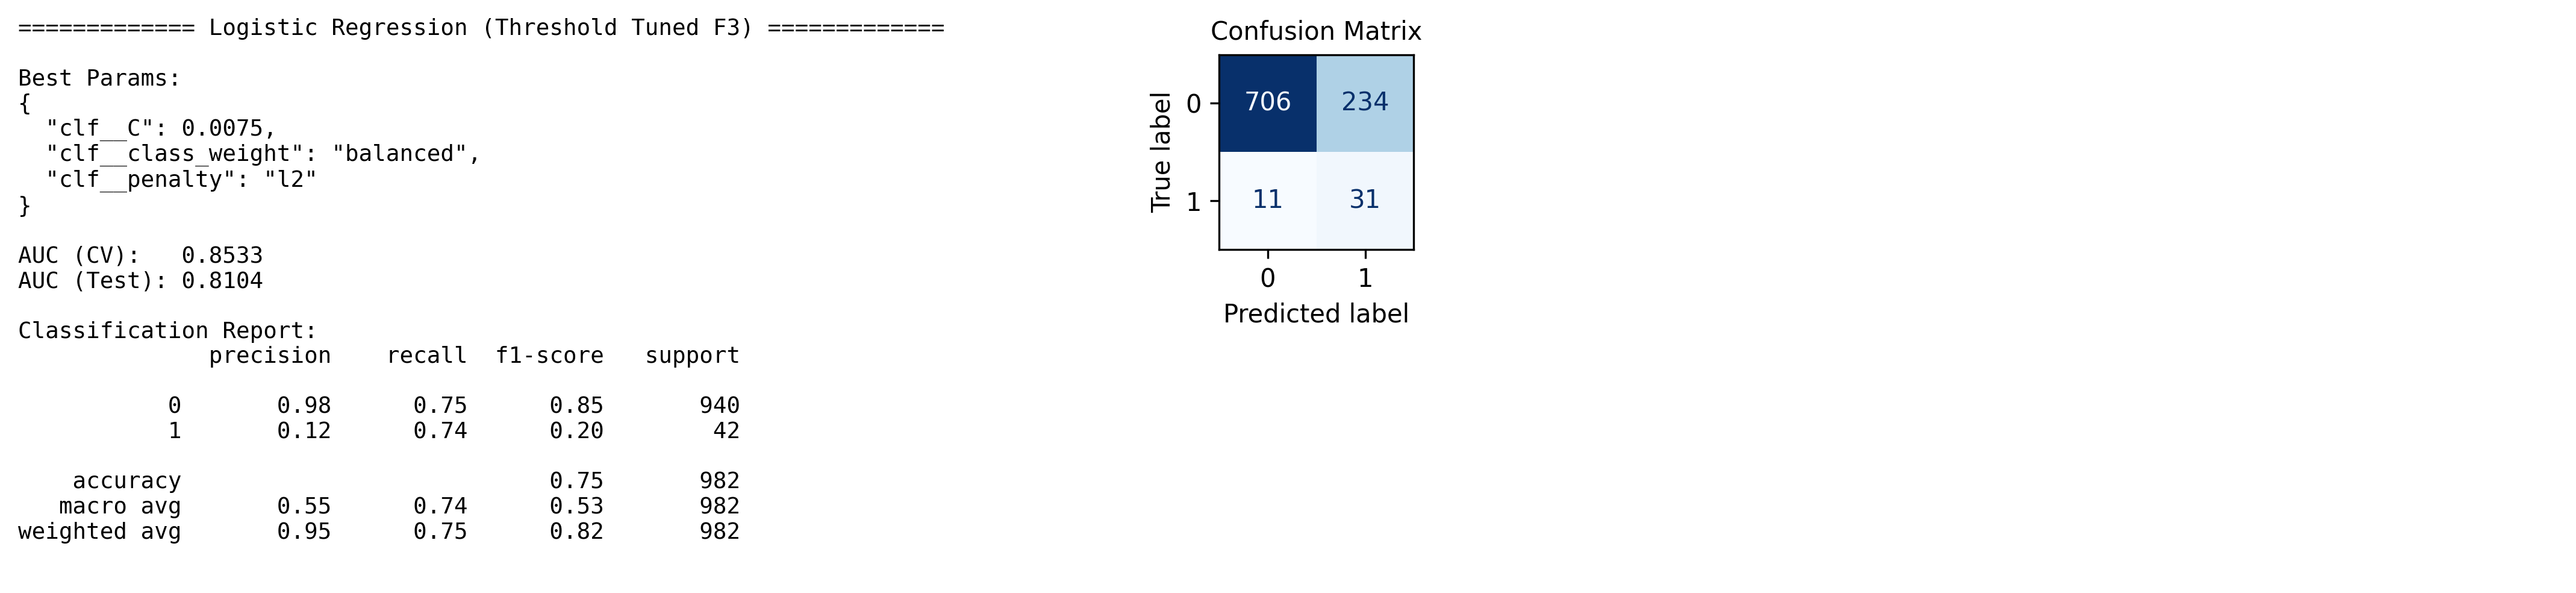

In [105]:
# Evaluate at F1
lr_th_metrics_f1 = eval_at_threshold(y_test, y_proba, threshold=t_f1, beta=1)

display_model_results(
    name="Logistic Regression (Threshold Tuned F1)",
    grid=results['log_reg']['grid'],
    metrics=lr_th_metrics_f1,
    cm=lr_th_metrics_f1['confusion_matrix'],
    best_model=best_gb
)

# Evaluate at F2
lr_th_metrics_f2 = eval_at_threshold(y_test, y_proba, threshold=t_f2, beta=2)

display_model_results(
    name="Logistic Regression (Threshold Tuned F2)",
    grid=results['log_reg']['grid'],
    metrics=lr_th_metrics_f2,
    cm=lr_th_metrics_f2['confusion_matrix'],
    best_model=best_gb
)

# Evaluate at F3
lr_th_metrics_f3 = eval_at_threshold(y_test, y_proba, threshold=t_f3, beta=3)

display_model_results(
    name="Logistic Regression (Threshold Tuned F3)",
    grid=results['log_reg']['grid'],
    metrics=lr_th_metrics_f3,
    cm=lr_th_metrics_f3['confusion_matrix'],
    best_model=best_gb
)


### Gradient Boosting Threshold tuning

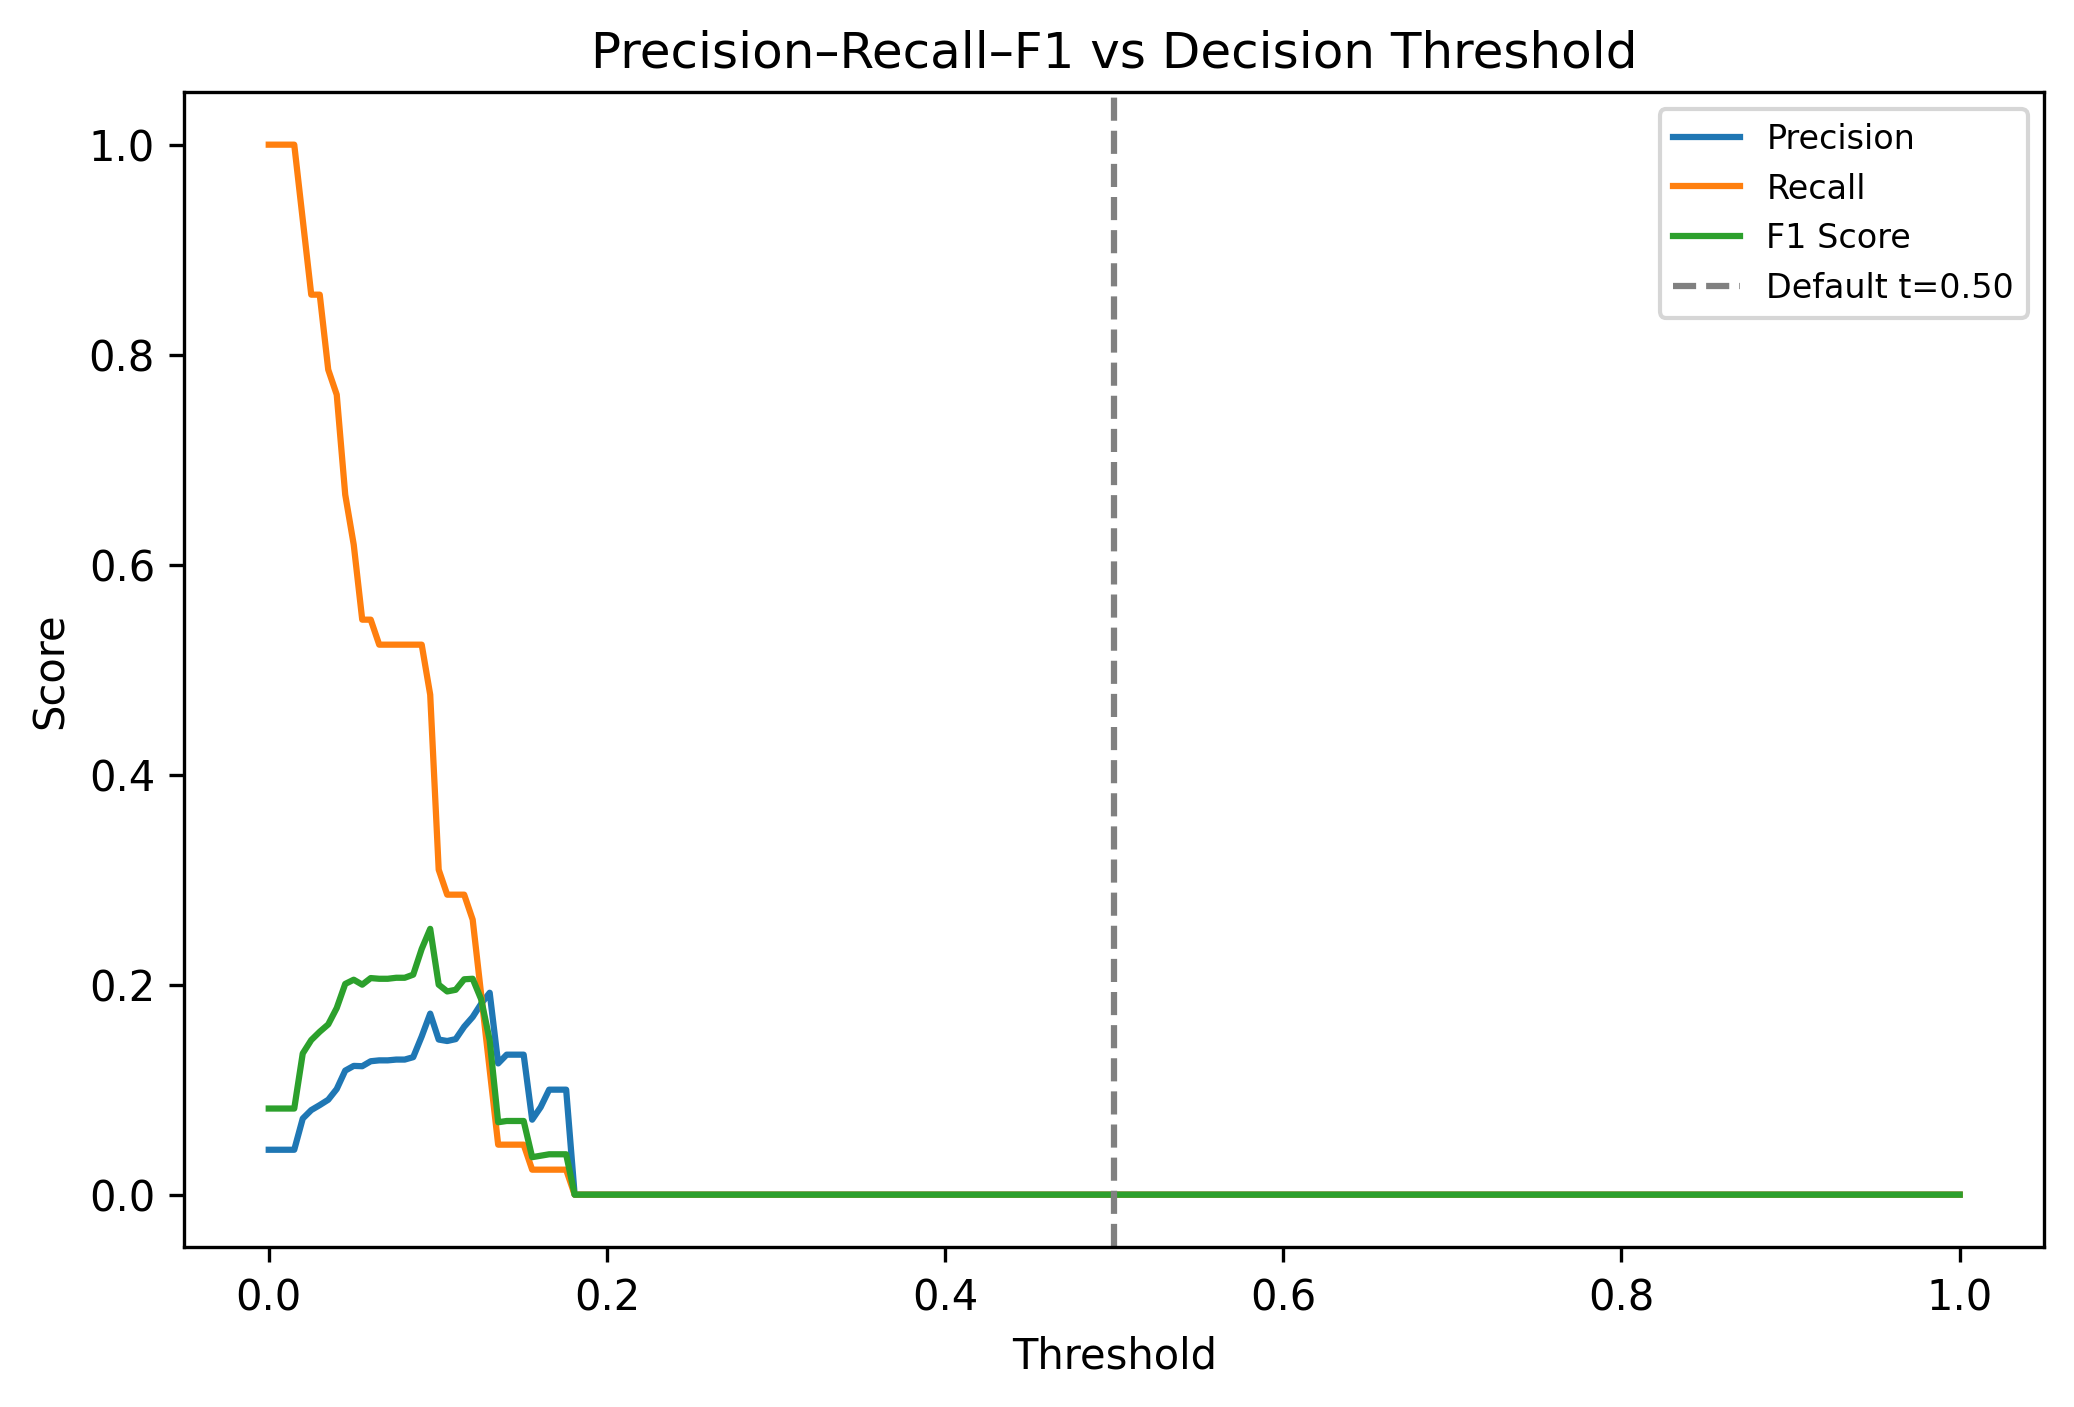

In [85]:
# Tune GradientBoosting
best_gb = results['gb_clf']['best_model']
y_proba = best_gb.predict_proba(X_test)[:, 1]
threshold_curve(y_test, y_proba)

In [86]:
# Maximize F1
t_f1, score_f1 = find_best_threshold(y_test, y_proba, beta=1)

print("Best threshold (F1):", t_f1)
print("Best F1 score:", score_f1)
print("")

# Maximize recall-heavy score (F2)
t_f2, score_f2 = find_best_threshold(y_test, y_proba, beta=2)

print("Best threshold (F2):", t_f2)
print("Best F2 score:", score_f2)
print("")


# Maximize recall-heavy score (F3)
t_f3, score_f3 = find_best_threshold(y_test, y_proba, beta=3)

print("Best threshold (F3):", t_f3)
print("Best F3 score:", score_f3)

Best threshold (F1): 0.09547738693467336
Best F1 score: 0.25316455696202533

Best threshold (F2): 0.09547738693467336
Best F2 score: 0.352112676056338

Best threshold (F3): 0.04020100502512563
Best F3 score: 0.45977011494252873


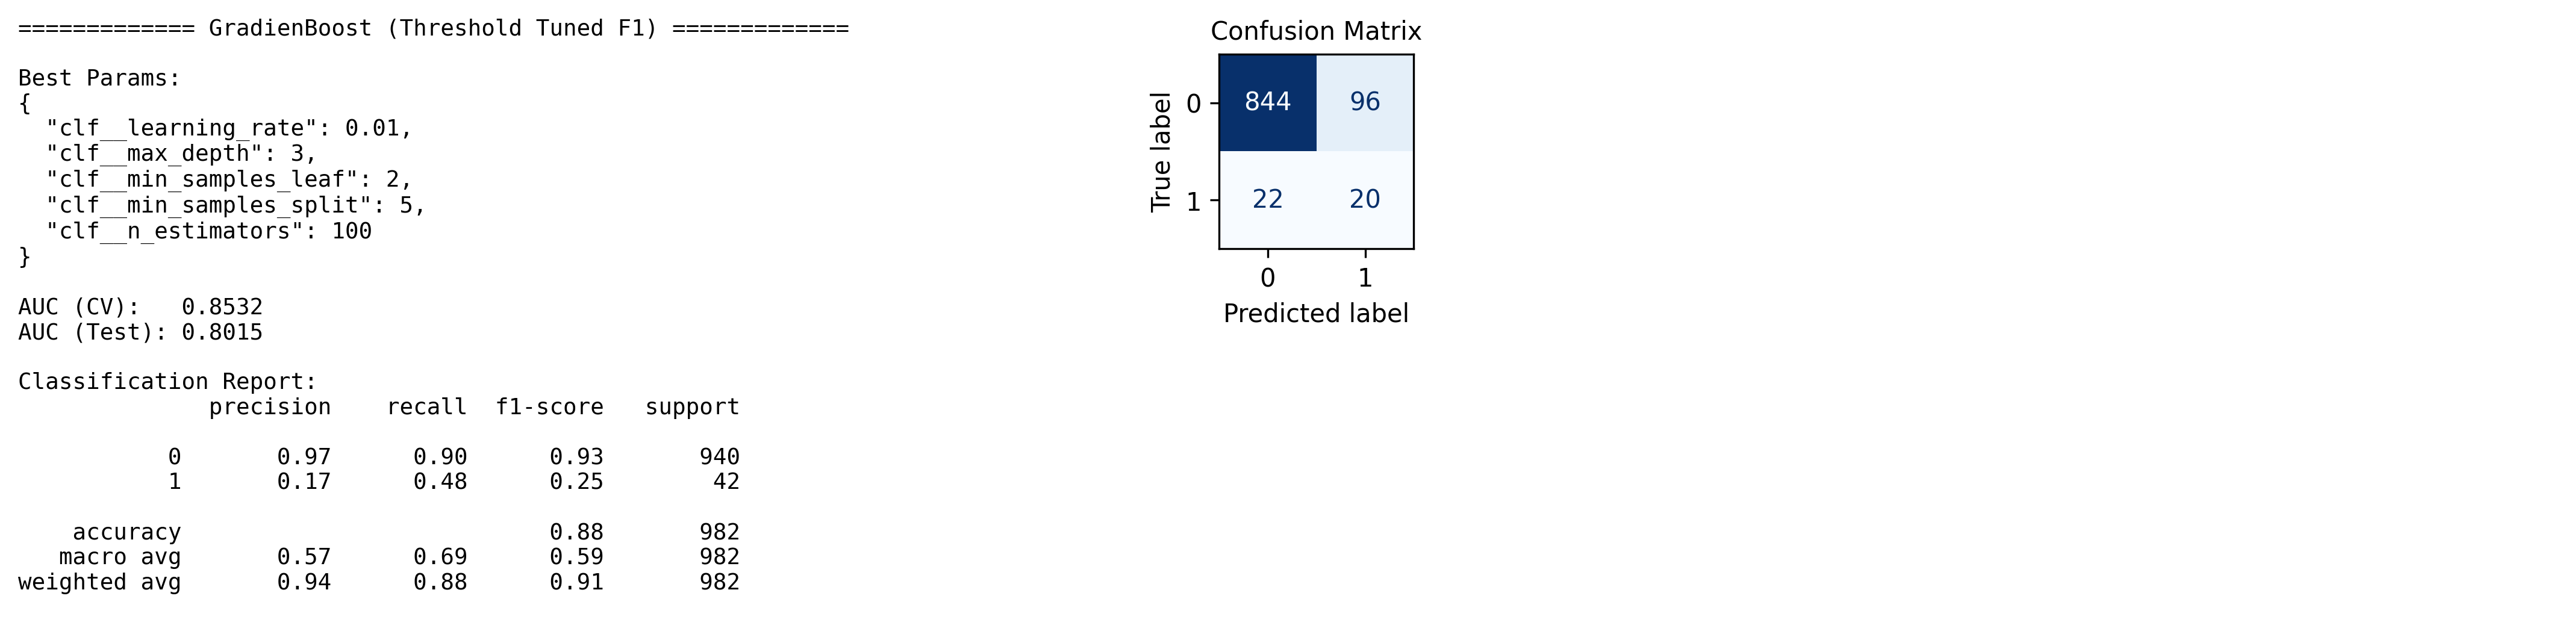

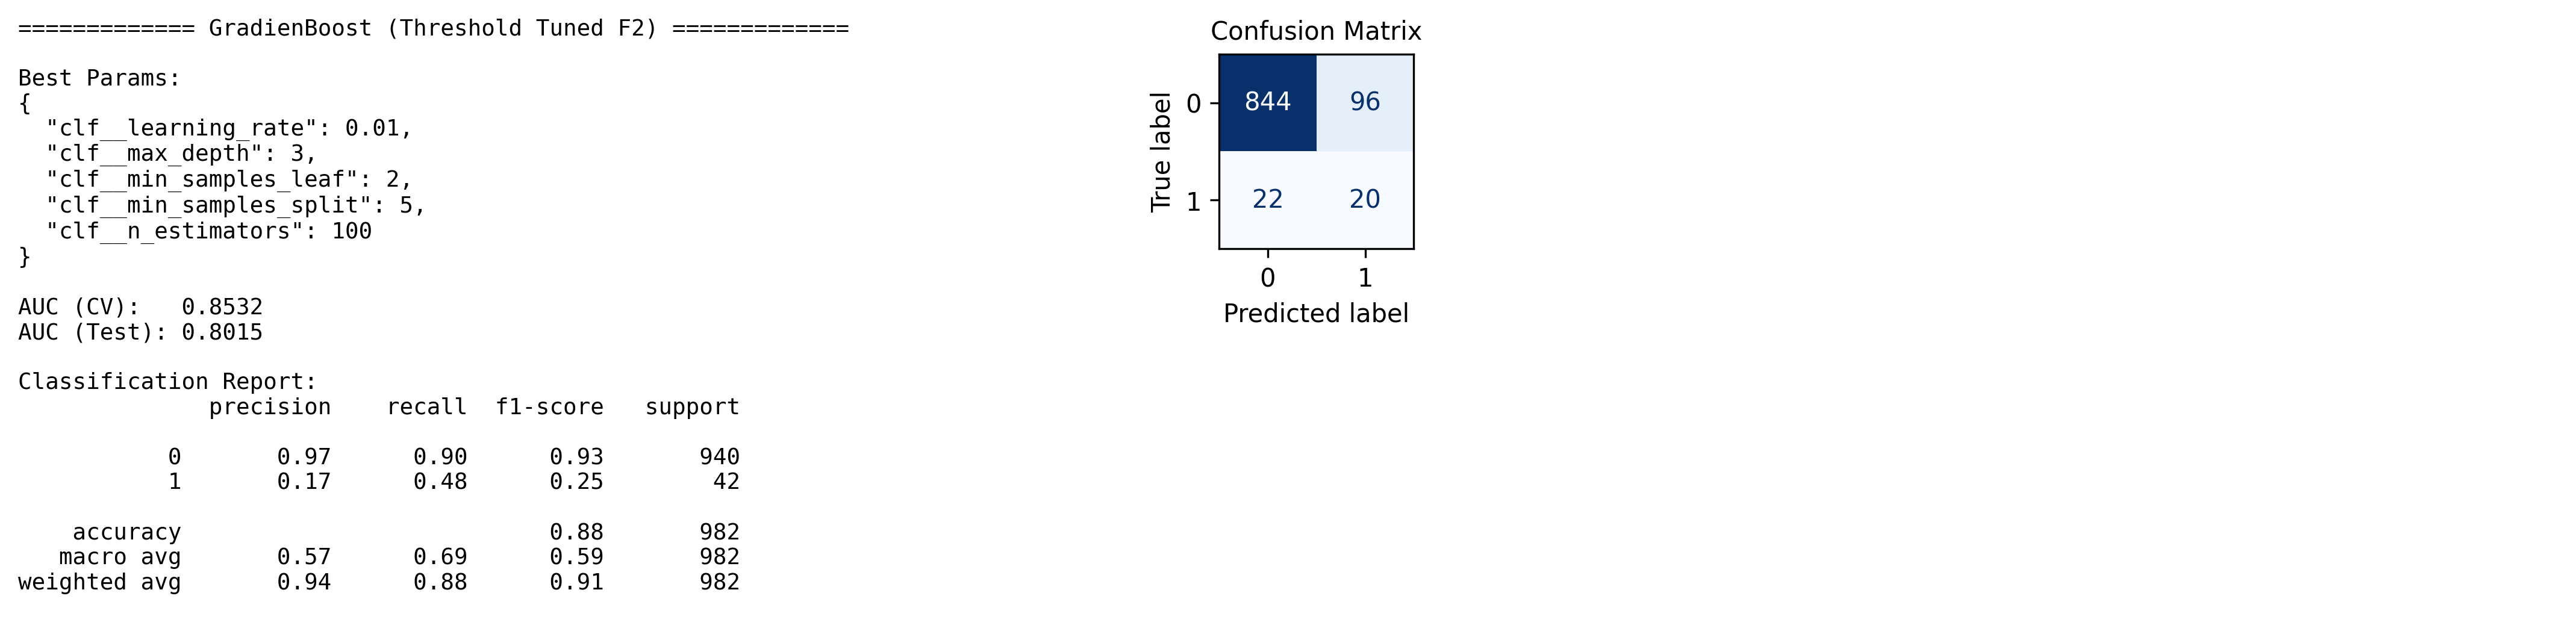

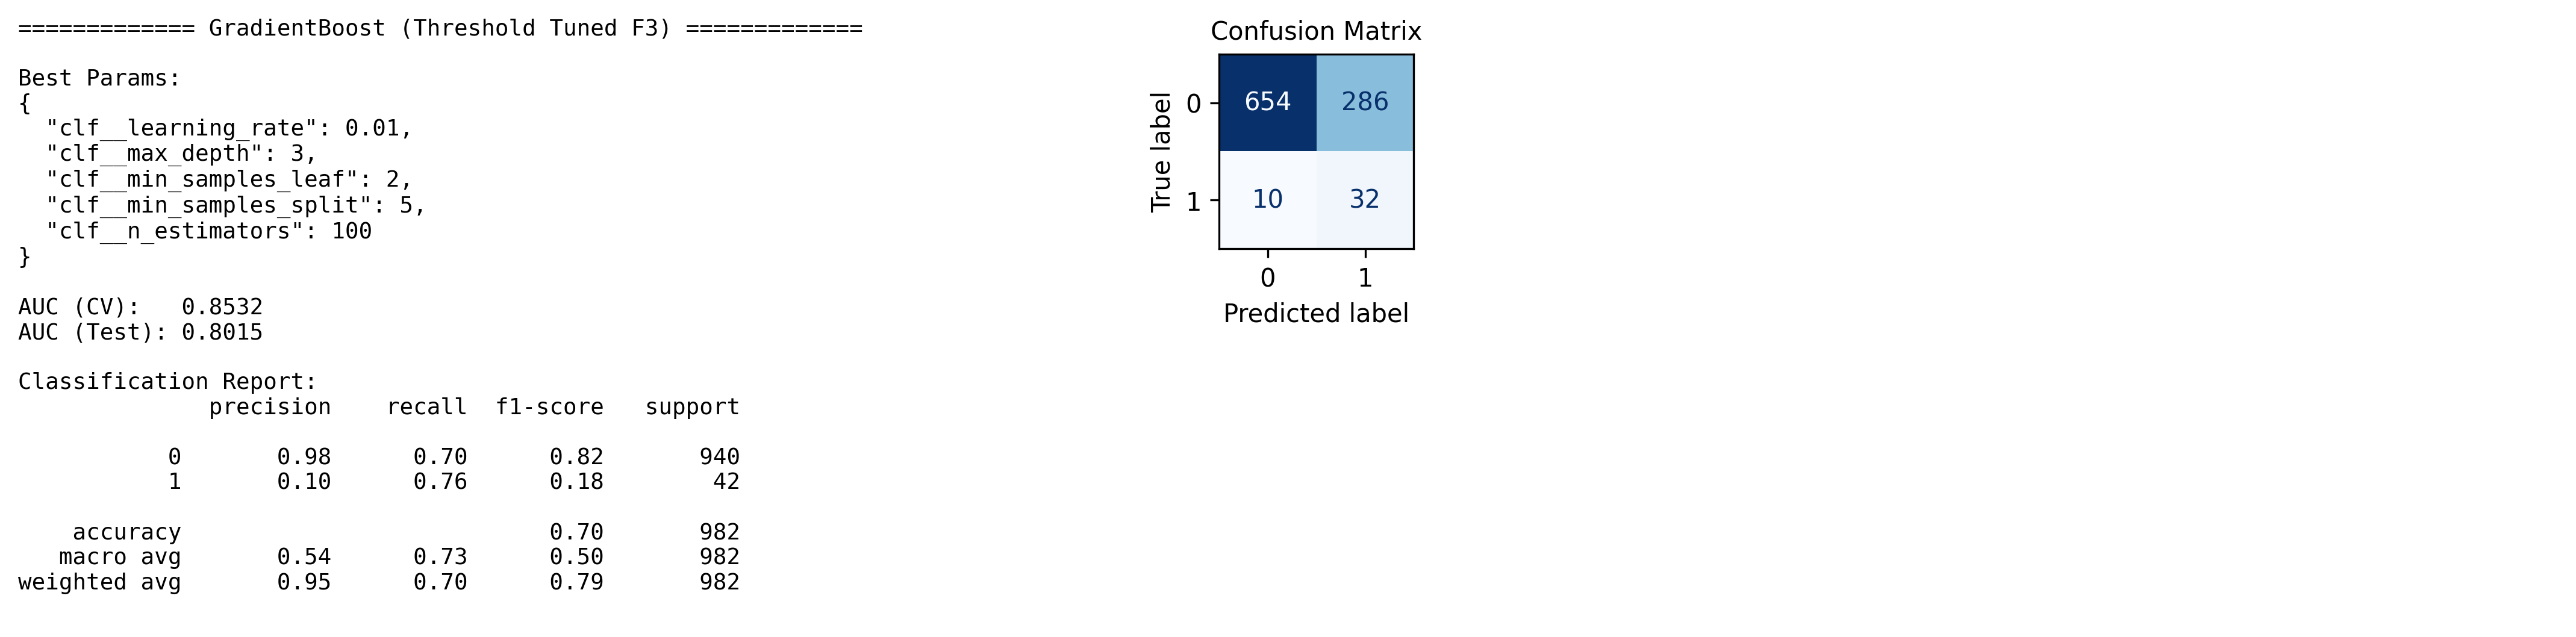

In [87]:
# Evaluate at F1
gb_th_metrics_f1 = eval_at_threshold(y_test, y_proba, threshold=t_f1, beta=1)

display_model_results(
    name="GradienBoost (Threshold Tuned F1)",
    grid=results['gb_clf']['grid'],
    metrics=gb_th_metrics_f1,
    cm=gb_th_metrics_f1['confusion_matrix'],
    best_model=best_gb
)

# Evaluate at F2
gb_th_metrics_f2 = eval_at_threshold(y_test, y_proba, threshold=t_f2, beta=2)

display_model_results(
    name="GradienBoost (Threshold Tuned F2)",
    grid=results['gb_clf']['grid'],
    metrics=gb_th_metrics_f2,
    cm=gb_th_metrics_f2['confusion_matrix'],
    best_model=best_gb
)

# Evaluate at F3
gb_th_metrics_f3 = eval_at_threshold(y_test, y_proba, threshold=t_f3, beta=3)

display_model_results(
    name="GradientBoost (Threshold Tuned F3)",
    grid=results['gb_clf']['grid'],
    metrics=gb_th_metrics_f3,
    cm=gb_th_metrics_f3['confusion_matrix'],
    best_model=best_gb
)

### Random Forest Threshold tuning

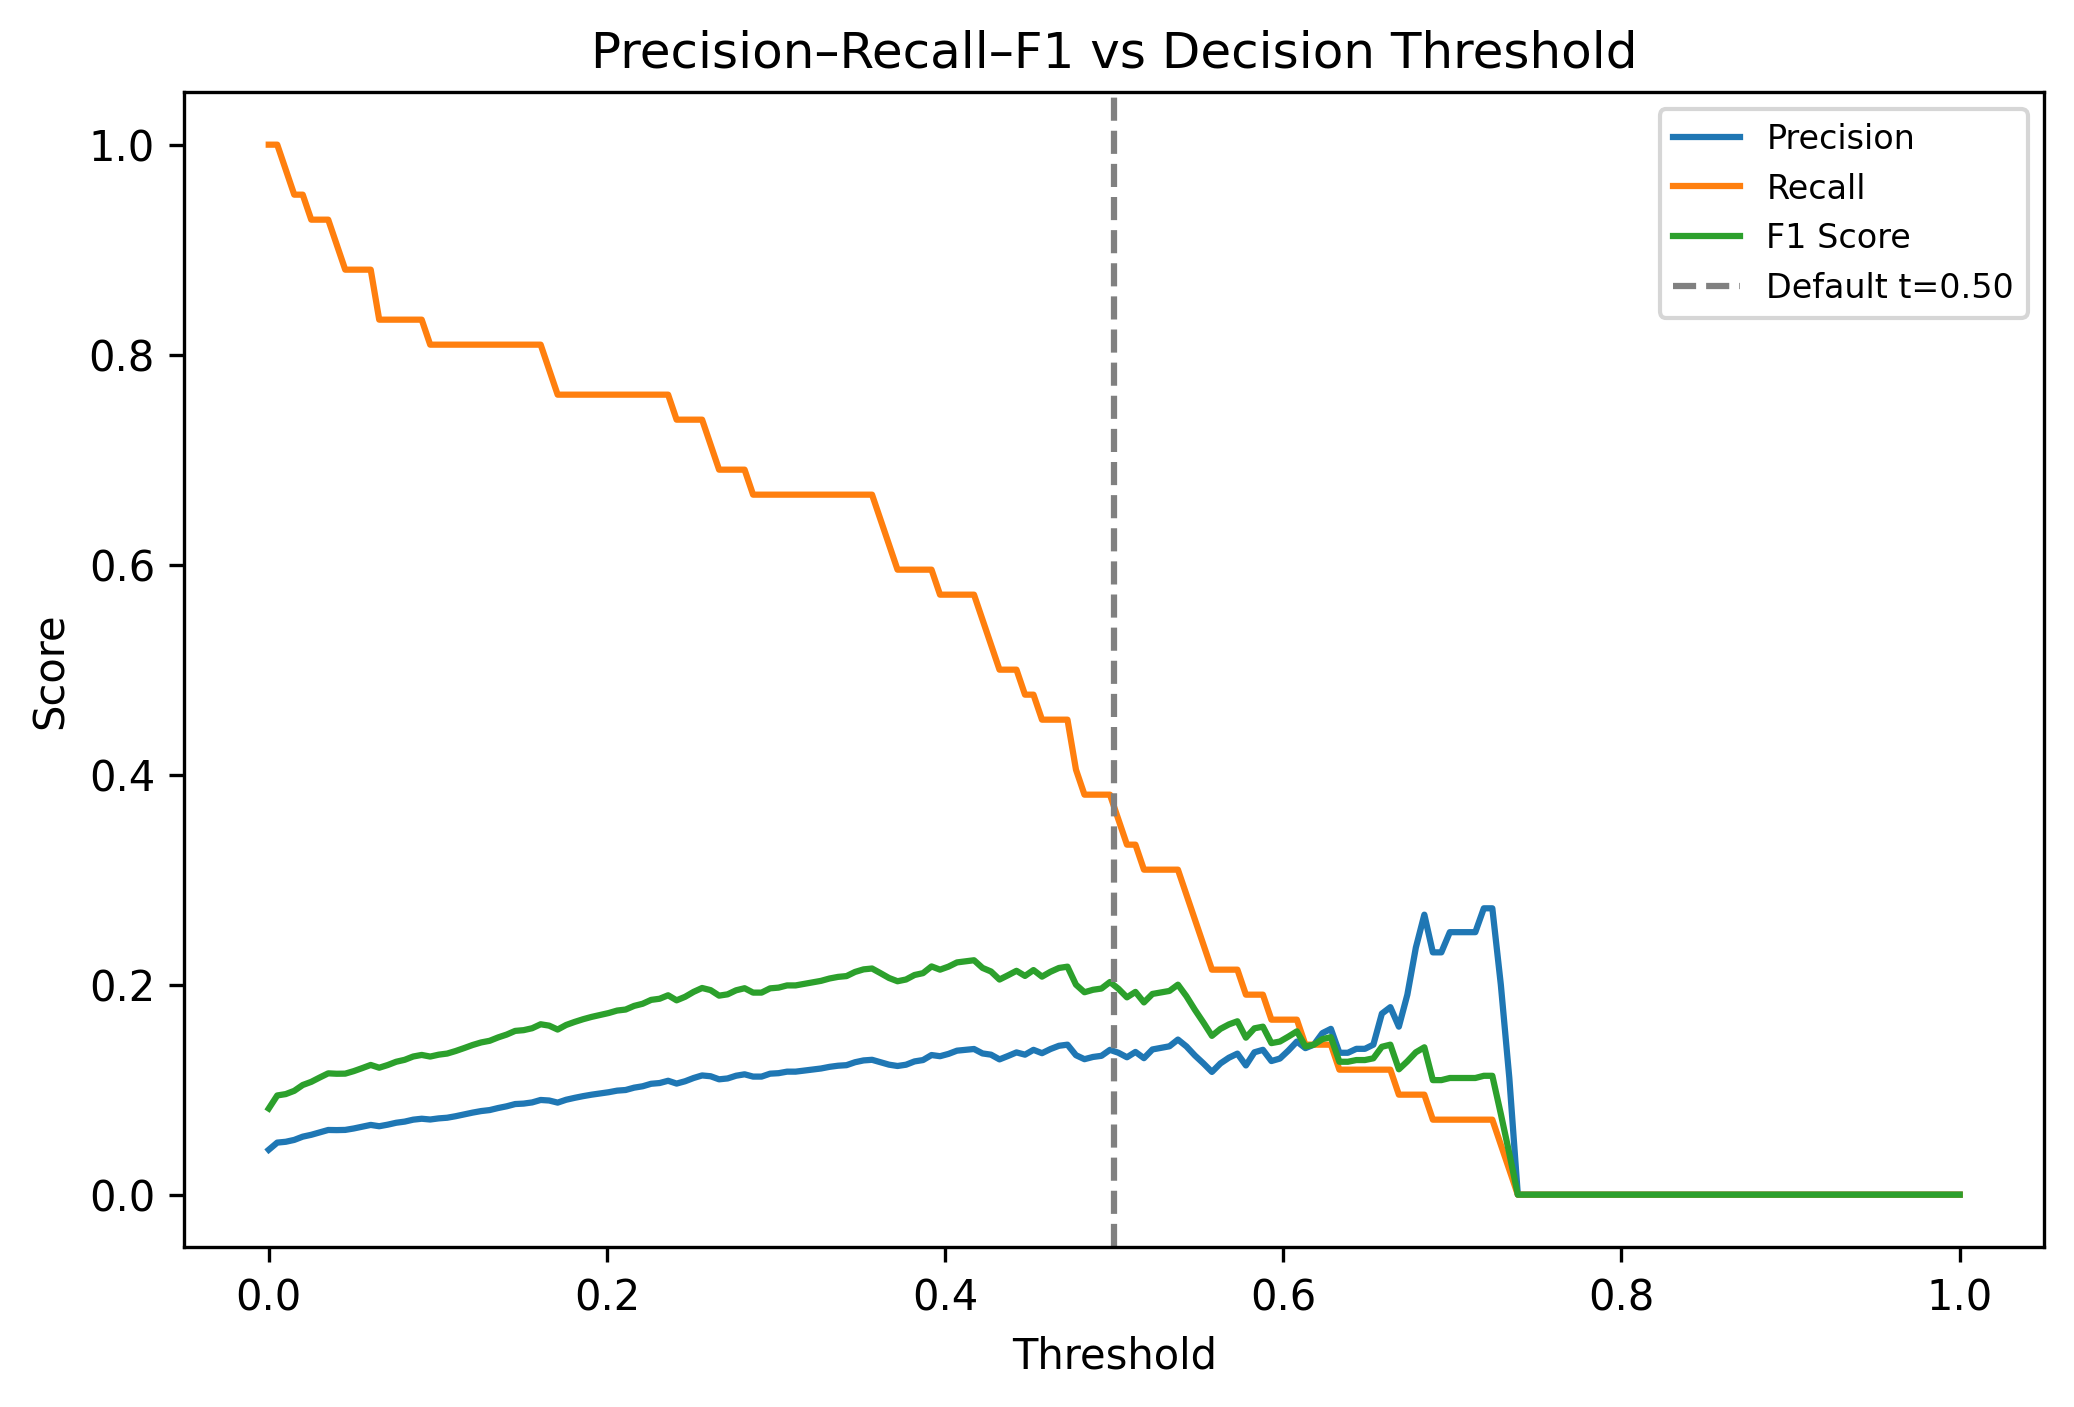

In [88]:
best_rf = results['rf_clf']['best_model']
y_proba = best_rf.predict_proba(X_test)[:, 1]
threshold_curve(y_test, y_proba)

In [90]:
# Maximize F1
t_f1, score_f1 = find_best_threshold(y_test, y_proba, beta=1)

print("Best threshold (F1):", t_f1)
print("Best F1 score:", score_f1)
print("")

# Maximize recall-heavy score (F2)
t_f2, score_f2 = find_best_threshold(y_test, y_proba, beta=2)

print("Best threshold (F2):", t_f2)
print("Best F2 score:", score_f2)
print("")


# Maximize recall-heavy score (F3)
t_f3, score_f3 = find_best_threshold(y_test, y_proba, beta=3)

print("Best threshold (F3):", t_f3)
print("Best F3 score:", score_f3)

Best threshold (F1): 0.4170854271356784
Best F1 score: 0.22325581395348837

Best threshold (F2): 0.35678391959798994
Best F2 score: 0.3626943005181347

Best threshold (F3): 0.2562814070351759
Best F3 score: 0.47619047619047616


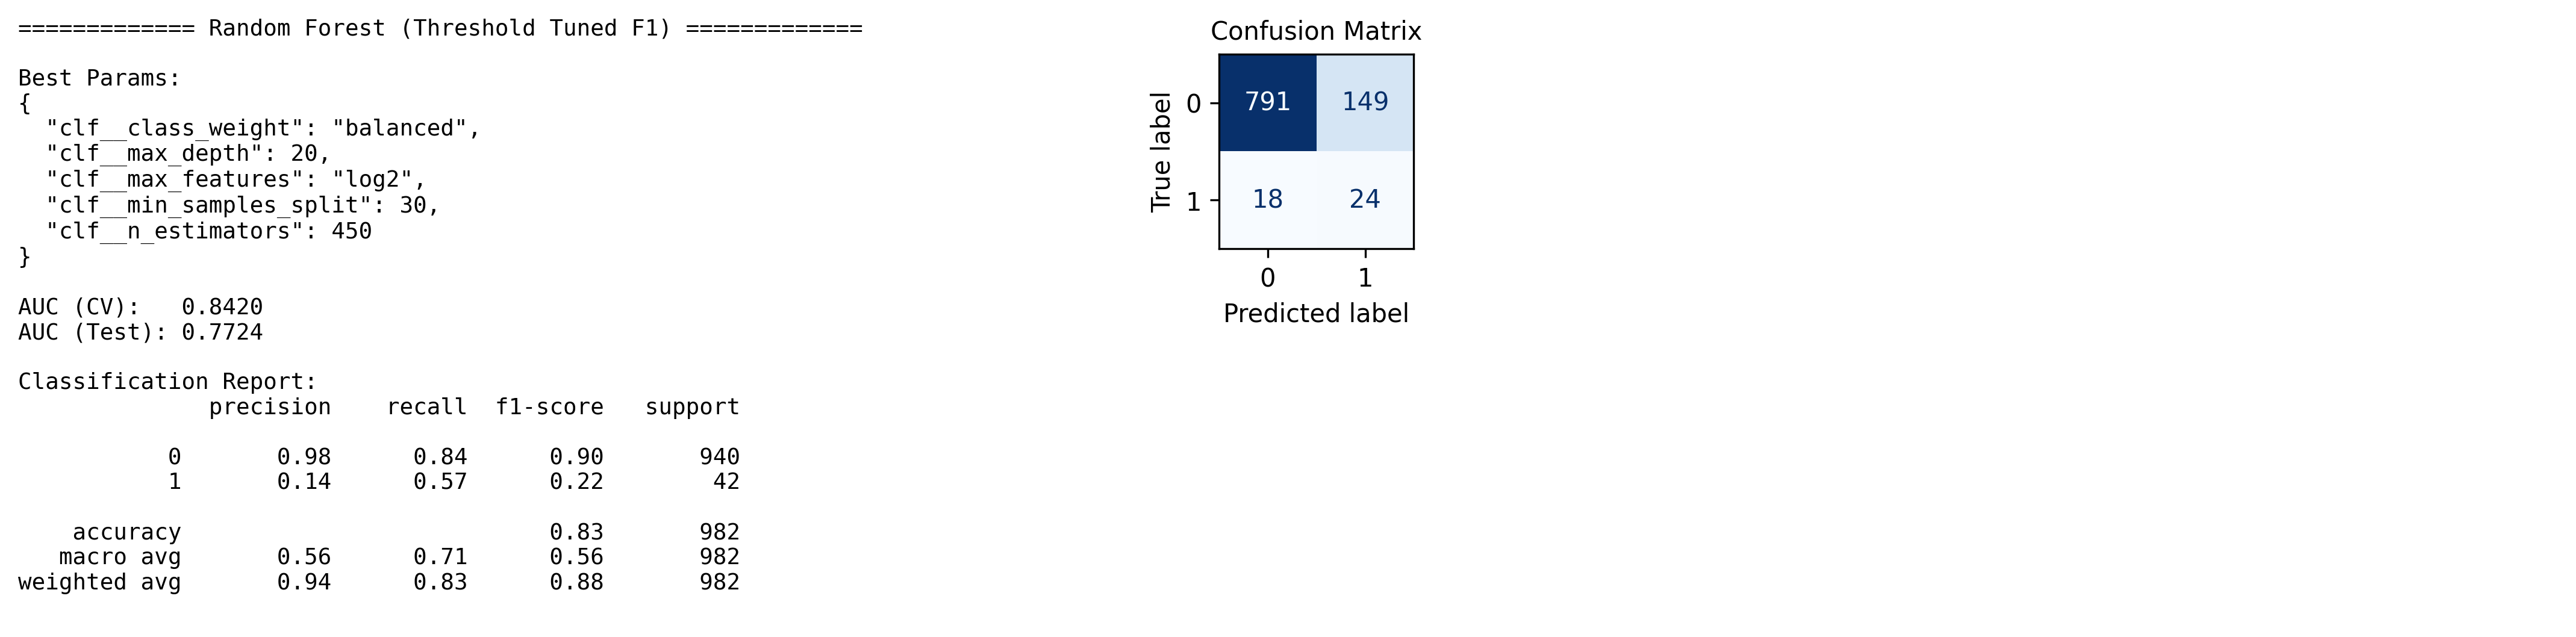

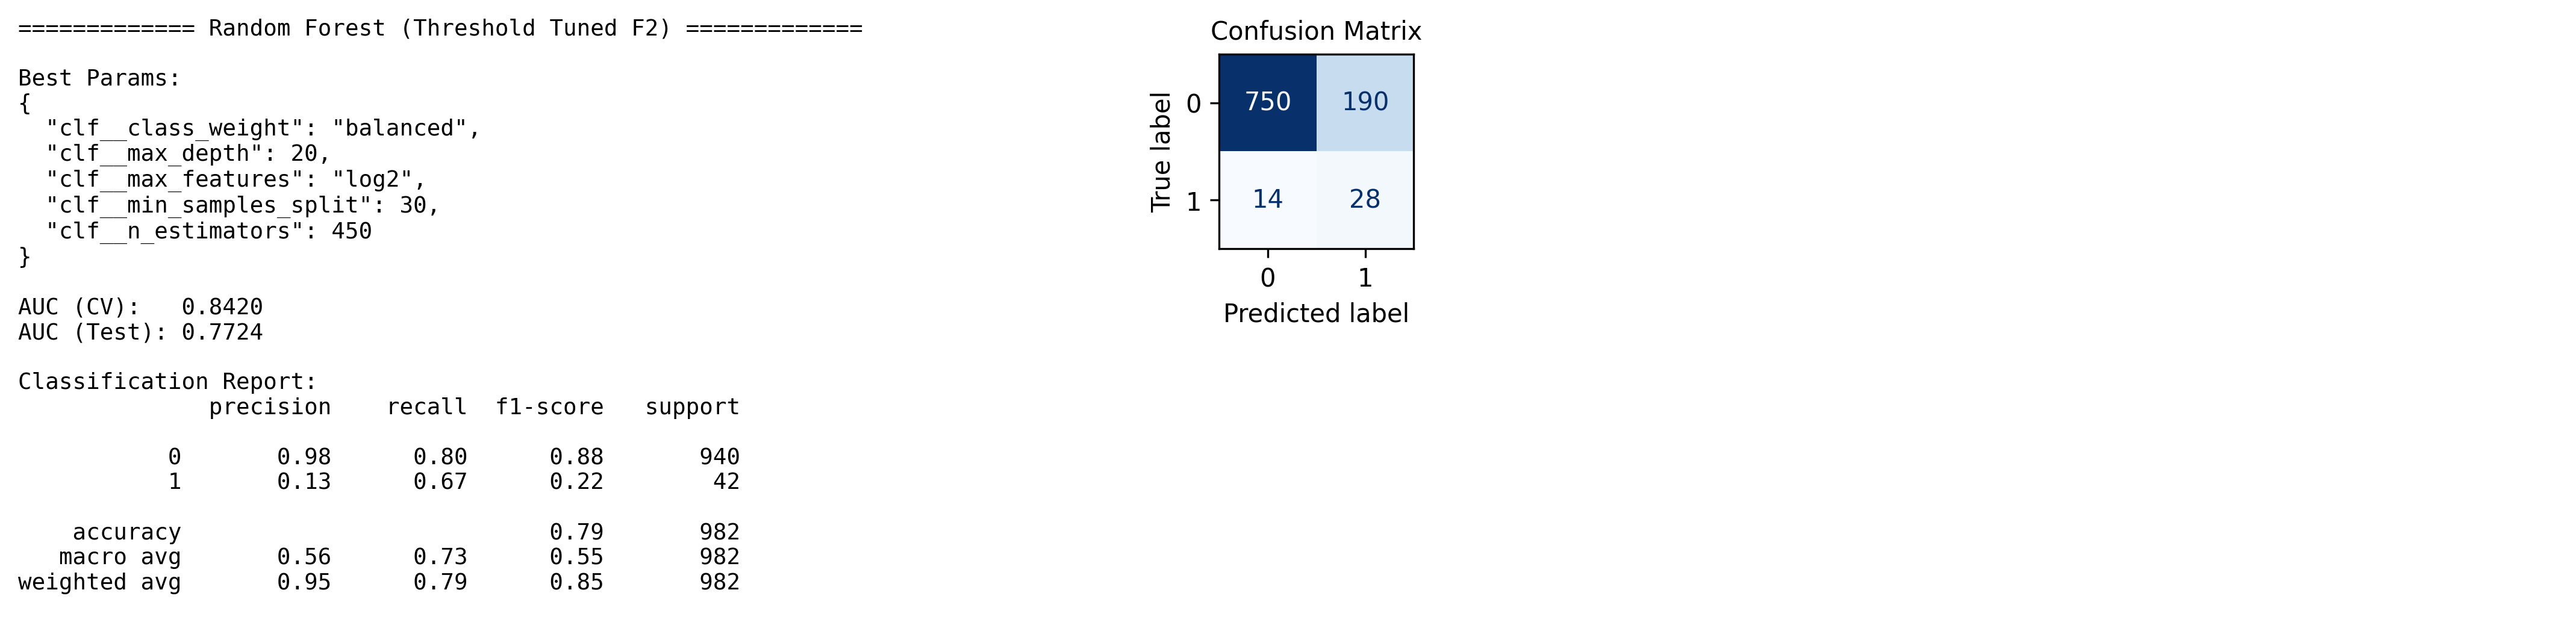

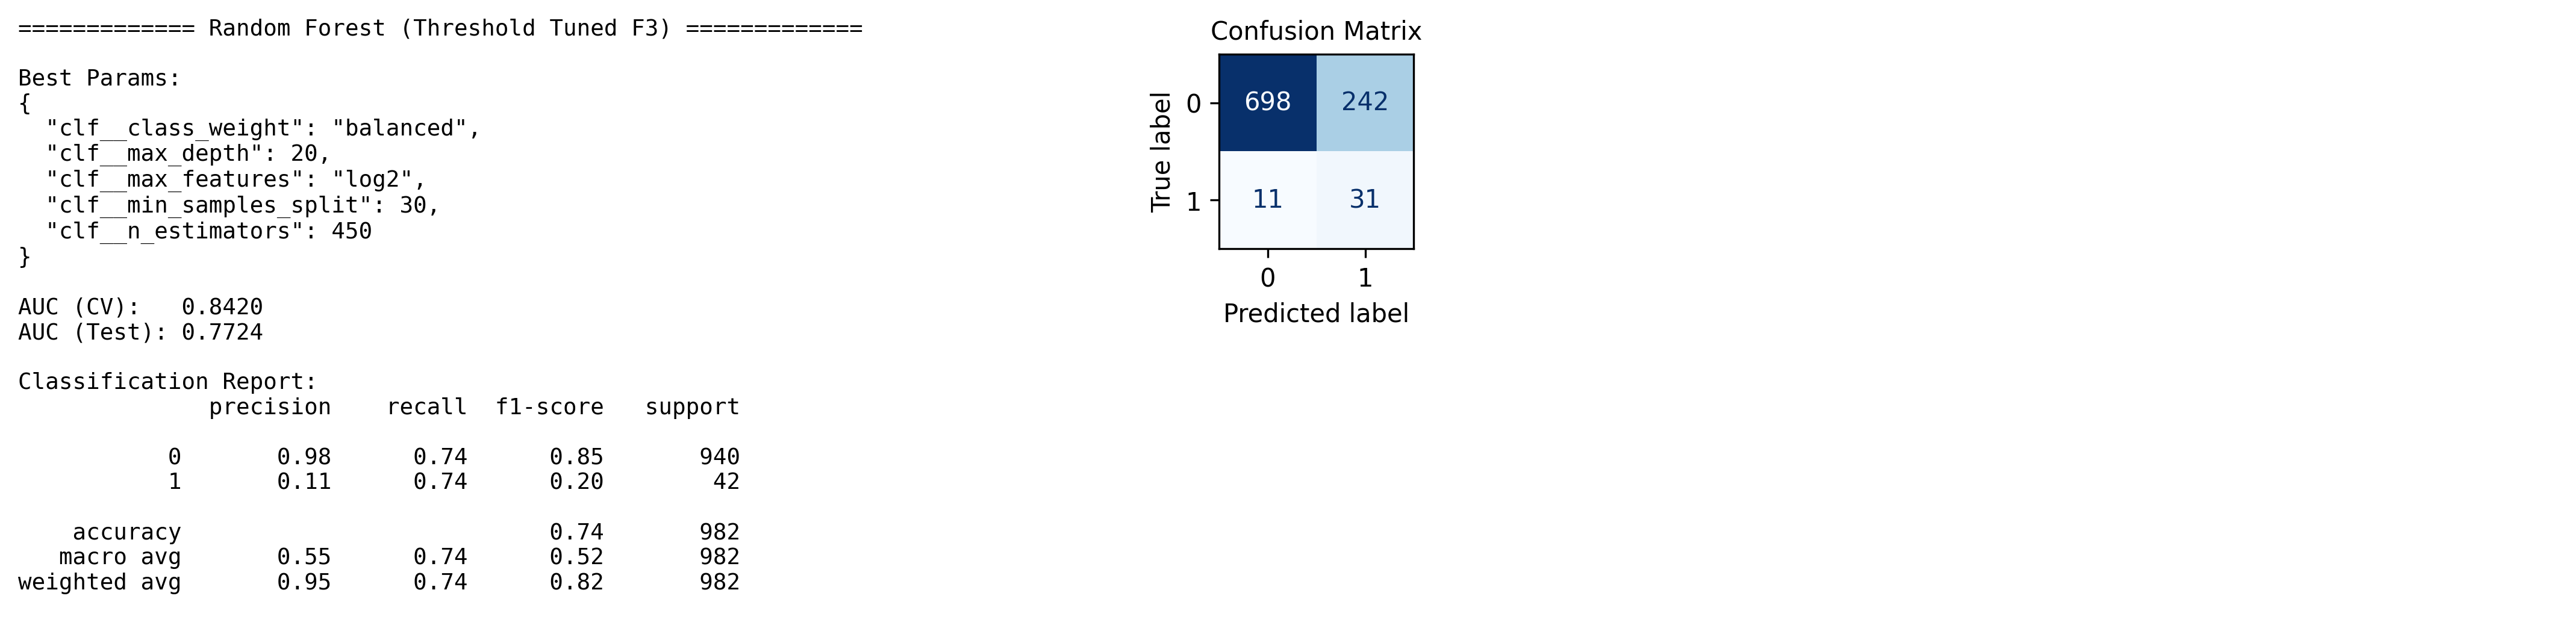

In [91]:
# Evaluate at F1
rf_th_metrics_f1 = eval_at_threshold(y_test, y_proba, threshold=t_f1, beta=1)

display_model_results(
    name="Random Forest (Threshold Tuned F1)",
    grid=results['rf_clf']['grid'],
    metrics=rf_th_metrics_f1,
    cm=rf_th_metrics_f1['confusion_matrix'],
    best_model=best_rf
)

# Evaluate at F2
rf_th_metrics_f2 = eval_at_threshold(y_test, y_proba, threshold=t_f2, beta=2)

display_model_results(
    name="Random Forest (Threshold Tuned F2)",
    grid=results['rf_clf']['grid'],
    metrics=rf_th_metrics_f2,
    cm=rf_th_metrics_f2['confusion_matrix'],
    best_model=best_rf
)

# Evaluate at F3
rf_th_metrics_f3 = eval_at_threshold(y_test, y_proba, threshold=t_f3, beta=3)

display_model_results(
    name="Random Forest (Threshold Tuned F3)",
    grid=results['rf_clf']['grid'],
    metrics=rf_th_metrics_f3,
    cm=rf_th_metrics_f3['confusion_matrix'],
    best_model=best_rf
)

### SVC RBF Threshold tuning

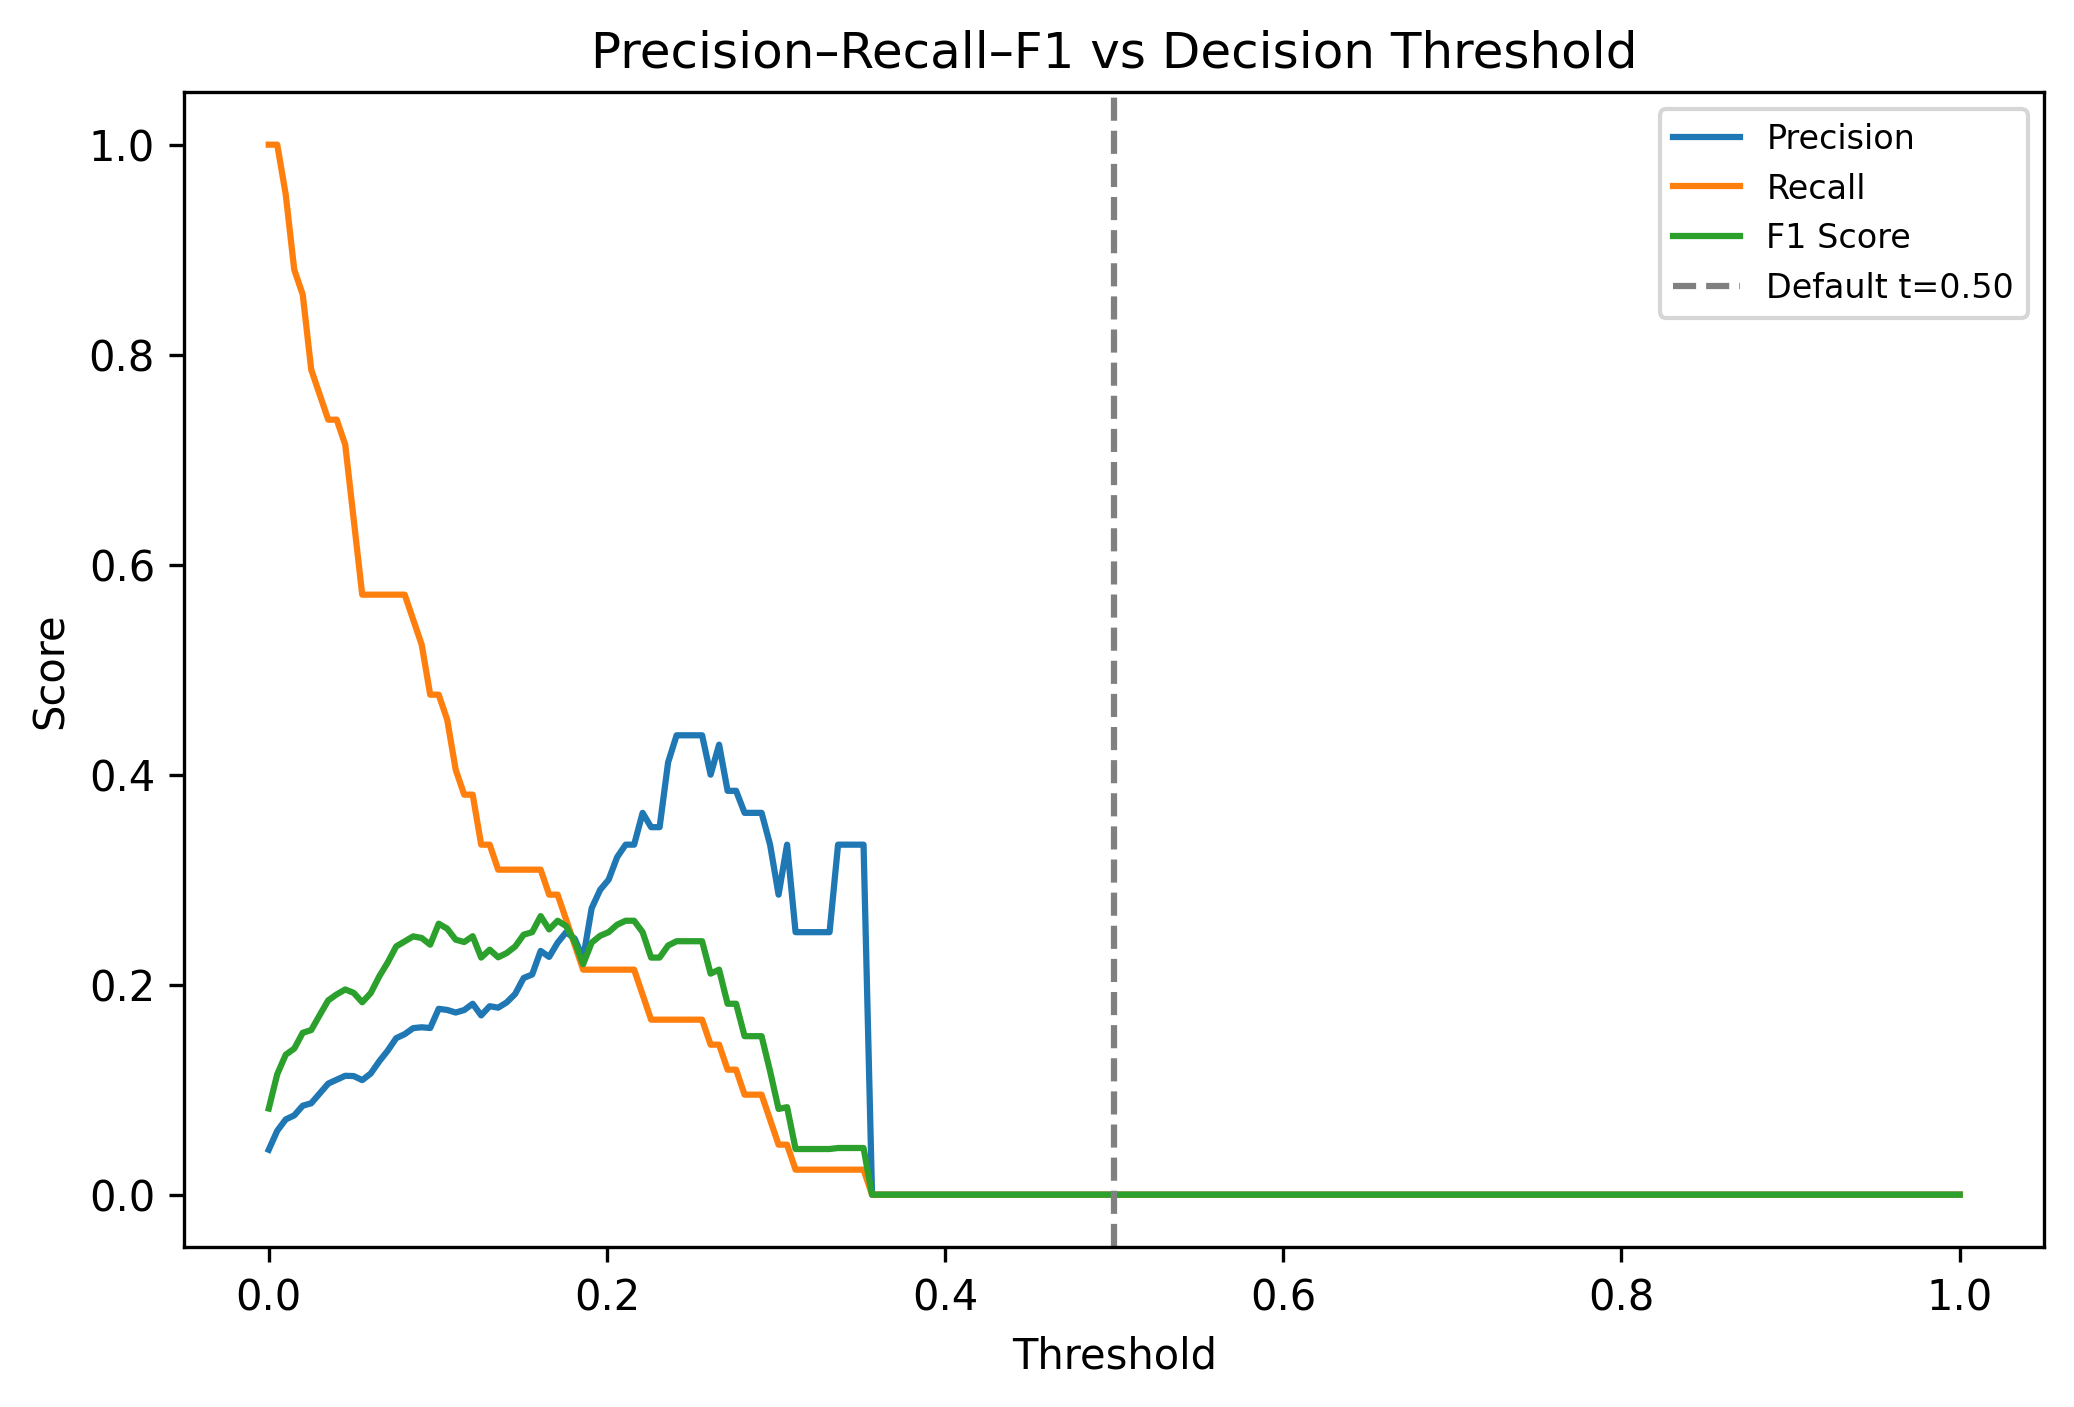

In [92]:
# Tuning SVC
best_svc = results['svc_rbf']['best_model']
y_proba = best_svc.predict_proba(X_test)[:, 1]
threshold_curve(y_test, y_proba)

In [93]:
# Maximize F1
t_f1, score_f1 = find_best_threshold(y_test, y_proba, beta=1)

print("Best threshold (F1):", t_f1)
print("Best F1 score:", score_f1)
print("")

# Maximize recall-heavy score (F2)
t_f2, score_f2 = find_best_threshold(y_test, y_proba, beta=2)

print("Best threshold (F2):", t_f2)
print("Best F2 score:", score_f2)
print("")


# Maximize recall-heavy score (F3)
t_f3, score_f3 = find_best_threshold(y_test, y_proba, beta=3)

print("Best threshold (F3):", t_f3)
print("Best F3 score:", score_f3)


Best threshold (F1): 0.16080402010050251
Best F1 score: 0.2653061224489796

Best threshold (F2): 0.08040201005025126
Best F2 score: 0.36923076923076925

Best threshold (F3): 0.04020100502512563
Best F3 score: 0.4689863842662632


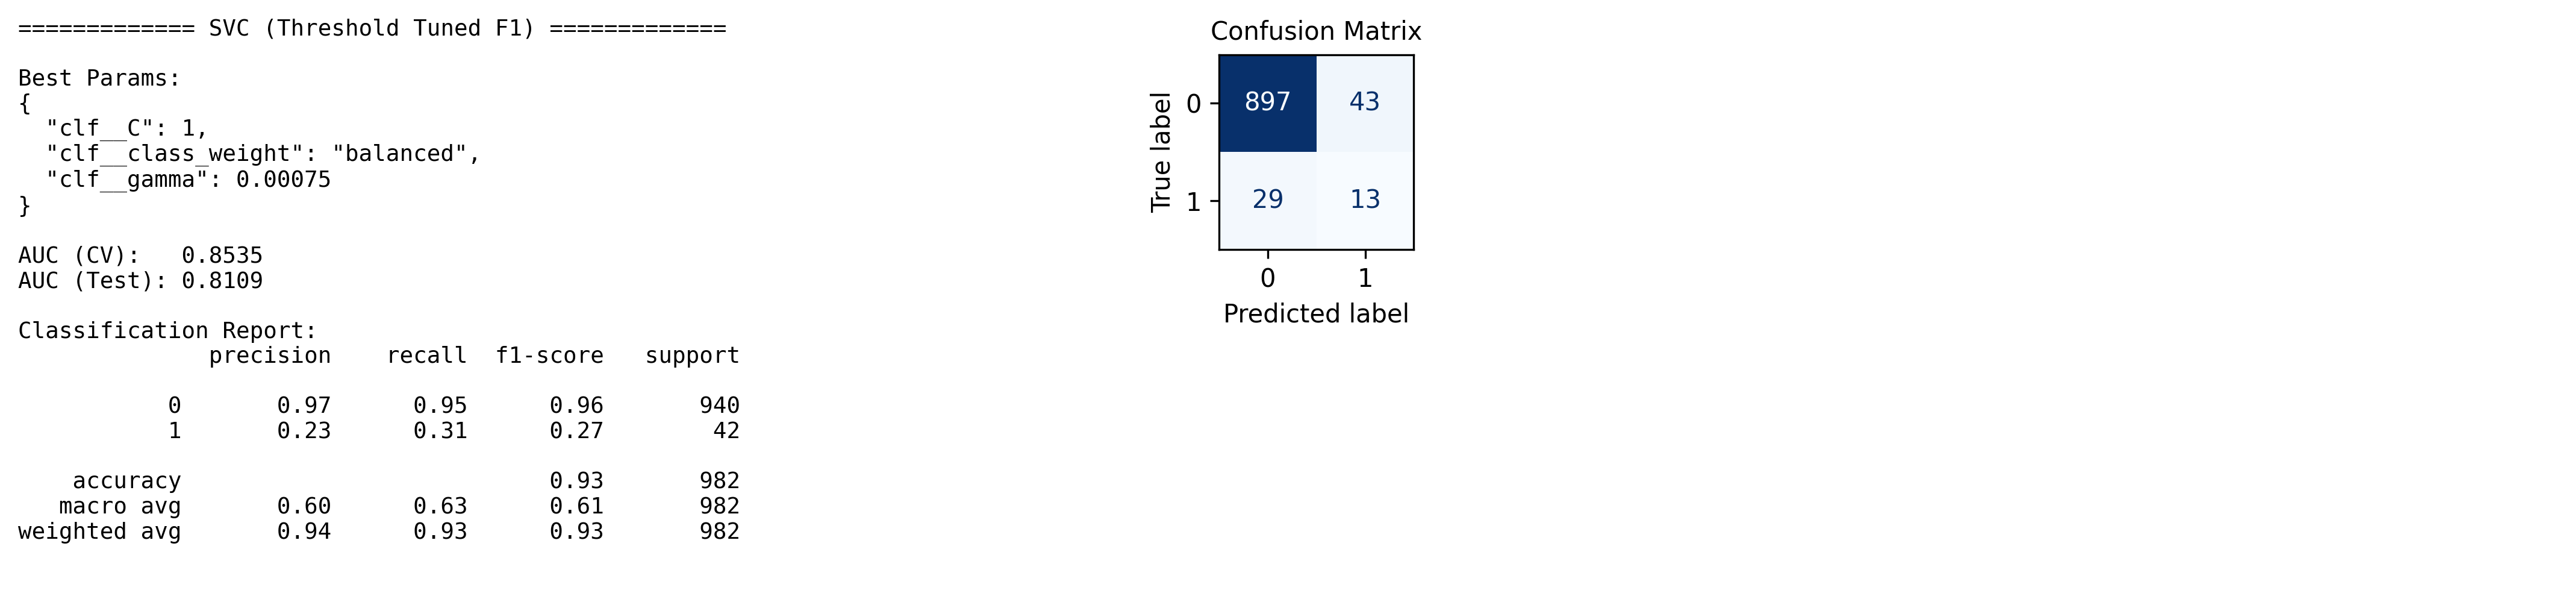

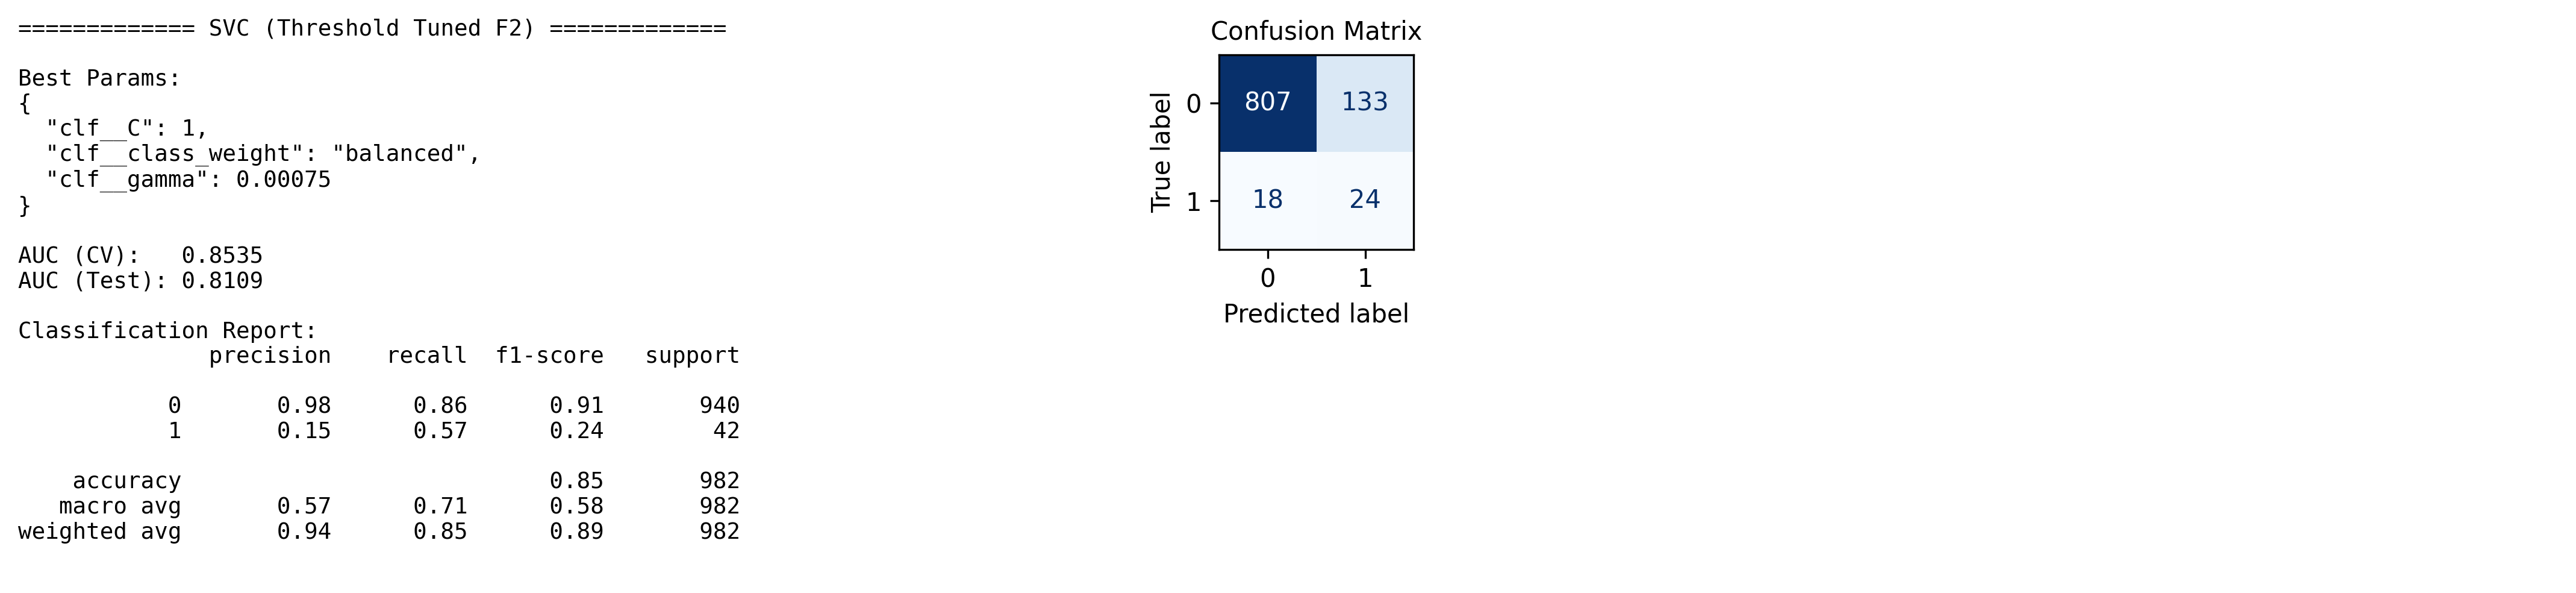

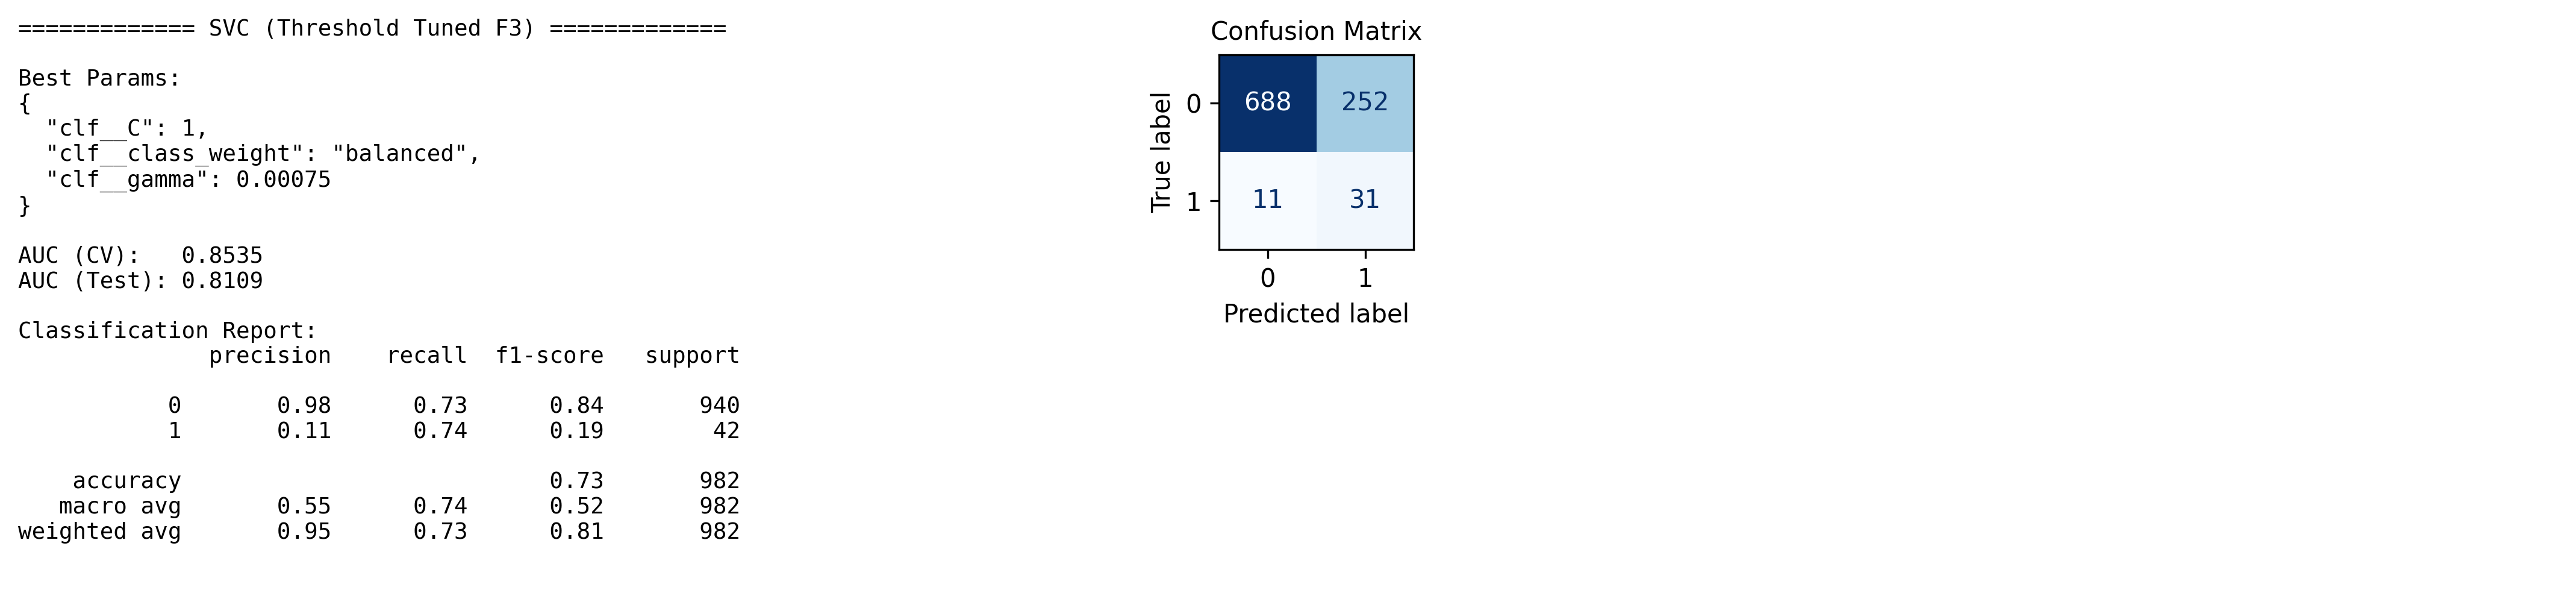

In [94]:
# Evaluate at F1
svc_th_metrics_f1 = eval_at_threshold(y_test, y_proba, threshold=t_f1, beta=1)

display_model_results(
    name="SVC (Threshold Tuned F1)",
    grid=results['svc_rbf']['grid'],
    metrics=svc_th_metrics_f1,
    cm=svc_th_metrics_f1['confusion_matrix'],
    best_model=best_svc
)

# Evaluate at F2
svc_th_metrics_f2 = eval_at_threshold(y_test, y_proba, threshold=t_f2, beta=2)

display_model_results(
    name="SVC (Threshold Tuned F2)",
    grid=results['svc_rbf']['grid'],
    metrics=svc_th_metrics_f2,
    cm=svc_th_metrics_f2['confusion_matrix'],
    best_model=best_svc
)

# Evaluate at F3
svc_th_metrics_f3 = eval_at_threshold(y_test, y_proba, threshold=t_f3, beta=3)

display_model_results(
    name="SVC (Threshold Tuned F3)",
    grid=results['svc_rbf']['grid'],
    metrics=svc_th_metrics_f3,
    cm=svc_th_metrics_f3['confusion_matrix'],
    best_model=best_svc
)

# Final Results

We can see that all models perform about the same. I could reach around ~.74-.76 recall on all models using F3, which gives 9 times more weight to the 

         AUC CV  AUC Test  recall  precision    f1
Model                                             
log_reg    0.85      0.81    0.74       0.12  0.20
gb_clf     0.85      0.80    0.76       0.10  0.18
rf_clf     0.84      0.77    0.74       0.11  0.20
svc_rbf    0.85      0.81    0.74       0.11  0.19



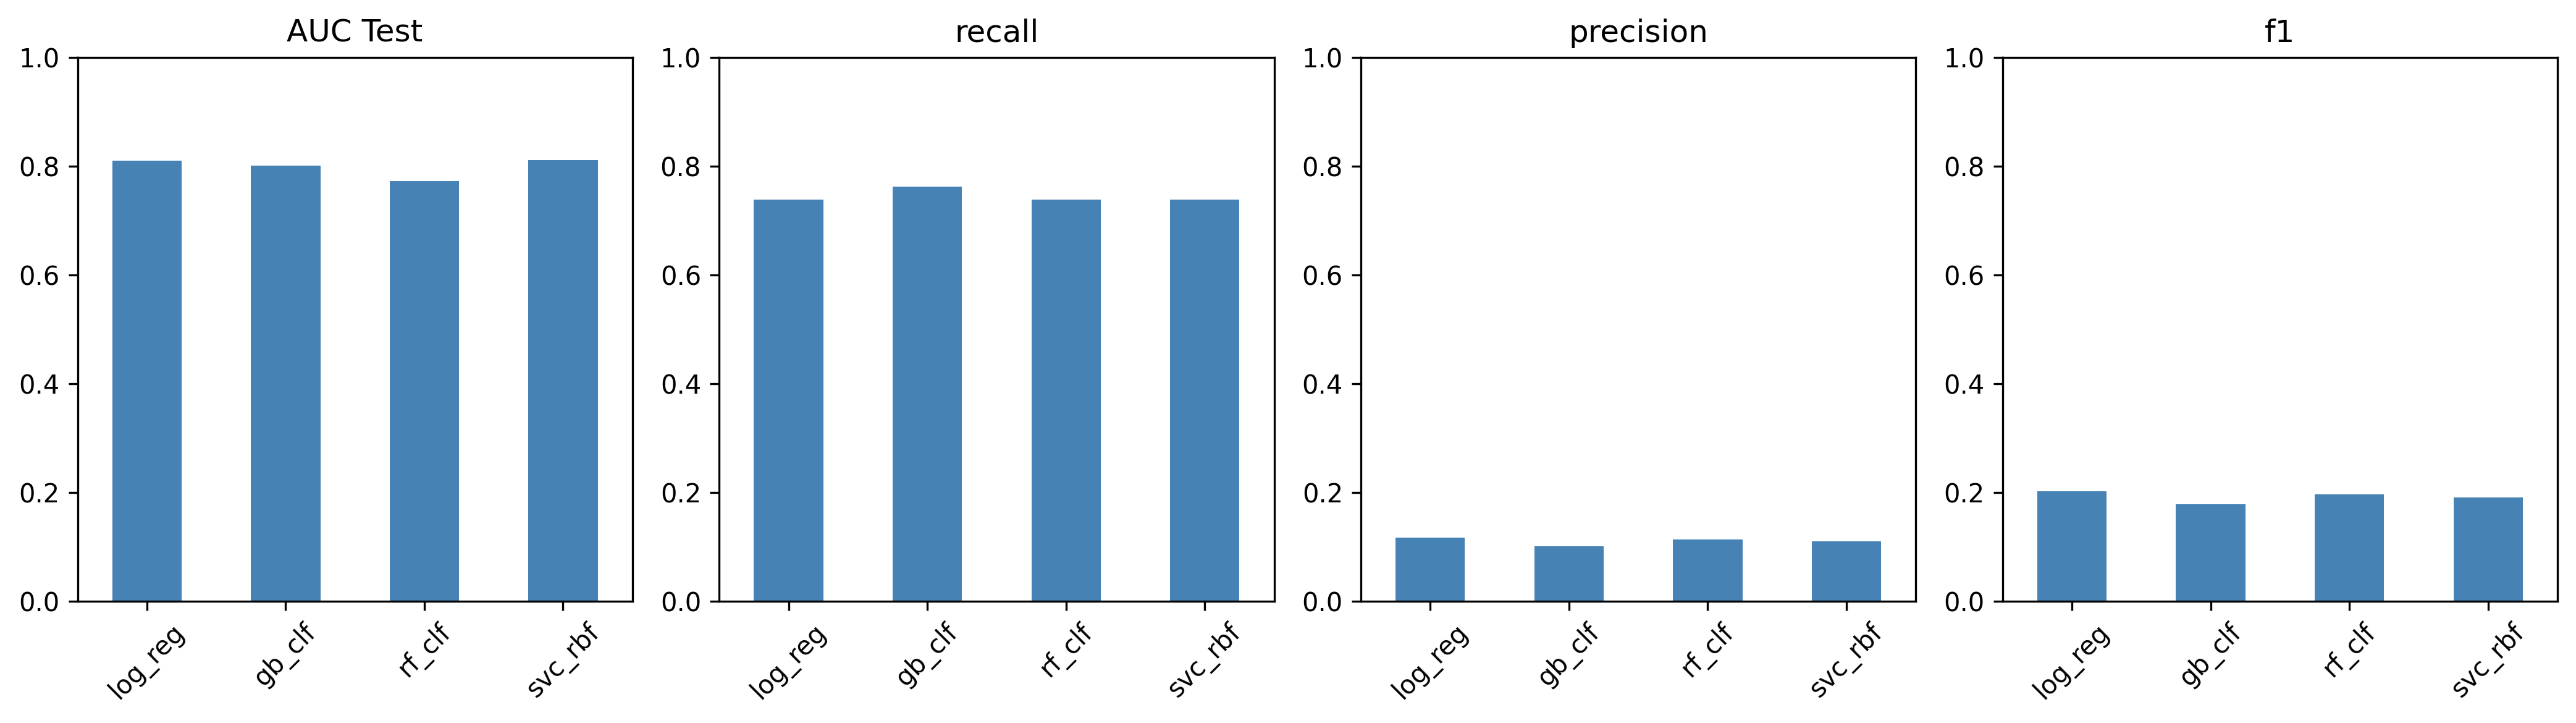

In [174]:
final_results = pd.DataFrame()
final_results['Model'] = ['log_reg', 'gb_clf', 'rf_clf', 'svc_rbf']
final_results['AUC CV']= [
    results['log_reg']['grid'].best_score_,
    results['gb_clf']['grid'].best_score_,
    results['rf_clf']['grid'].best_score_,
    results['svc_rbf']['grid'].best_score_
]
final_results['AUC Test']= [
    lr_th_metrics_f3['test_auc'],
    gb_th_metrics_f3['test_auc'],
    rf_th_metrics_f3['test_auc'],
    svc_th_metrics_f3['test_auc'],
]
final_results['recall']=[    
    lr_th_metrics_f3['recall'],
    gb_th_metrics_f3['recall'],
    rf_th_metrics_f3['recall'],
    svc_th_metrics_f3['recall'],
]
final_results['precision']=[    
    lr_th_metrics_f3['precision'],
    gb_th_metrics_f3['precision'],
    rf_th_metrics_f3['precision'],
    svc_th_metrics_f3['precision'],
]
final_results['f1']=[    
    lr_th_metrics_f3['f1'],
    gb_th_metrics_f3['f1'],
    rf_th_metrics_f3['f1'],
    svc_th_metrics_f3['f1'],
]

final_results = final_results.set_index("Model")
print(final_results.round(2))
print()

fig, axes = plt.subplots(1,4, figsize=(14, 4))

for i, metric in enumerate(["AUC Test", "recall", "precision", "f1"]):
    final_results[metric].plot(kind="bar", color="steelblue", ax=axes[i])
    axes[i].set_ylim(0, 1)
    axes[i].set_title(metric)
    axes[i].set_xlabel("")
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
#$plt.show()
show_shrunk(fig, width=1200)
